# Final project

Here we propose a final project for the course.

## Goals and motivations

This is meant as an extended exercise collecting and summarising the content of the whole course.
The aim is to give each student the freedom to choose the best solution he is comfortable with and to justify the choice with some data-driven consideration.

---

## Project Definition: Bike rent prediction

<p align="center">
  <img src="https://storage.googleapis.com/kaggle-datasets-images/34295/55637/3ed905f1776dbdf1eeadb0c0007b948c/dataset-cover.jpg?t=2018-07-12-23-51-34" height="250", alt="Bike chain">
</p>

The aim of this project is to help a bike sharing service to predict the hourly number of rented bikes for the following week. The dataset is made by train and test files, where one can find for each hour the amount of bikes rented by customers of a bike sharing service in Washington DC, together with other features such as whether a certain day was a national holiday, and which day of the week was it.

---

## Project scheme

Here we describe how the project should be developed, or better what are the expected inputs and outputs.
Each student should deliver a project that corresponds to the project scheme.
We are inspired by [Kaggle Competitions](https://www.kaggle.com/competitions), so we will use the same format.

### Inputs

Data are provided in the `DataProject` folder.
The idea is to use such data to solve a problem.

We will use the following data structures:

- **DataProject**: a directory containing one or more csv files.
  - `train.csv`: training data with labels.
  - `test.csv`: test data with no labels.
  - `sample_submission.csv`: sample submission.
  - `VariableDefinitions.csv`: a csv file containing a description of the data.

### Outputs

These are the expected outputs of the project.

- **Submission**: a csv file containing the results of the project, according to the sample submission format.
- **FinalProject_Notebook**: a notebook file containing analysis, relevant choices and results comments and explanations.
- **{NAME}_model.joblib**: a file containing the trained model in the form of a pipeline.

## Evaluation

The evaluation metric for this challenge is the Mean Absolute Percentage Error, **MAPE** on a test set (not provided).

The values can be between $0$ and $+\infty$.

Your `submission` file should look like:

|       date       |      hour         |      count        |
| ---------------- | ----------------- | ----------------- |
|     2012-12-01   |        00         |       15          |
|        ...       |       ...         |      ...          |

---

### Hint to save the model

One can save the model pipeline (so all the relevant feature engineering and preprocessing steps can be executed automatically) in a file with the following example code:

```python
from sklearn.externals import joblib
pipe = Pipeline([
                ('scaler', StandardScaler()), 
                ('model', LogisticRegression())
                ])

pipe.fit(X_train, y_train)
pipe.predict(X_test) # Not compulsory to save the model.

joblib.dump(pipe, '{NAME}_model.joblib')
```


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error, make_scorer, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.arima_model import ARIMA
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 10.0)
sns.set()

import warnings
warnings.filterwarnings('ignore')

from utils.plottings import plot_learning_curve

In [2]:
# CHECKING ALL COLUMNS (FEATURES) FROM VARIABLE DEFINITIONS

with open('data/VariableDefinitions.csv') as f:
    for line in f:
        print(line)

instant;record index

dteday;date

season;season (1:springer, 2:summer, 3:fall, 4:winter)

yr;year (0: 2011, 1:2012)

mnth;month ( 1 to 12)

hr;hour (0 to 23)

holiday;whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)

weekday;day of the week

workingday;if day is neither weekend nor holiday is 1, otherwise is 0.

weathersit;(1: Clear, Few clouds, Partly cloudy, Partly cloudy. 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist. 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds. 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)

temp;Normalised temperature in Celsius. The values are divided to 41 (max)

atemp;Normalised feeling temperature in Celsius. The values are divided to 50 (max)

hum;Normalised humidity. The values are divided to 100 (max)

windspeed;Normalised wind speed. The values are divided to 67 (max)

casual;count of casual users

registered;count of registered users

c

# Final Pipeline

In [307]:
## Lorenzo Carovillano

## These classes can be used inside a Pipeline, 
## and all them doing changes into the input dataframe


#################################################################################################
#                                                                                               #
# map integer hours to 2 length character, like '4' to '04'                                     #
#                                                                                               #
#################################################################################################
class hoursMapperTransformer():
    def __init__(self,column):
        self.column=column

    def transform(self,X,y=None):
        X[self.column].map(
            {0: '00', 1: '01', 2: '02', 3: '03', 4: '04', 
             5: '05', 6: '06', 7: '07', 8: '08', 9: '09'})
        return X

    def fit(self, X, y=None):
        return self 

#################################################################################################
#                                                                                               #
# Make a column index 'Date' as hourly DateTimeIndex                                            #
# first input = date of the day, value example: '2011-12-01'                                    #
# second input = hour, values example: '00' - '24'                                              #
#                                                                                               #
#################################################################################################
class hourlyIndexDateTransformer():
    def __init__(self,column_day,column_hour):
        self.column_day=column_day
        self.column_hour=column_hour

    def transform(self,X,y=None):
        X.loc[:,'Date'] = pd.to_datetime(
            X[self.column_day].astype(str)+' '+X[self.column_hour].astype(str)+":00:00")
        X = X.set_index('Date')
        return X
    
    def fit(self, X, y=None):
        return self 

#################################################################################################
#                                                                                               #
# This function drop passed array of 'columns' names                                            #
#                                                                                               #
#################################################################################################
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1,errors='ignore')

    def fit(self, X, y=None):
        return self 

#################################################################################################
#                                                                                               #
# MinMaxScaler for input 'columns' array[] of columns names                                     #
#                                                                                               #
#################################################################################################
class customMinMaxScaler():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        X[self.columns] = MinMaxScaler().fit_transform(X[self.columns])
        X[self.columns] = X[self.columns].astype(float)
        return X

    def fit(self, X, y=None):
        return self 

#################################################################################################
#                                                                                               #
# StandardScaler ignoring target='cnt'                                                          #
#                                                                                               #
#################################################################################################
class customStandardScaler():
    def __init__(self):
        return
    
    def transform(self,X,y=None):
        columns=X.columns.values.tolist()
        columns.remove('cnt')
        X[columns] = StandardScaler().fit_transform(X[columns])
        return X

    def fit(self, X, y=None):
        return self 

#################################################################################################
#                                                                                               #
# This class add a column using input name                                                      #
# Assign a category for an hourly range                                                         #
# This need to handle the seasonal trend using cateogoreis                                      #
#                                                                                               #
#################################################################################################
class hoursCategoriesTransformer():

    def __init__(self):
        return
        
    def transform(self,X,y=None):
        hc = []
        for index, row in X.iterrows():
            hc.append(get_hour_category(index.hour))
        X['hour_category'] = hc
        return X

    def fit(self, X, y=None):
        return self 
    
#################################################################################################
#                                                                                               #
# This function return a category for input hour                                                #
#                                                                                               #
#################################################################################################
def get_hour_category(hour):
    
    if hour in [21, 22, 23]:
        return 1 # nigth
    elif hour in [0, 1, 2, 3]:
        return 2 # late nigth
    elif hour in [4, 5]:
        return 3 # sunrise
    elif hour in [6, 7]:
        return 4 # Peak time morning
    elif hour in [8, 9]:
        return 5 # Maximum peak time 
    elif hour in [10, 11]:
        return 6 # morning
    elif hour in [12, 13, 14]:
        return 7 # late morning and lunch
    elif hour in [15, 16]:
        return 8 # Peak time afternoon
    elif hour in [17, 18]:
        return 9 # Maximum peak time 
    elif hour in [19, 20]:
        return 10 # Late afternoon and dinner
    
#################################################################################################
#                                                                                               #
# Creating the 'transformer' Pipeline                                                           #
#                                                                                               #
#################################################################################################
transformer_pipe = Pipeline([
    ('hoursMapperTransformer', hoursMapperTransformer('hr')),
    ('hourlyIndexDateTransformer', hourlyIndexDateTransformer('dteday', 'hr')),
    ('columnDropperTransformer', columnDropperTransformer(
        ['dteday', 'hr', 'weekday', 'instant', 'yr', 'mnth', 'season', 'casual', 
         'registered', 'temp'])),
    ('hoursCategoriesTransformer', hoursCategoriesTransformer()),
    ('minmaxscaler', customMinMaxScaler(['weathersit', 'hour_category']))
])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   holiday        16637 non-null  float64
 1   workingday     16637 non-null  float64
 2   weathersit     16637 non-null  float64
 3   atemp          16637 non-null  float64
 4   hum            16637 non-null  float64
 5   windspeed      16637 non-null  float64
 6   hour_category  16637 non-null  float64
dtypes: float64(7)
memory usage: 1.0 MB


None

holiday    workingday    weathersit         atemp           hum  \
count  16637.000000  16637.000000  16637.000000  16637.000000  1.663700e+04   
mean       0.028731      0.684348      0.138597      0.482629  6.247482e-01   
std        0.165337      0.461496      0.200110      0.171035  1.907505e-01   
min        0.000000      0.000000      0.000000      0.007600  2.220446e-16   
25%        0.000000      0.000000      0.000000      0.340900  4.750000e-01   
50%        0.000000      1.000000      0.000000      0.500000  6.300000e-01   
75%        0.000000      1.000000      0.333333      0.621200  7.800000e-01   
max        1.000000      1.000000      0.833333      0.992400  1.000000e+00   

          windspeed           cnt  hour_category  
count  16637.000000  16637.000000   16637.000000  
mean       0.190330    190.476077       0.455214  
std        0.114334    174.804255       0.309137  
min        0.000000      1.000000       0.000000  
25%        0.111950     45.500000       0.111111  
50%        0.179100    148.500000       0.500000  
75%        0.261200    285.000000       0.722222  
max        0.850700    951.000000       1.000000

holiday  workingday  weathersit    atemp    hum  \
Date                                                                   
2011-01-01 00:00:00      0.0         0.0    0.000000  0.28030  0.805   
2011-01-01 01:00:00      0.0         0.0    0.000000  0.27270  0.800   
2011-01-01 02:00:00      0.0         0.0    0.000000  0.28030  0.775   
2011-01-01 03:00:00      0.0         0.0    0.000000  0.28790  0.750   
2011-01-01 04:00:00      0.0         0.0    0.166667  0.27275  0.750   

                     windspeed  hour_category  
Date                                           
2011-01-01 00:00:00     0.0000       0.111111  
2011-01-01 01:00:00     0.0000       0.111111  
2011-01-01 02:00:00     0.0000       0.111111  
2011-01-01 03:00:00     0.0000       0.166667  
2011-01-01 04:00:00     0.0448       0.222222

Date
2011-01-01 00:00:00     28.0
2011-01-01 01:00:00     36.0
2011-01-01 02:00:00     22.5
2011-01-01 03:00:00      7.0
2011-01-01 04:00:00      1.0
                       ...  
2012-11-30 19:00:00    311.0
2012-11-30 20:00:00    214.0
2012-11-30 21:00:00    173.0
2012-11-30 22:00:00    136.5
2012-11-30 23:00:00    110.0
Name: cnt, Length: 16637, dtype: float64

Best Model GridSearchCV: Pipeline(steps=[('rfrmodel',
                 RandomForestRegressor(max_depth=11, n_estimators=15))])
Train score RandomForestRegressor GridSearchCV model 0.9508320766013315
Train NEGATIVE MAE best score -50.26296413601538
Train NEGATIVE MAE: -28.365356455142784


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

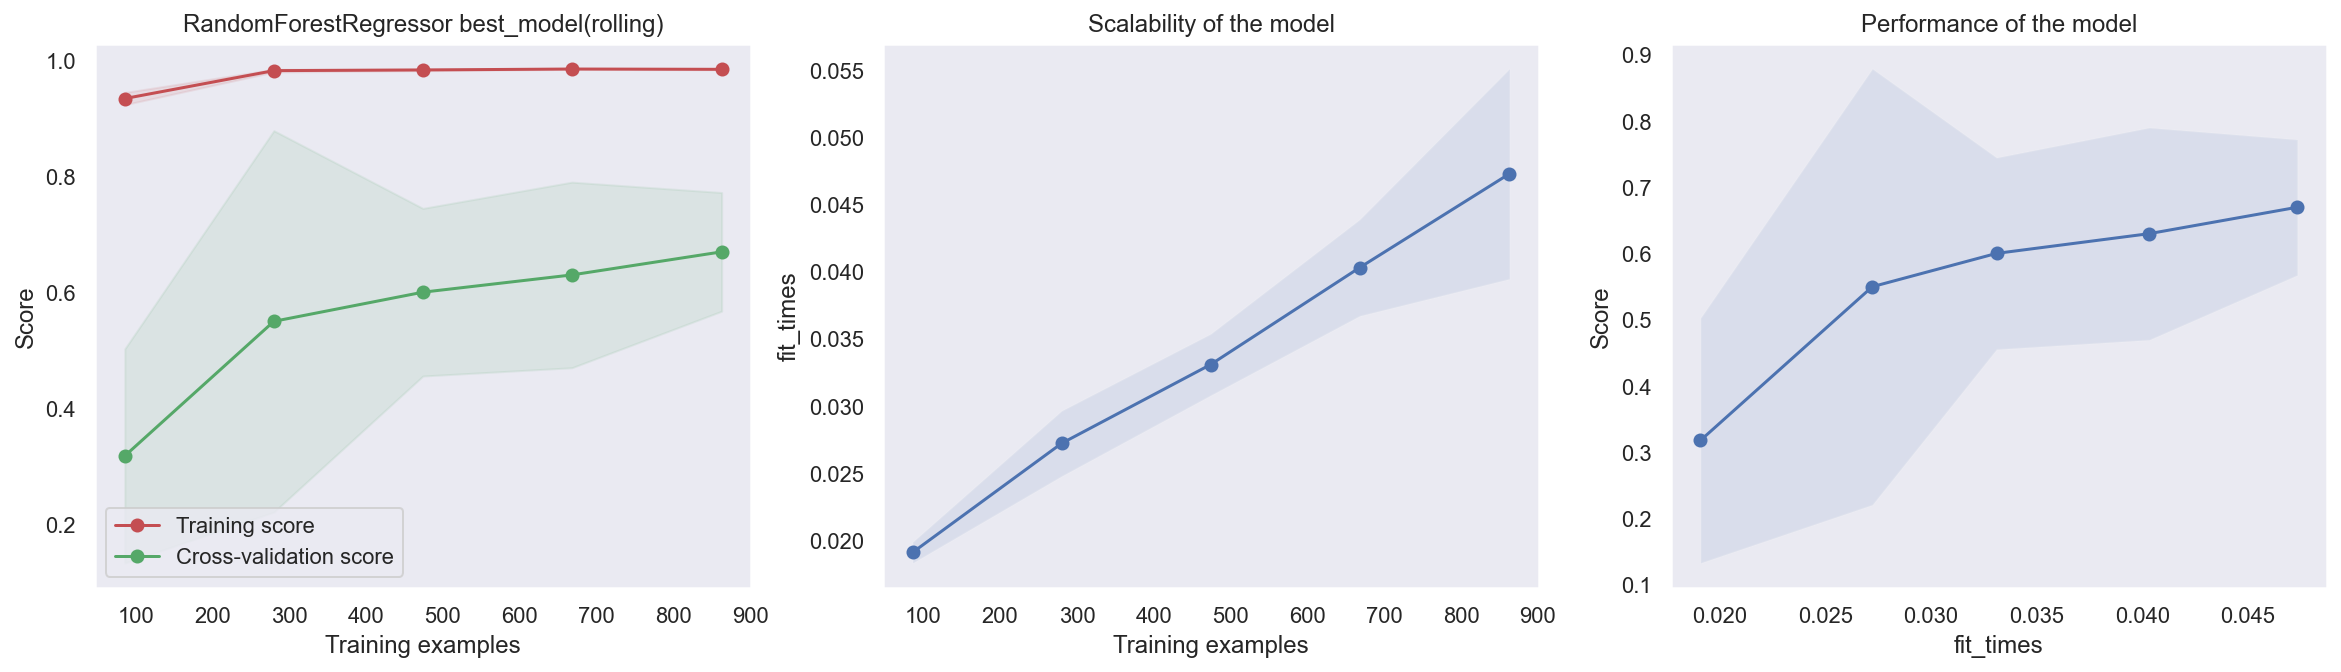

In [439]:
# Read csv data
df_train = pd.read_csv('data/train.csv')

# Columns Transformer
df_train_transformed = pd.DataFrame(transformer_pipe.fit_transform(df_train))

# Rolling using 2 hour's average
df_train_transformed = df_train_transformed.rolling('2h', center=True, min_periods=1).mean()
df_train_transformed = df_train_transformed.dropna()

# Make features X and target y
X = df_train_transformed.drop('cnt', axis=1)
y = df_train_transformed['cnt']

display(X.info())
display(df_train_transformed.describe())
display(X.head())
display(y)

# Using a subset of only last year of data
X_train = X['2011-10-01':'2012-10-30'].values
X_test = X['2012-10-30':].values
y_train = y['2011-10-01':'2012-10-30'].values
y_test = y['2012-10-30':].values

Z_test = X[:'2011-12-31'].values
Zy_test = y[:'2011-12-31'].values

# After EDA (see below in notebook) and after testing other models i choosed the RandomForestRegressor
model_pipe = Pipeline([
    
    #('lrmodel', LinearRegression())
    #('sdgmodel', SGDRegressor(alpha=1.3, epsilon=0.2))
    #('xgbmodel', XGBRegressor())
    #('svr', SVR(gamma='auto', kernel='linear'))
    #('dt', DecisionTreeRegressor())
    ('rfrmodel', RandomForestRegressor())
])

param_search = { 
    
    # XGB REGRESSOR HYPERPARAMETERS
    #'xgbmodel__max_depth': [i for i in range(1,10)],
    #'xgbmodel__learning_rate': [0.001, 0.01, 0.03, 0.05]
    
    # RANDOM FOREST REGRESSOR HYPERPARAMETERS
    'rfrmodel__n_estimators': [5, 10, 15, 20, 25],
    #'rfrmodel__max_features': ['sqrt', 'log2', 'auto'],
    'rfrmodel__max_depth' : [i for i in range(5,25)]
    
    # SDG REGRESSOR HYPERPARAMETERS
    #'sdgmodel__epsilon':[0.1,0.2,0.5,0.3],
    #'sdgmodel__alpha': [0.001, 0.01, 0.1, 0.5, 0.8, 1.3]
}

# Using MAE score to evaluate model results
neg_mape = make_scorer(mean_absolute_error, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=10)

# Perfornming Grid Search
gsearch = GridSearchCV(model_pipe, param_grid=param_search, cv=tscv, refit=True, scoring=neg_mape)

# Fit data into model
gsearch.fit(X_train, y_train)

# Check best model results
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print("Best Model GridSearchCV:", best_model)
print("Train score RandomForestRegressor GridSearchCV model", best_model.score(X_train, y_train))
print("Train NEGATIVE MAE best score", best_score)
print("Train NEGATIVE MAE:", -mean_absolute_error(y_train, best_model.predict(X_train)))

plot_learning_curve(best_model, "RandomForestRegressor best_model(rolling)", X_train, y_train, cv=tscv)

Test score RandomForestRegressor GridSearchCV model 0.7246945774721782
Test NEGATIVE MAPE: -0.36892851433992263
Test NEGATIVE MAE: -64.47163259850636


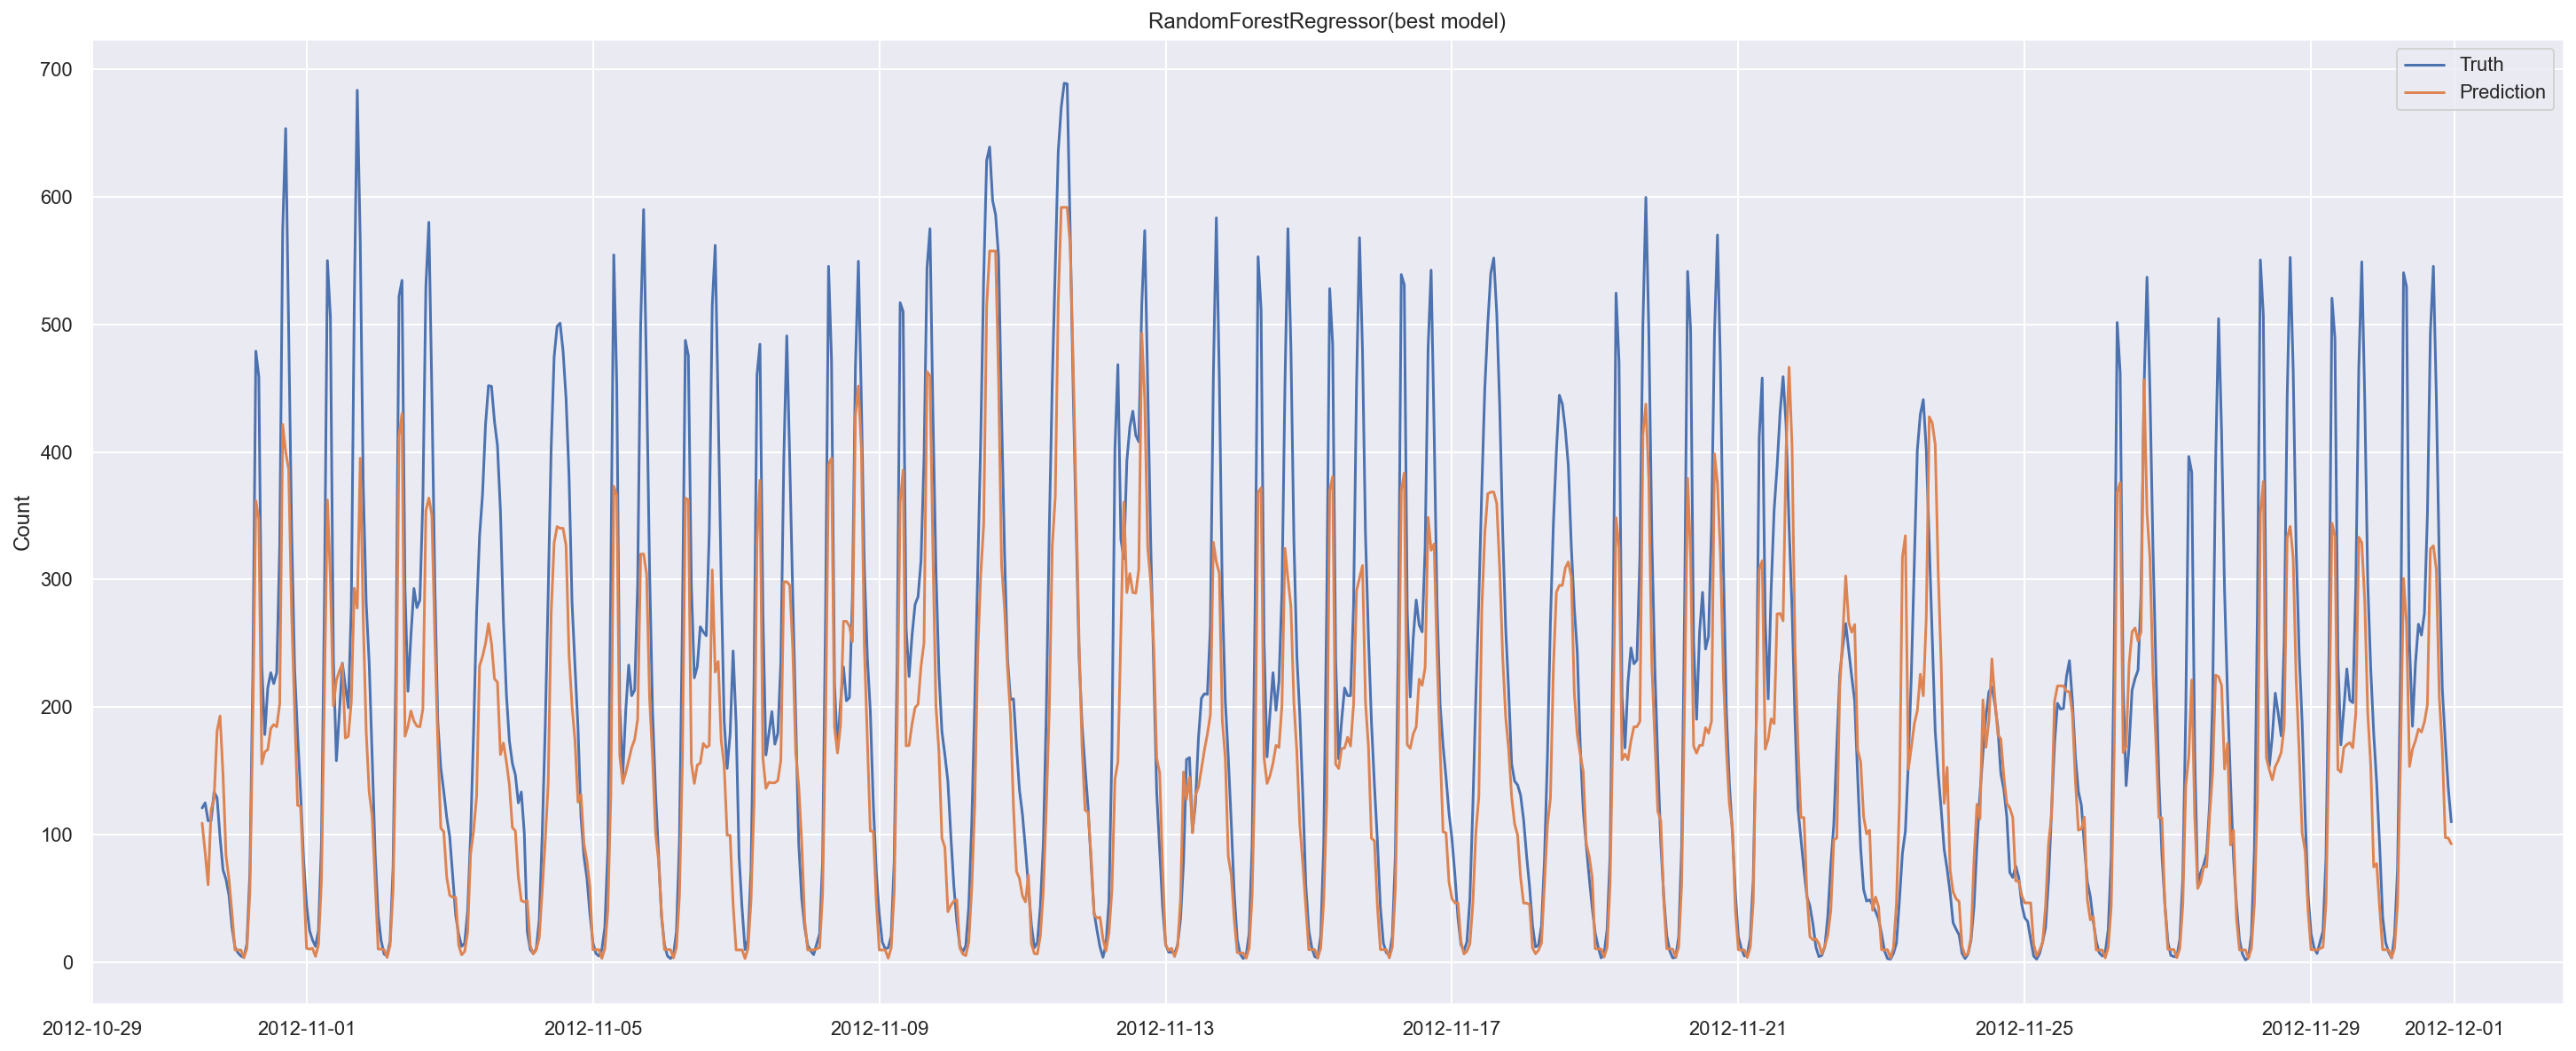

Date
2012-10-30 13:00:00    109.105206
2012-10-30 14:00:00     86.112382
2012-10-30 15:00:00     60.758133
2012-10-30 16:00:00    119.502508
2012-10-30 17:00:00    128.524602
                          ...    
2012-11-30 19:00:00    207.352073
2012-11-30 20:00:00    166.807415
2012-11-30 21:00:00     97.753595
2012-11-30 22:00:00     97.417246
2012-11-30 23:00:00     92.813098
Name: predicted, Length: 753, dtype: float64

In [440]:
# Using last valid period of data (starting from date '2012-10-30'), check prevision results

print("Test score RandomForestRegressor GridSearchCV model", best_model.score(X_test, y_test))
print("Test NEGATIVE MAPE:", -mean_absolute_percentage_error(y_test, best_model.predict(X_test)))
print("Test NEGATIVE MAE:", -mean_absolute_error(y_test, best_model.predict(X_test)))

subset_train_df_ = df_train_transformed['2012-10-30':]
subset_train_df_['predicted'] = best_model.predict(X_test)

# Plot comparison results between predicted and real values
plt.plot(subset_train_df_['cnt'],
         label='Truth')
plt.plot(subset_train_df_['predicted'],
         label='Prediction')
plt.title("RandomForestRegressor(best model)")
plt.ylabel('Count')
plt.legend();
plt.show()

subset_train_df_['predicted']

Test 2 score RandomForestRegressor GridSearchCV model 0.43657541903394526
Test 2 NEGATIVE MAPE: -0.7749359543428579
Test 2 NEGATIVE MAE: -68.04239123150309


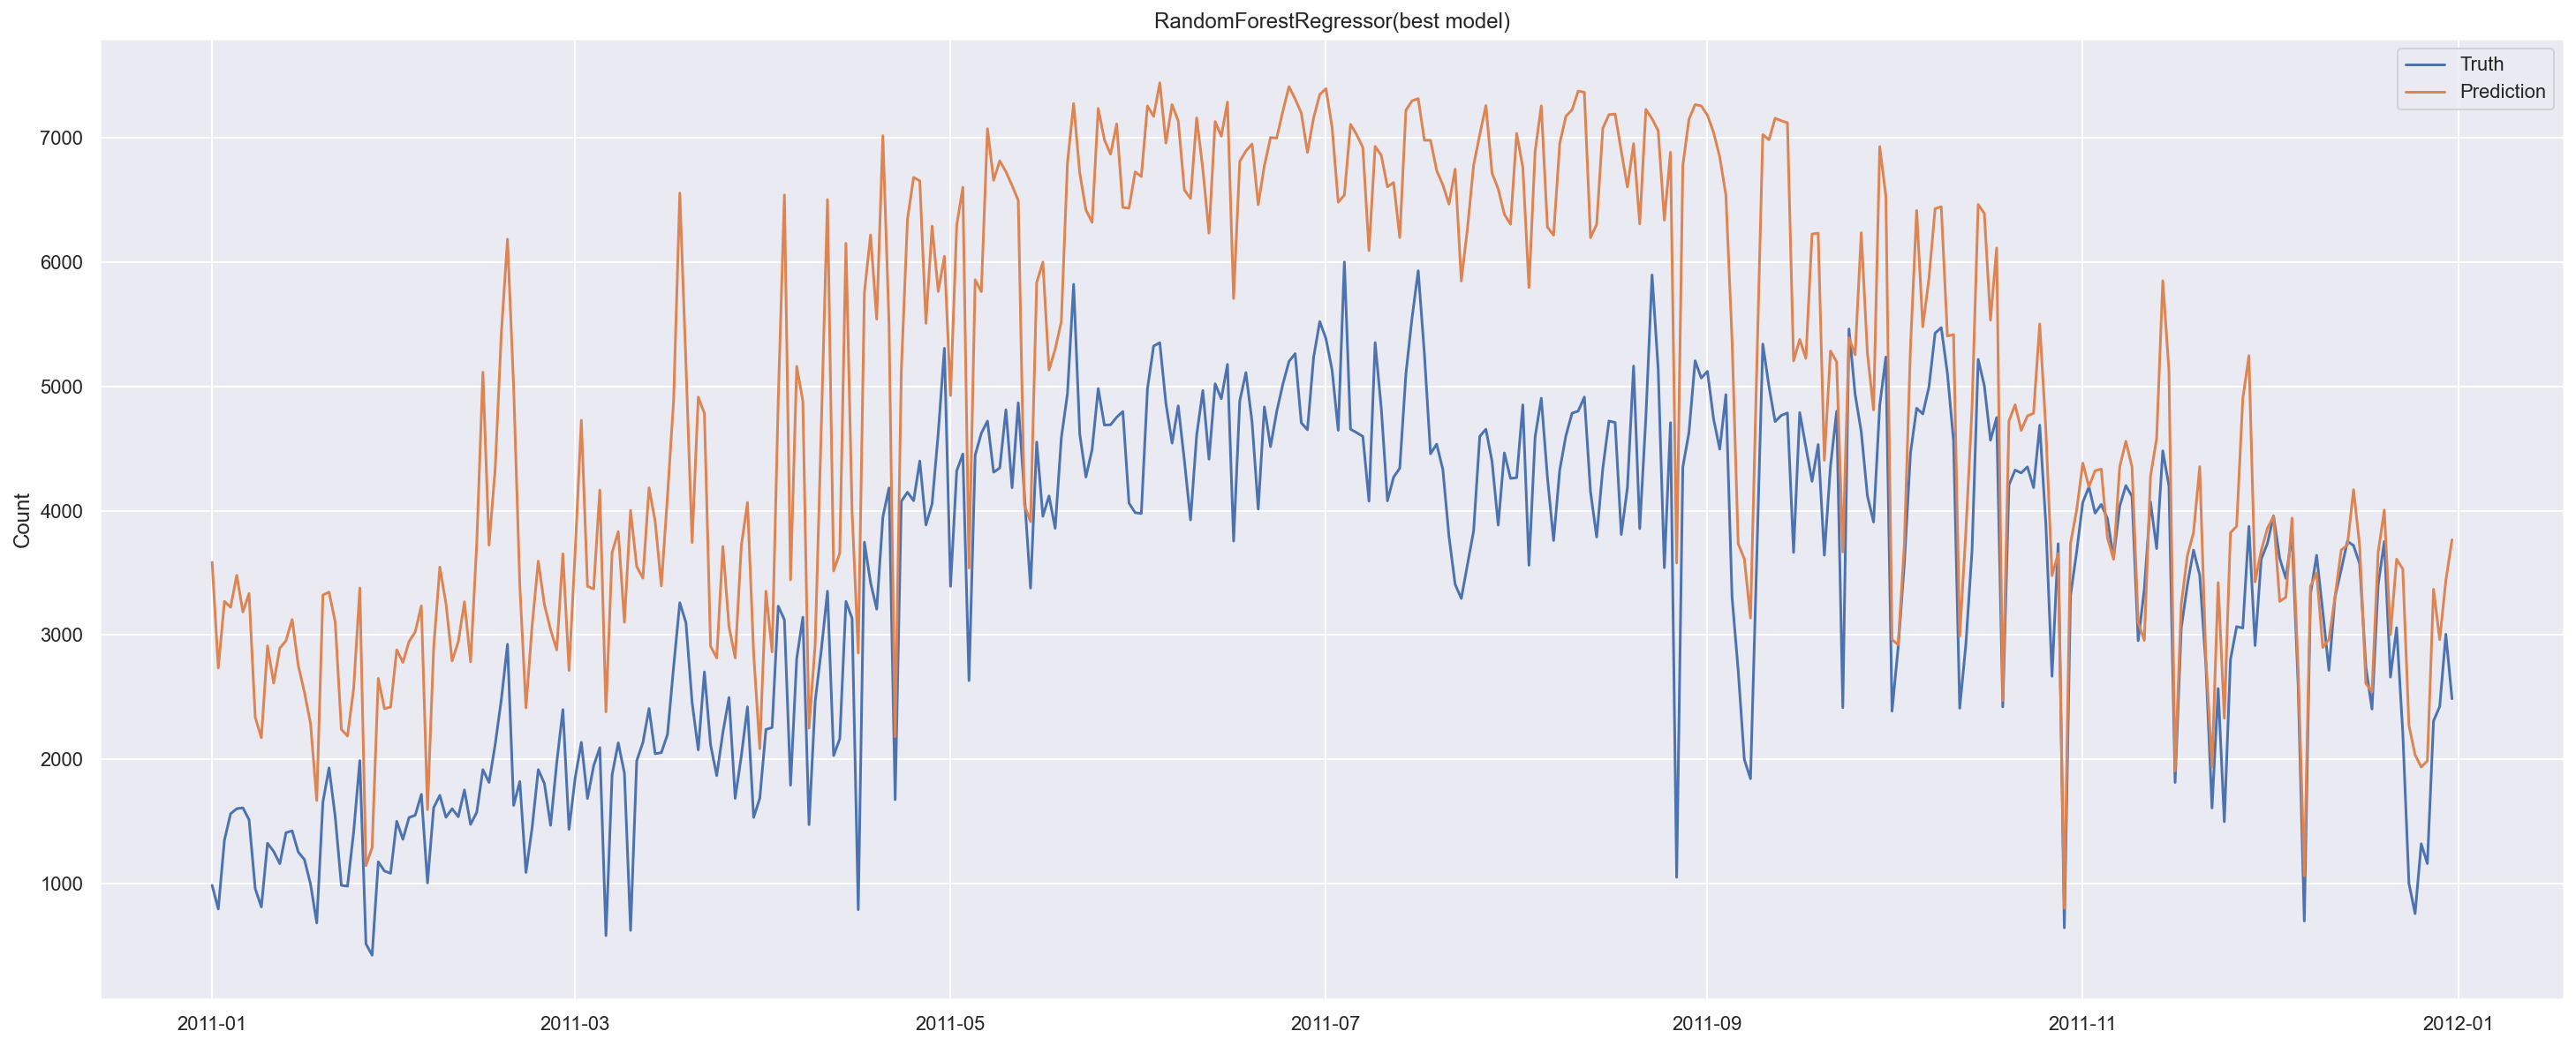

In [441]:
# Using the past year period of data (not fitted and not trained data), check prevision results

print("Test 2 score RandomForestRegressor GridSearchCV model", best_model.score(Z_test, Zy_test))
print("Test 2 NEGATIVE MAPE:", -mean_absolute_percentage_error(Zy_test, best_model.predict(Z_test)))
print("Test 2 NEGATIVE MAE:", -mean_absolute_error(Zy_test, best_model.predict(Z_test)))

subset_train_df_ = df_train_transformed[:'2011-12-31']
subset_train_df_['predicted'] = best_model.predict(Z_test)
# Plot comparison results between predicted and real values
plt.plot(subset_train_df_['cnt'].resample('D').sum(),
         label='Truth')
plt.plot(subset_train_df_['predicted'].resample('D').sum(),
         label='Prediction')
plt.title("RandomForestRegressor(best model)")
plt.ylabel('Count')
plt.legend();
plt.show()

In [442]:
subset_train_df_['predicted']

Date
2011-01-01 00:00:00     40.545129
2011-01-01 01:00:00     35.894473
2011-01-01 02:00:00     41.715369
2011-01-01 03:00:00     13.938841
2011-01-01 04:00:00      5.711291
                          ...    
2011-12-31 19:00:00    135.233472
2011-12-31 20:00:00    166.734105
2011-12-31 21:00:00     76.166784
2011-12-31 22:00:00     48.196296
2011-12-31 23:00:00     78.725116
Name: predicted, Length: 8645, dtype: float64

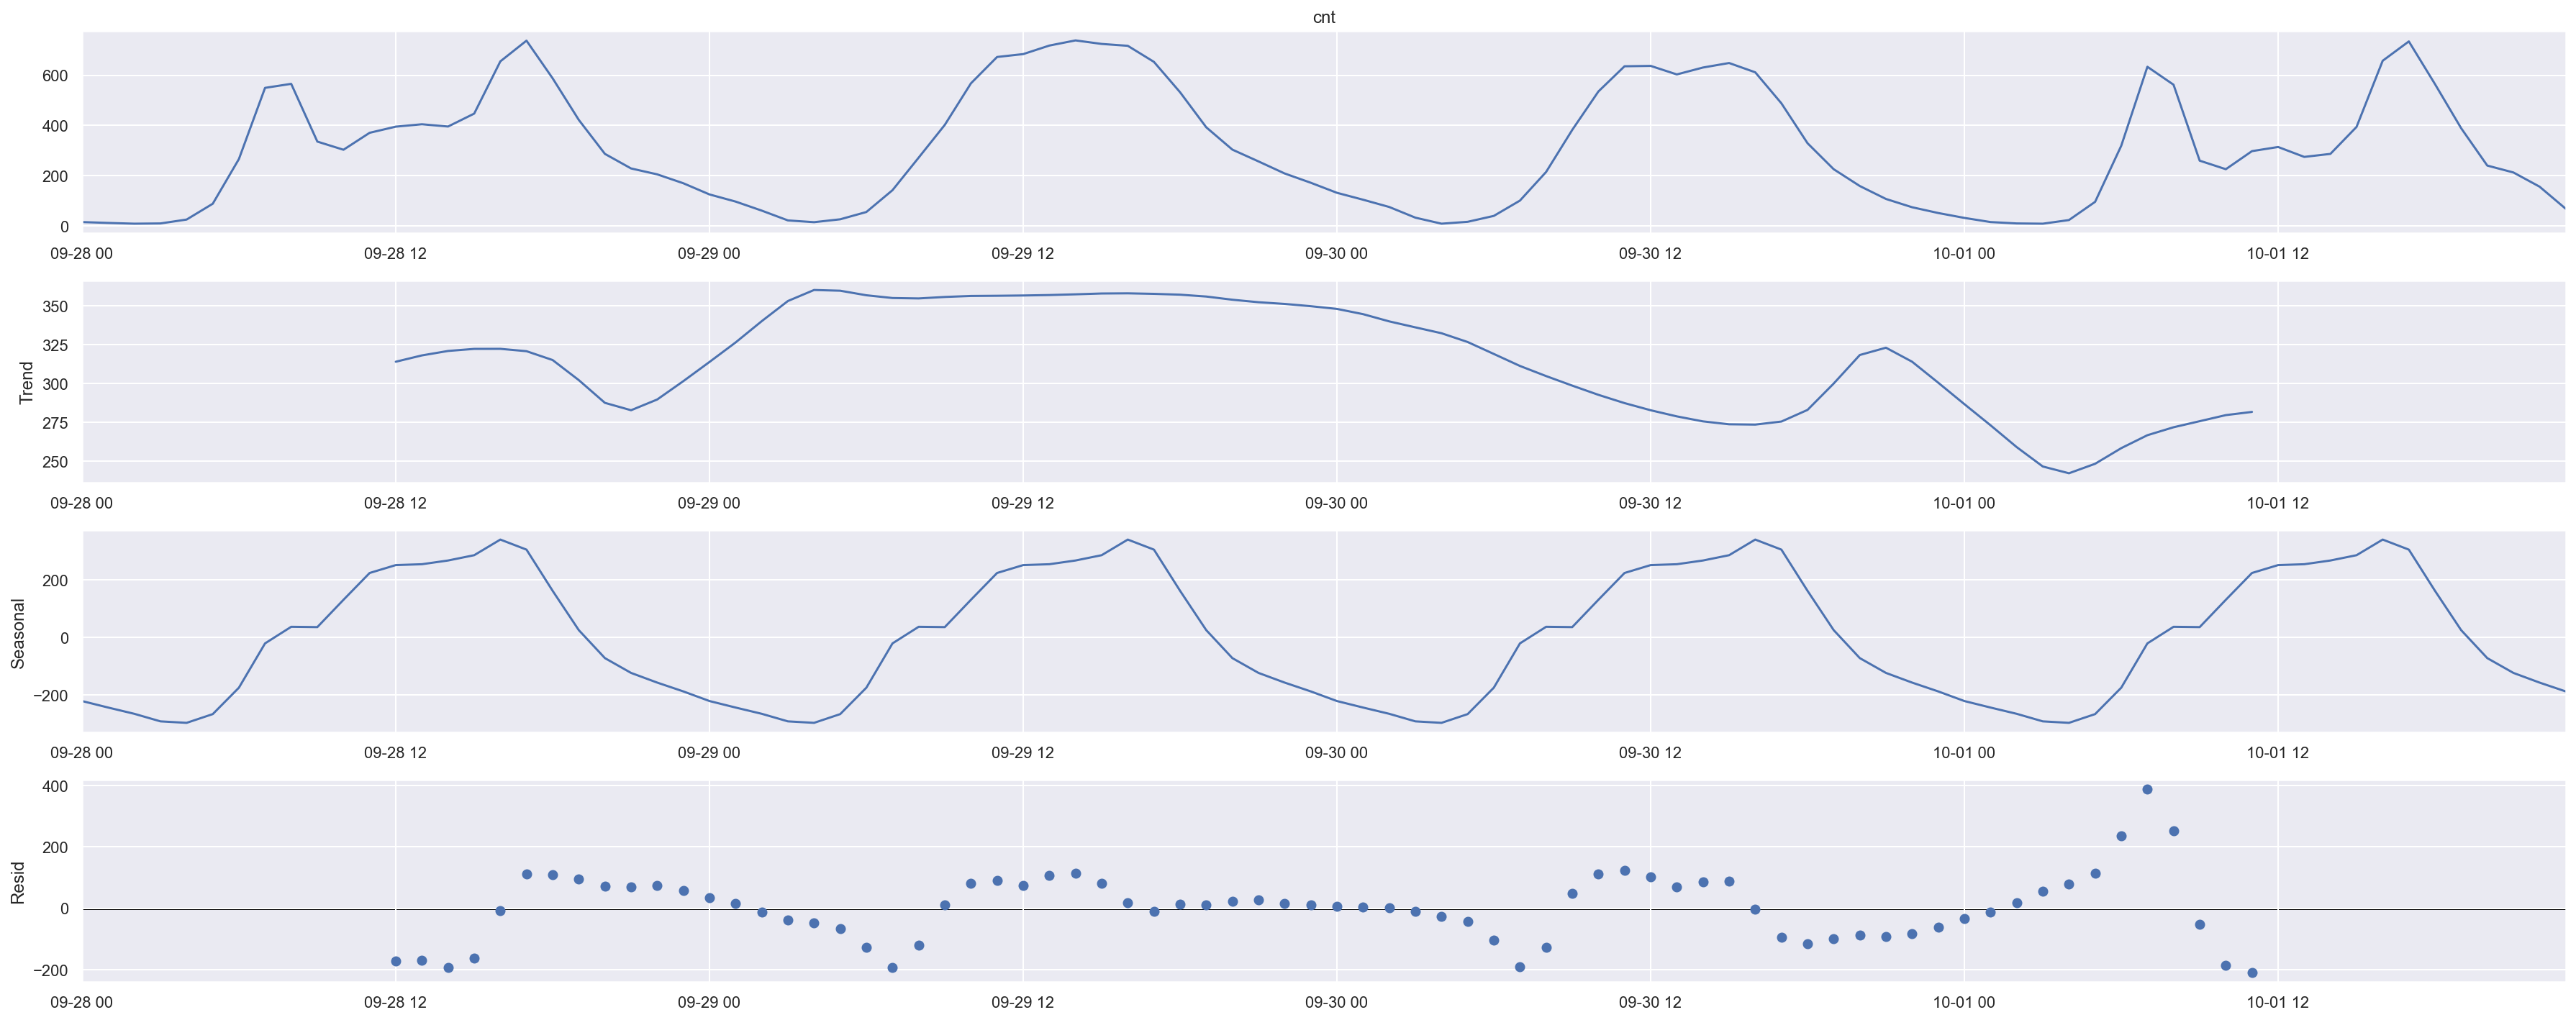

In [443]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(y['2012-09-28 00:00:00':'2012-10-01 23:00:00'], period=24)

# Plot decomposition's components
plot = decomposition.plot()

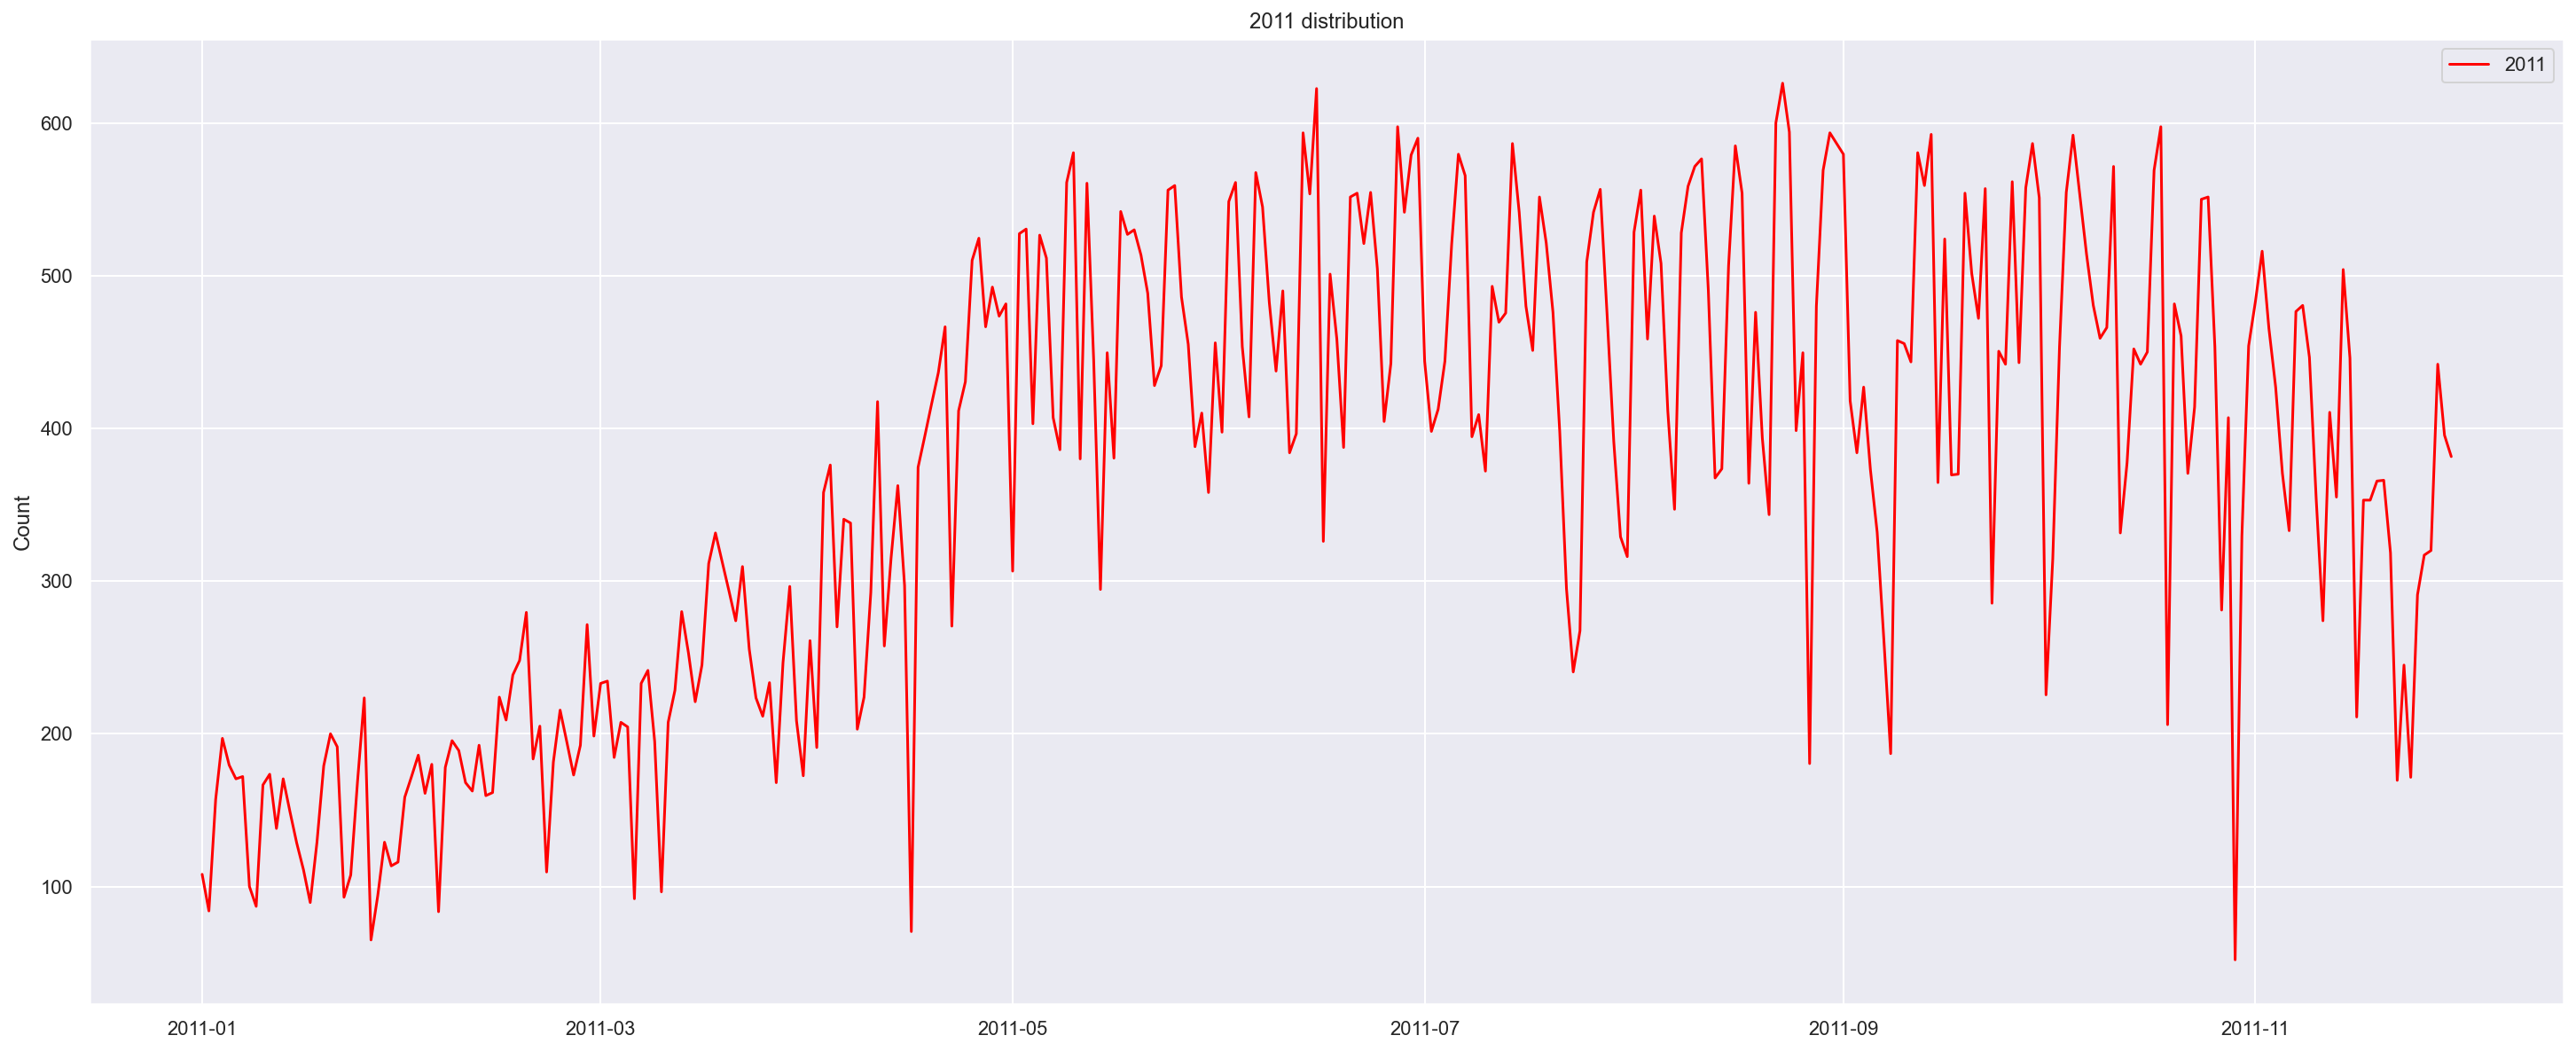

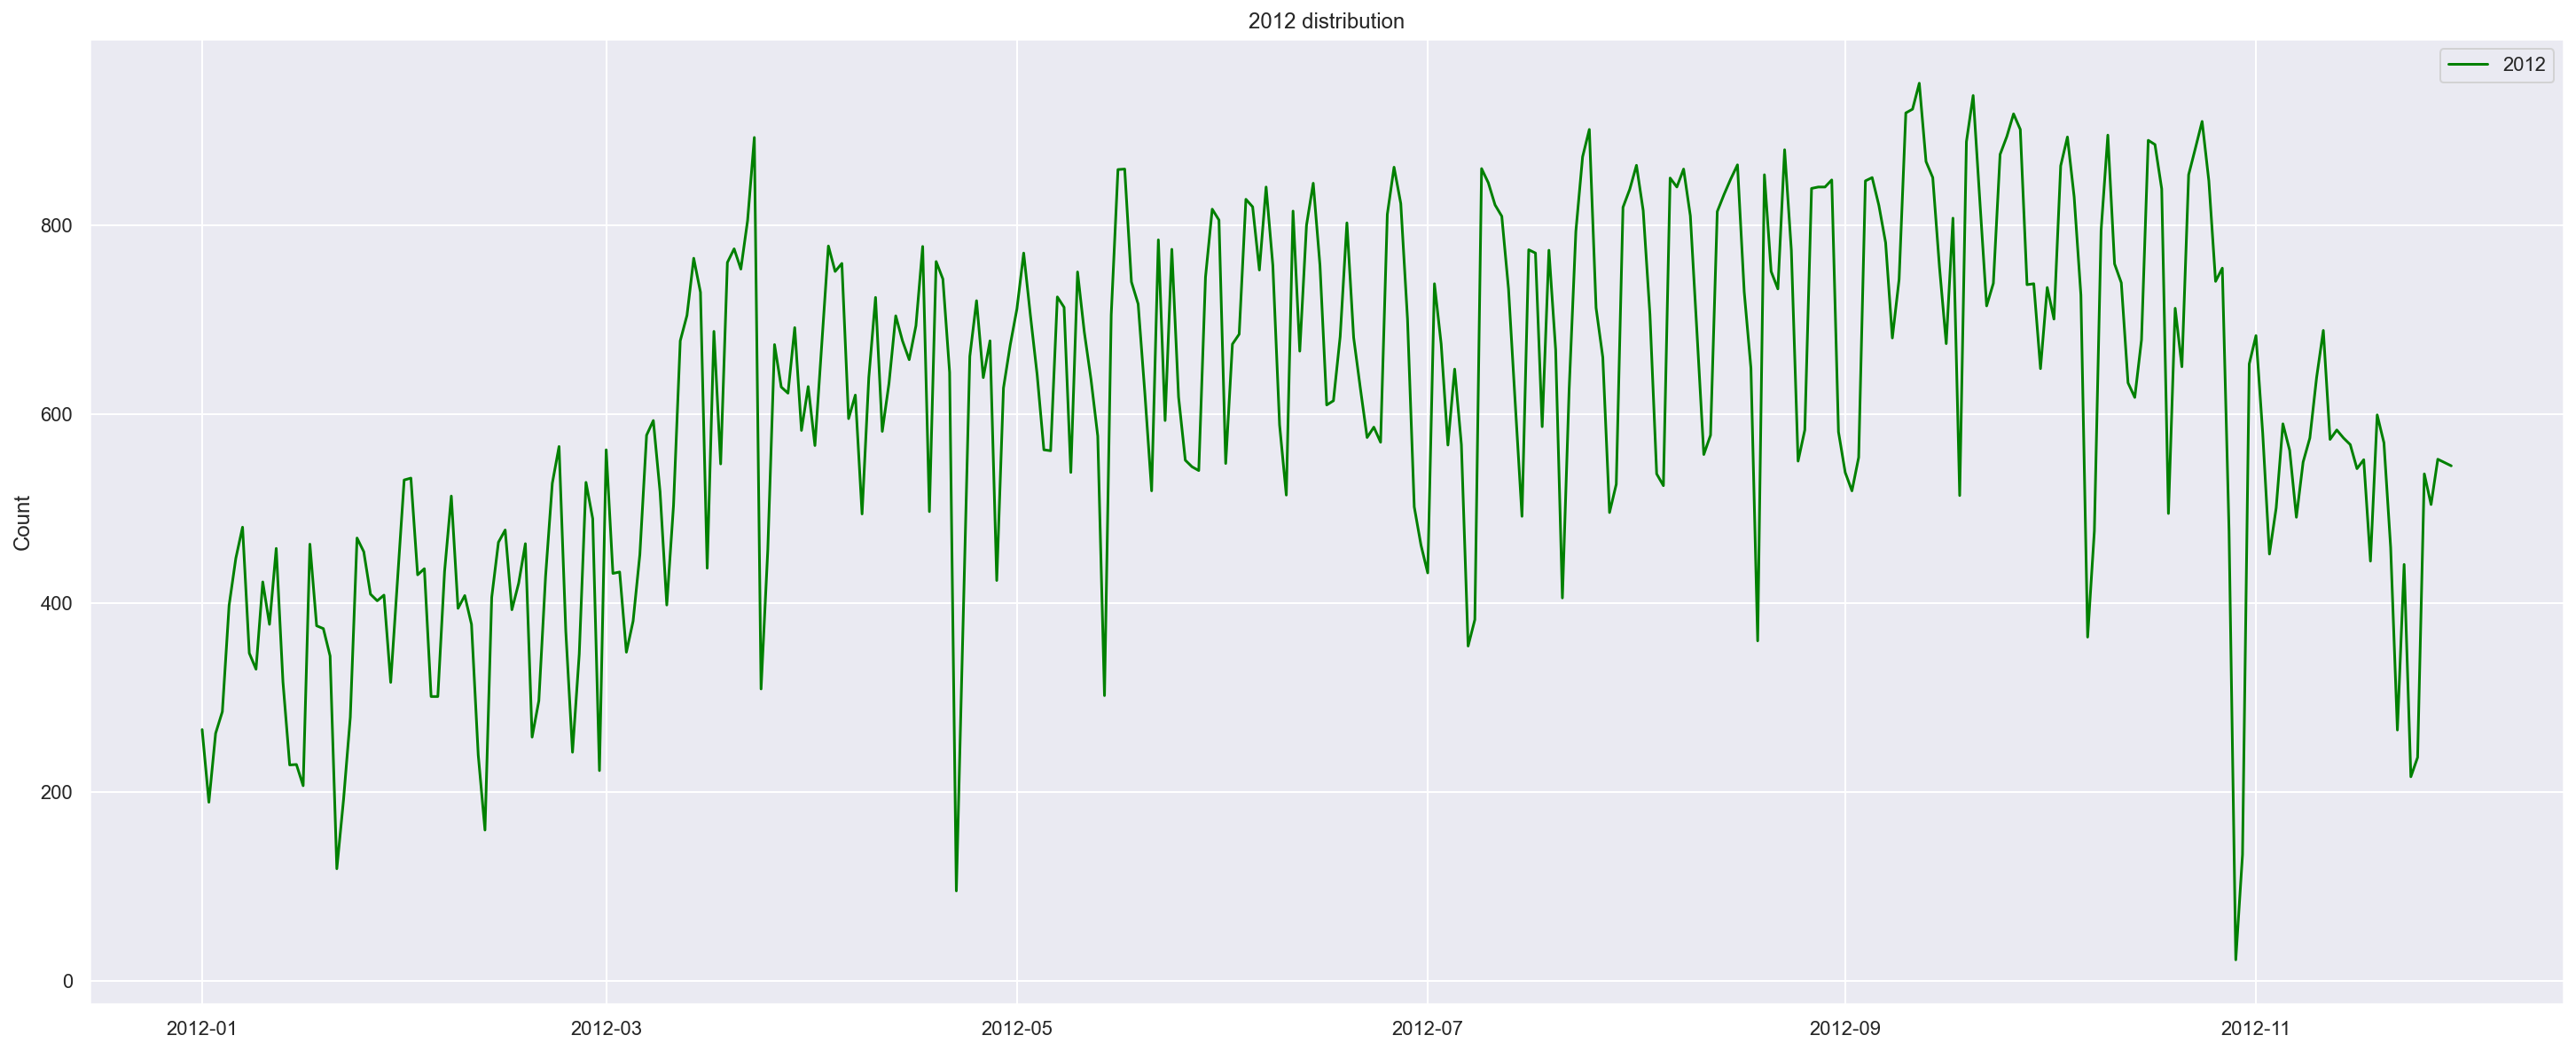

In [444]:
# Compare 2011 VS 2012

subset_train_df_ = y['2011-01':'2011-11']
# Plot comparison results between predicted and real values
plt.plot(subset_train_df_.resample('D').max(),
         label='2011', color='red')
plt.title("2011 distribution")
plt.ylabel('Count')
plt.legend();
plt.show()

subset_train_df_ = y['2012-01':]
# Plot comparison results between predicted and real values
plt.plot(subset_train_df_.resample('D').max(),
         label='2012', color='green')
plt.title("2012 distribution")
plt.ylabel('Count')
plt.legend();
plt.show()

In [445]:
# Dump to export Pipeline

final_pipe = make_pipeline(*transformer_pipe, *best_model)
print(final_pipe)

joblib.dump(final_pipe, 'Lorenzo_Carovillano_model.joblib')

Pipeline(steps=[('hoursmappertransformer',
                 <__main__.hoursMapperTransformer object at 0x0000018B90D9D0D0>),
                ('hourlyindexdatetransformer',
                 <__main__.hourlyIndexDateTransformer object at 0x0000018B90D9D160>),
                ('columndroppertransformer',
                 <__main__.columnDropperTransformer object at 0x0000018B8E1CEEE0>),
                ('hourscategoriestransformer',
                 <__main__.hoursCategoriesTransformer object at 0x0000018B90E3B5B0>),
                ('customminmaxscaler',
                 <__main__.customMinMaxScaler object at 0x0000018B8B5D5C70>),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=11, n_estimators=15))])


['Lorenzo_Carovillano_model.joblib']

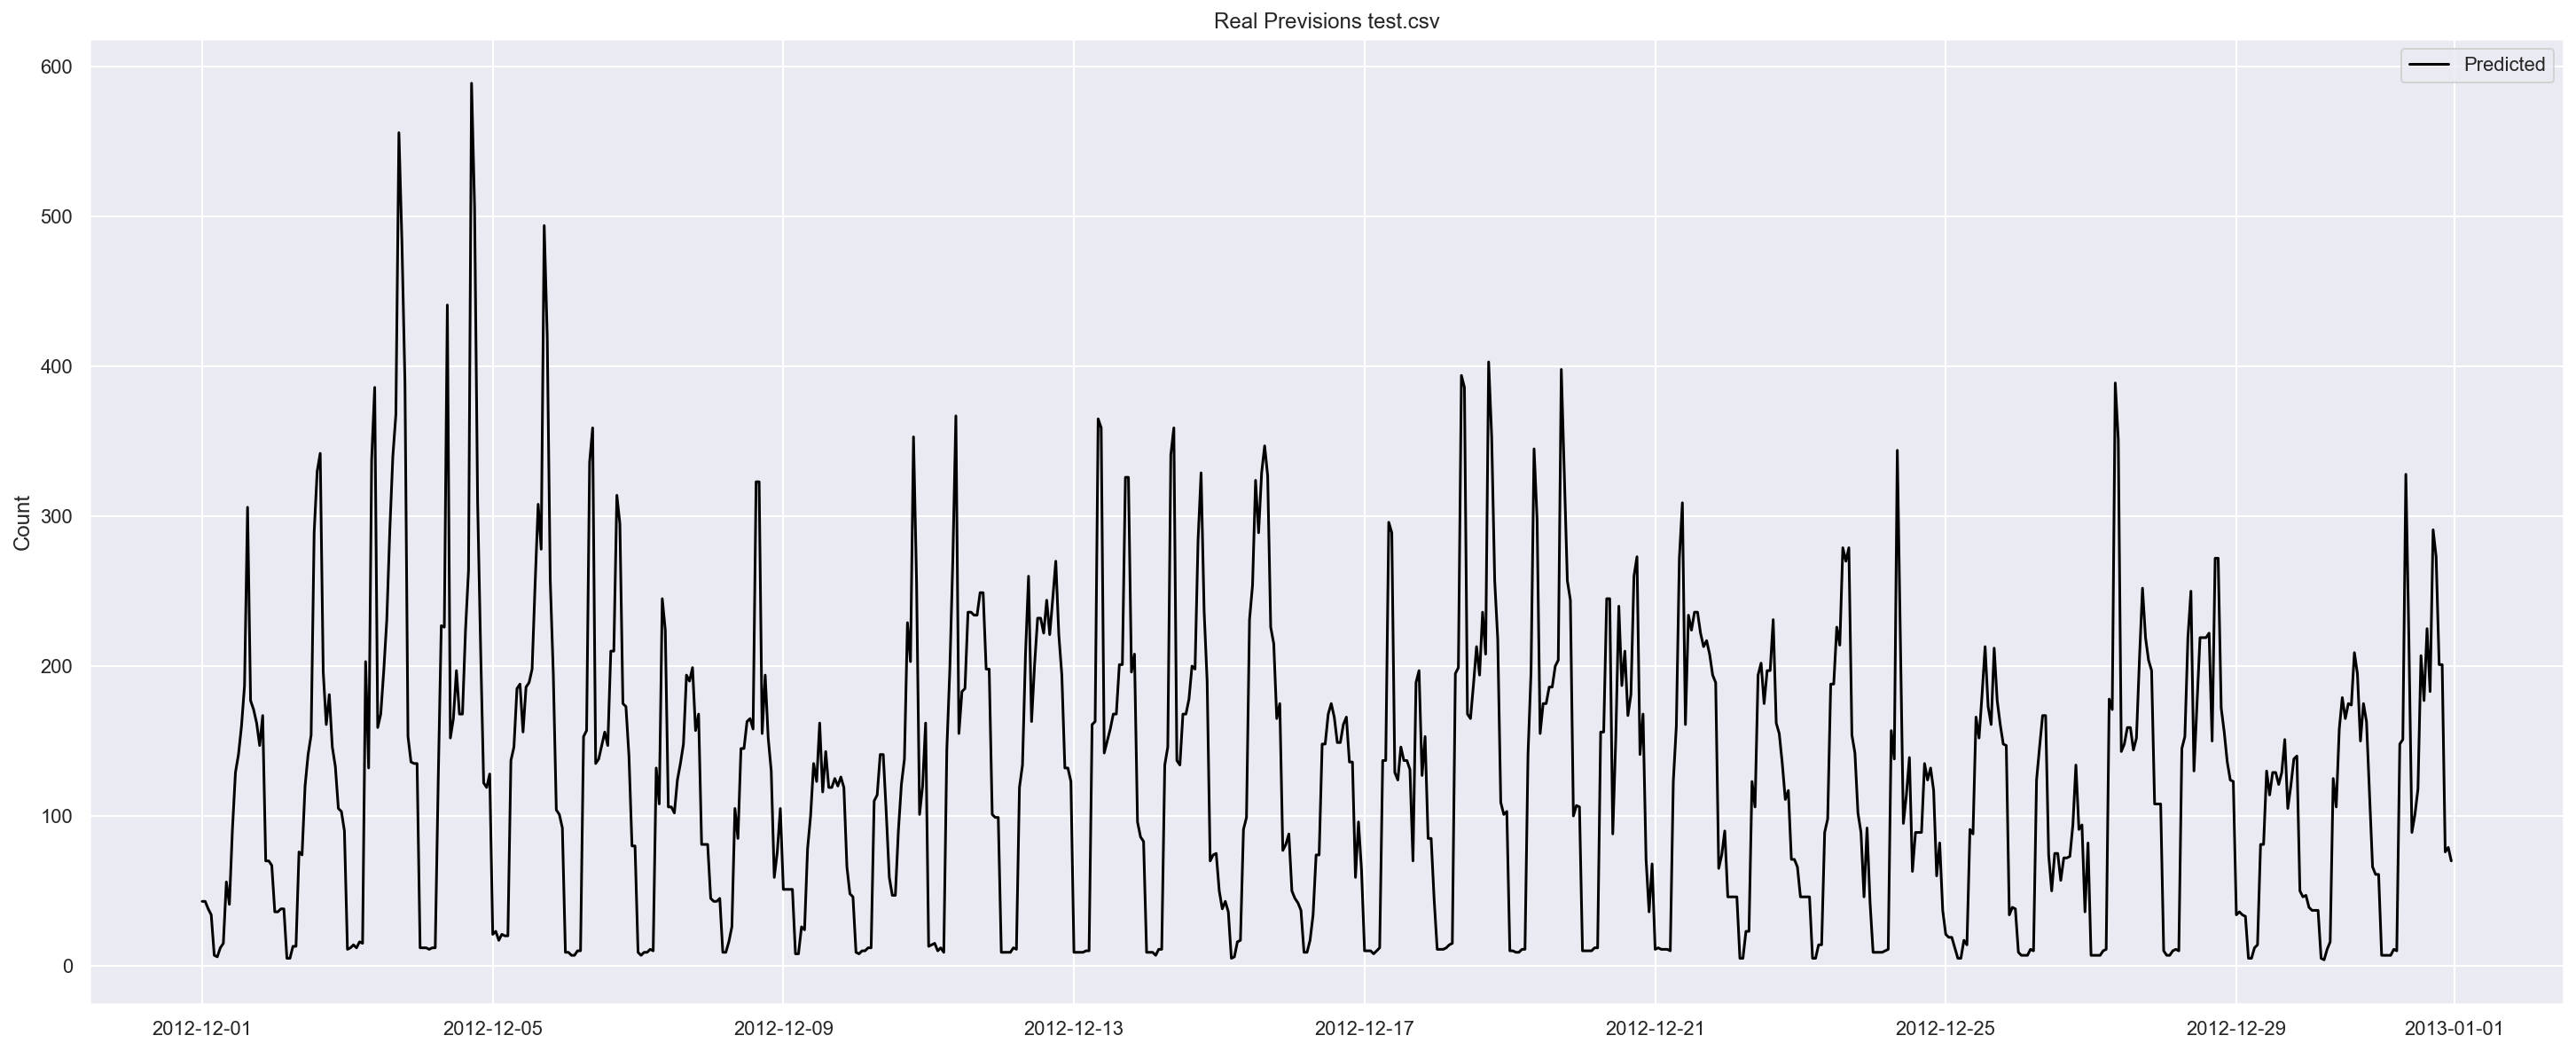

In [446]:
# Load and use Pipeline

df_test = pd.read_csv('data/test.csv')

pipe_load = joblib.load('Lorenzo_Carovillano_model.joblib')

df_test_transformed = pd.DataFrame(transformer_pipe.fit_transform(df_test))
df_test_transformed['count'] = pipe_load.predict(df_test)
df_test_transformed['count'] = df_test_transformed['count'].astype(int)

# Plot comparison results between predicted and real values
plt.plot(df_test_transformed['count'],
         label='Predicted', color='black')
plt.title("Real Previsions test.csv")
plt.ylabel('Count')
plt.legend();
plt.show()

In [447]:
# Submission format csv
df_test_transformed['count']

Date
2012-12-01 00:00:00     43
2012-12-01 01:00:00     43
2012-12-01 02:00:00     38
2012-12-01 03:00:00     34
2012-12-01 04:00:00      7
                      ... 
2012-12-31 19:00:00    201
2012-12-31 20:00:00    201
2012-12-31 21:00:00     76
2012-12-31 22:00:00     79
2012-12-31 23:00:00     70
Name: count, Length: 742, dtype: int32

In [448]:
# Previsions on new data

df = pd.DataFrame()
dates = []
hours = []
counts = []

for row in df_test_transformed.itertuples():
    #print(row)
    dates.append(row.Index.date())
    hours.append(row.Index.hour)
    counts.append(row.count)

df['date'] = dates
df['hours'] = hours
df['counts'] = counts
display(df)

# Export submission

df.to_csv('Submission.csv', index=False)

date  hours  counts
0    2012-12-01      0      43
1    2012-12-01      1      43
2    2012-12-01      2      38
3    2012-12-01      3      34
4    2012-12-01      4       7
..          ...    ...     ...
737  2012-12-31     19     201
738  2012-12-31     20     201
739  2012-12-31     21      76
740  2012-12-31     22      79
741  2012-12-31     23      70

[742 rows x 3 columns]

_______________________

_______________________

## EDA and test various models

In [332]:
# format the same things done for train ( see next block in notebook )

df_test = pd.read_csv('data/test.csv')
df_test.hr.map({0: '00', 1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '06', 7: '07', 8: '08', 9: '09'})
df_test.loc[:,'Date'] = pd.to_datetime(df_test.dteday.astype(str)+' '+df_test.hr.astype(str)+":00:00")
df_test = df_test.drop(['dteday', 'hr'], axis=1)
df_test = df_test.set_index('Date')
df_test = df_test.drop(['instant', 'yr', 'mnth', 'season', 'atemp'], axis=1)

display(df_test)
display(df_test.info())

holiday  weekday  workingday  weathersit  temp   hum  \
Date                                                                        
2012-12-01 00:00:00        0        6           0           1  0.26  0.81   
2012-12-01 01:00:00        0        6           0           1  0.26  0.81   
2012-12-01 02:00:00        0        6           0           2  0.26  0.81   
2012-12-01 03:00:00        0        6           0           2  0.26  0.81   
2012-12-01 04:00:00        0        6           0           1  0.26  0.81   
...                      ...      ...         ...         ...   ...   ...   
2012-12-31 19:00:00        0        1           1           2  0.26  0.60   
2012-12-31 20:00:00        0        1           1           2  0.26  0.60   
2012-12-31 21:00:00        0        1           1           1  0.26  0.60   
2012-12-31 22:00:00        0        1           1           1  0.26  0.56   
2012-12-31 23:00:00        0        1           1           1  0.26  0.65   

                     windspeed  
Date                            
2012-12-01 00:00:00     0.0000  
2012-12-01 01:00:00     0.0000  
2012-12-01 02:00:00     0.0000  
2012-12-01 03:00:00     0.1343  
2012-12-01 04:00:00     0.0896  
...                        ...  
2012-12-31 19:00:00     0.1642  
2012-12-31 20:00:00     0.1642  
2012-12-31 21:00:00     0.1642  
2012-12-31 22:00:00     0.1343  
2012-12-31 23:00:00     0.1343  

[742 rows x 7 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 742 entries, 2012-12-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     742 non-null    int64  
 1   weekday     742 non-null    int64  
 2   workingday  742 non-null    int64  
 3   weathersit  742 non-null    int64  
 4   temp        742 non-null    float64
 5   hum         742 non-null    float64
 6   windspeed   742 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 46.4 KB


None

In [333]:
# Read train data
df_train = pd.read_csv('data/train.csv')

In [334]:
# map hours in the correct format to create date index
df_train.hr.map({0: '00', 1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '06', 7: '07', 8: '08', 9: '09'})
# create Date feature with date and time
df_train.loc[:,'Date'] = pd.to_datetime(df_train.dteday.astype(str)+' '+df_train.hr.astype(str)+":00:00")
# drop previous time features
df_train = df_train.drop(['dteday', 'hr'], axis=1)
df_train = df_train.set_index('Date')

In [335]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     16637 non-null  int64  
 1   season      16637 non-null  int64  
 2   yr          16637 non-null  int64  
 3   mnth        16637 non-null  int64  
 4   holiday     16637 non-null  int64  
 5   weekday     16637 non-null  int64  
 6   workingday  16637 non-null  int64  
 7   weathersit  16637 non-null  int64  
 8   temp        16637 non-null  float64
 9   atemp       16637 non-null  float64
 10  hum         16637 non-null  float64
 11  windspeed   16637 non-null  float64
 12  casual      16637 non-null  int64  
 13  registered  16637 non-null  int64  
 14  cnt         16637 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 2.0 MB


In [336]:
# drop unuseful features

df_train = df_train.drop(['instant', 'yr', 'mnth', 'season'], axis=1) # these features are inside the index date
df_train = df_train.drop(['casual', 'registered'], axis=1) # check if do it, they can be used for model train (not included in test data)
df_train

holiday  weekday  workingday  weathersit  temp   atemp  \
Date                                                                          
2011-01-01 00:00:00        0        6           0           1  0.24  0.2879   
2011-01-01 01:00:00        0        6           0           1  0.22  0.2727   
2011-01-01 02:00:00        0        6           0           1  0.22  0.2727   
2011-01-01 03:00:00        0        6           0           1  0.24  0.2879   
2011-01-01 04:00:00        0        6           0           1  0.24  0.2879   
...                      ...      ...         ...         ...   ...     ...   
2012-11-30 19:00:00        0        5           1           1  0.32  0.3485   
2012-11-30 20:00:00        0        5           1           1  0.32  0.3485   
2012-11-30 21:00:00        0        5           1           1  0.30  0.3182   
2012-11-30 22:00:00        0        5           1           1  0.30  0.3333   
2012-11-30 23:00:00        0        5           1           2  0.30  0.3182   

                      hum  windspeed  cnt  
Date                                       
2011-01-01 00:00:00  0.81     0.0000   16  
2011-01-01 01:00:00  0.80     0.0000   40  
2011-01-01 02:00:00  0.80     0.0000   32  
2011-01-01 03:00:00  0.75     0.0000   13  
2011-01-01 04:00:00  0.75     0.0000    1  
...                   ...        ...  ...  
2012-11-30 19:00:00  0.66     0.0000  377  
2012-11-30 20:00:00  0.66     0.0000  245  
2012-11-30 21:00:00  0.75     0.0896  183  
2012-11-30 22:00:00  0.75     0.0000  163  
2012-11-30 23:00:00  0.75     0.0896  110  

[16637 rows x 9 columns]

<AxesSubplot:>

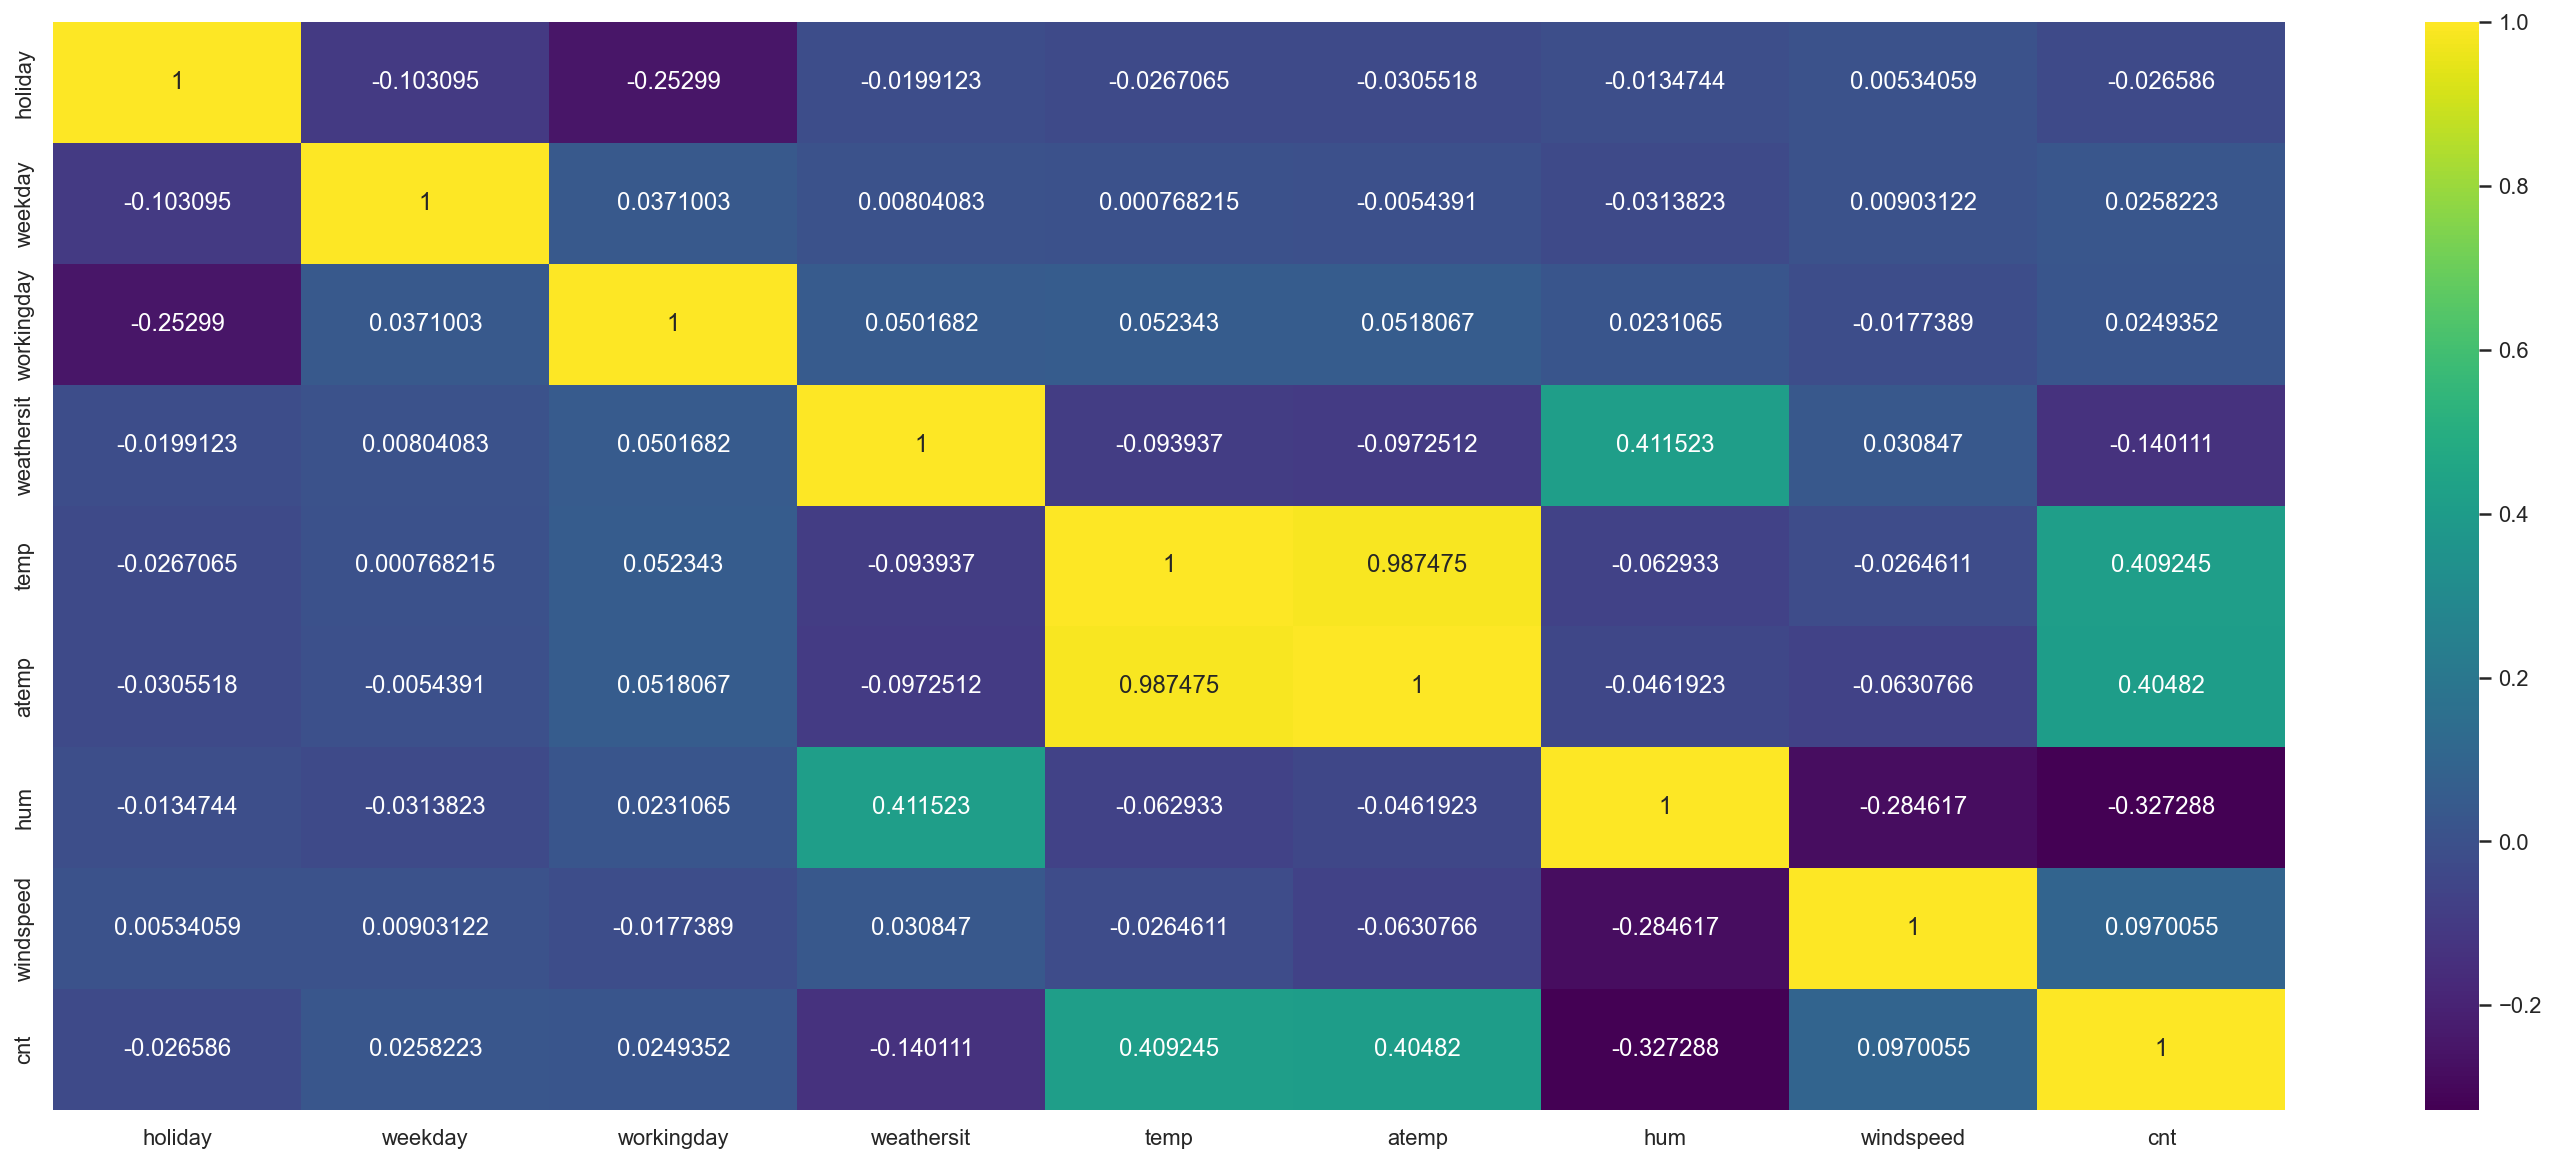

In [337]:
# correlation check
sns.heatmap(df_train.corr(), annot=True, fmt='g', cmap='viridis')

In [338]:
df_train = df_train.drop(['atemp'], axis=1) # drop atemp keep atemp
df_train['windspeed'] = (df_train['windspeed'] * 100).astype(int) / 100 # cut 2 decimals points
df_train

holiday  weekday  workingday  weathersit  temp   hum  \
Date                                                                        
2011-01-01 00:00:00        0        6           0           1  0.24  0.81   
2011-01-01 01:00:00        0        6           0           1  0.22  0.80   
2011-01-01 02:00:00        0        6           0           1  0.22  0.80   
2011-01-01 03:00:00        0        6           0           1  0.24  0.75   
2011-01-01 04:00:00        0        6           0           1  0.24  0.75   
...                      ...      ...         ...         ...   ...   ...   
2012-11-30 19:00:00        0        5           1           1  0.32  0.66   
2012-11-30 20:00:00        0        5           1           1  0.32  0.66   
2012-11-30 21:00:00        0        5           1           1  0.30  0.75   
2012-11-30 22:00:00        0        5           1           1  0.30  0.75   
2012-11-30 23:00:00        0        5           1           2  0.30  0.75   

                     windspeed  cnt  
Date                                 
2011-01-01 00:00:00       0.00   16  
2011-01-01 01:00:00       0.00   40  
2011-01-01 02:00:00       0.00   32  
2011-01-01 03:00:00       0.00   13  
2011-01-01 04:00:00       0.00    1  
...                        ...  ...  
2012-11-30 19:00:00       0.00  377  
2012-11-30 20:00:00       0.00  245  
2012-11-30 21:00:00       0.08  183  
2012-11-30 22:00:00       0.00  163  
2012-11-30 23:00:00       0.08  110  

[16637 rows x 8 columns]

In [339]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     16637 non-null  int64  
 1   weekday     16637 non-null  int64  
 2   workingday  16637 non-null  int64  
 3   weathersit  16637 non-null  int64  
 4   temp        16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.1 MB


In [340]:
# train and test split

X = df_train.drop('cnt', axis=1)
y = df_train.cnt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [341]:
# try RandomForestRegressor model

model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)
print("Train score RandomForestRegressor BASE model", model.score(X_train, y_train))
print("Train NEGATIVE MAPE:", -mean_absolute_percentage_error(y_train, model.predict(X_train)))
print("Train NEGATIVE MAE:", -mean_absolute_error(y_train, model.predict(X_train)))

Train score RandomForestRegressor BASE model 0.8183496698031468
Train NEGATIVE MAPE: -1.711185986923512
Train NEGATIVE MAE: -50.91140516209398


In [342]:
# Check performances on test data

print("Test score RandomForestRegressor BASE model", model.score(X_test, y_test))
print("Test NEGATIVE MAPE:", -mean_absolute_percentage_error(y_test, model.predict(X_test)))
print("Test NEGATIVE MAE:", -mean_absolute_error(y_test, model.predict(X_test)))

Test score RandomForestRegressor BASE model 0.19939355111921298
Test NEGATIVE MAPE: -4.343215697371993
Test NEGATIVE MAE: -116.76318275582925


In [343]:
# This cell may take some time to be executed

model = RandomForestRegressor()
param_search = { 
    'n_estimators': [5, 10, 15, 20],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [i for i in range(5,25)]
}
neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = neg_mape)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print(best_model)
print("Train score RandomForestRegressor GridSearchCV model", best_model.score(X_train, y_train))
print("Train NEGATIVE MAPE:", best_score)
print("Train NEGATIVE MAE:", -mean_absolute_error(y_train, best_model.predict(X_train)))

RandomForestRegressor(max_depth=24, max_features='sqrt', n_estimators=15)
Train score RandomForestRegressor GridSearchCV model 0.830301796865264
Train NEGATIVE MAPE: -4.206383840476262
Train NEGATIVE MAE: -49.42836020289698


Test score RandomForestRegressor best model 0.26245447212265693
Test NEGATIVE MAPE: -4.195138517557865
Test NEGATIVE MAE: -112.12590737782294


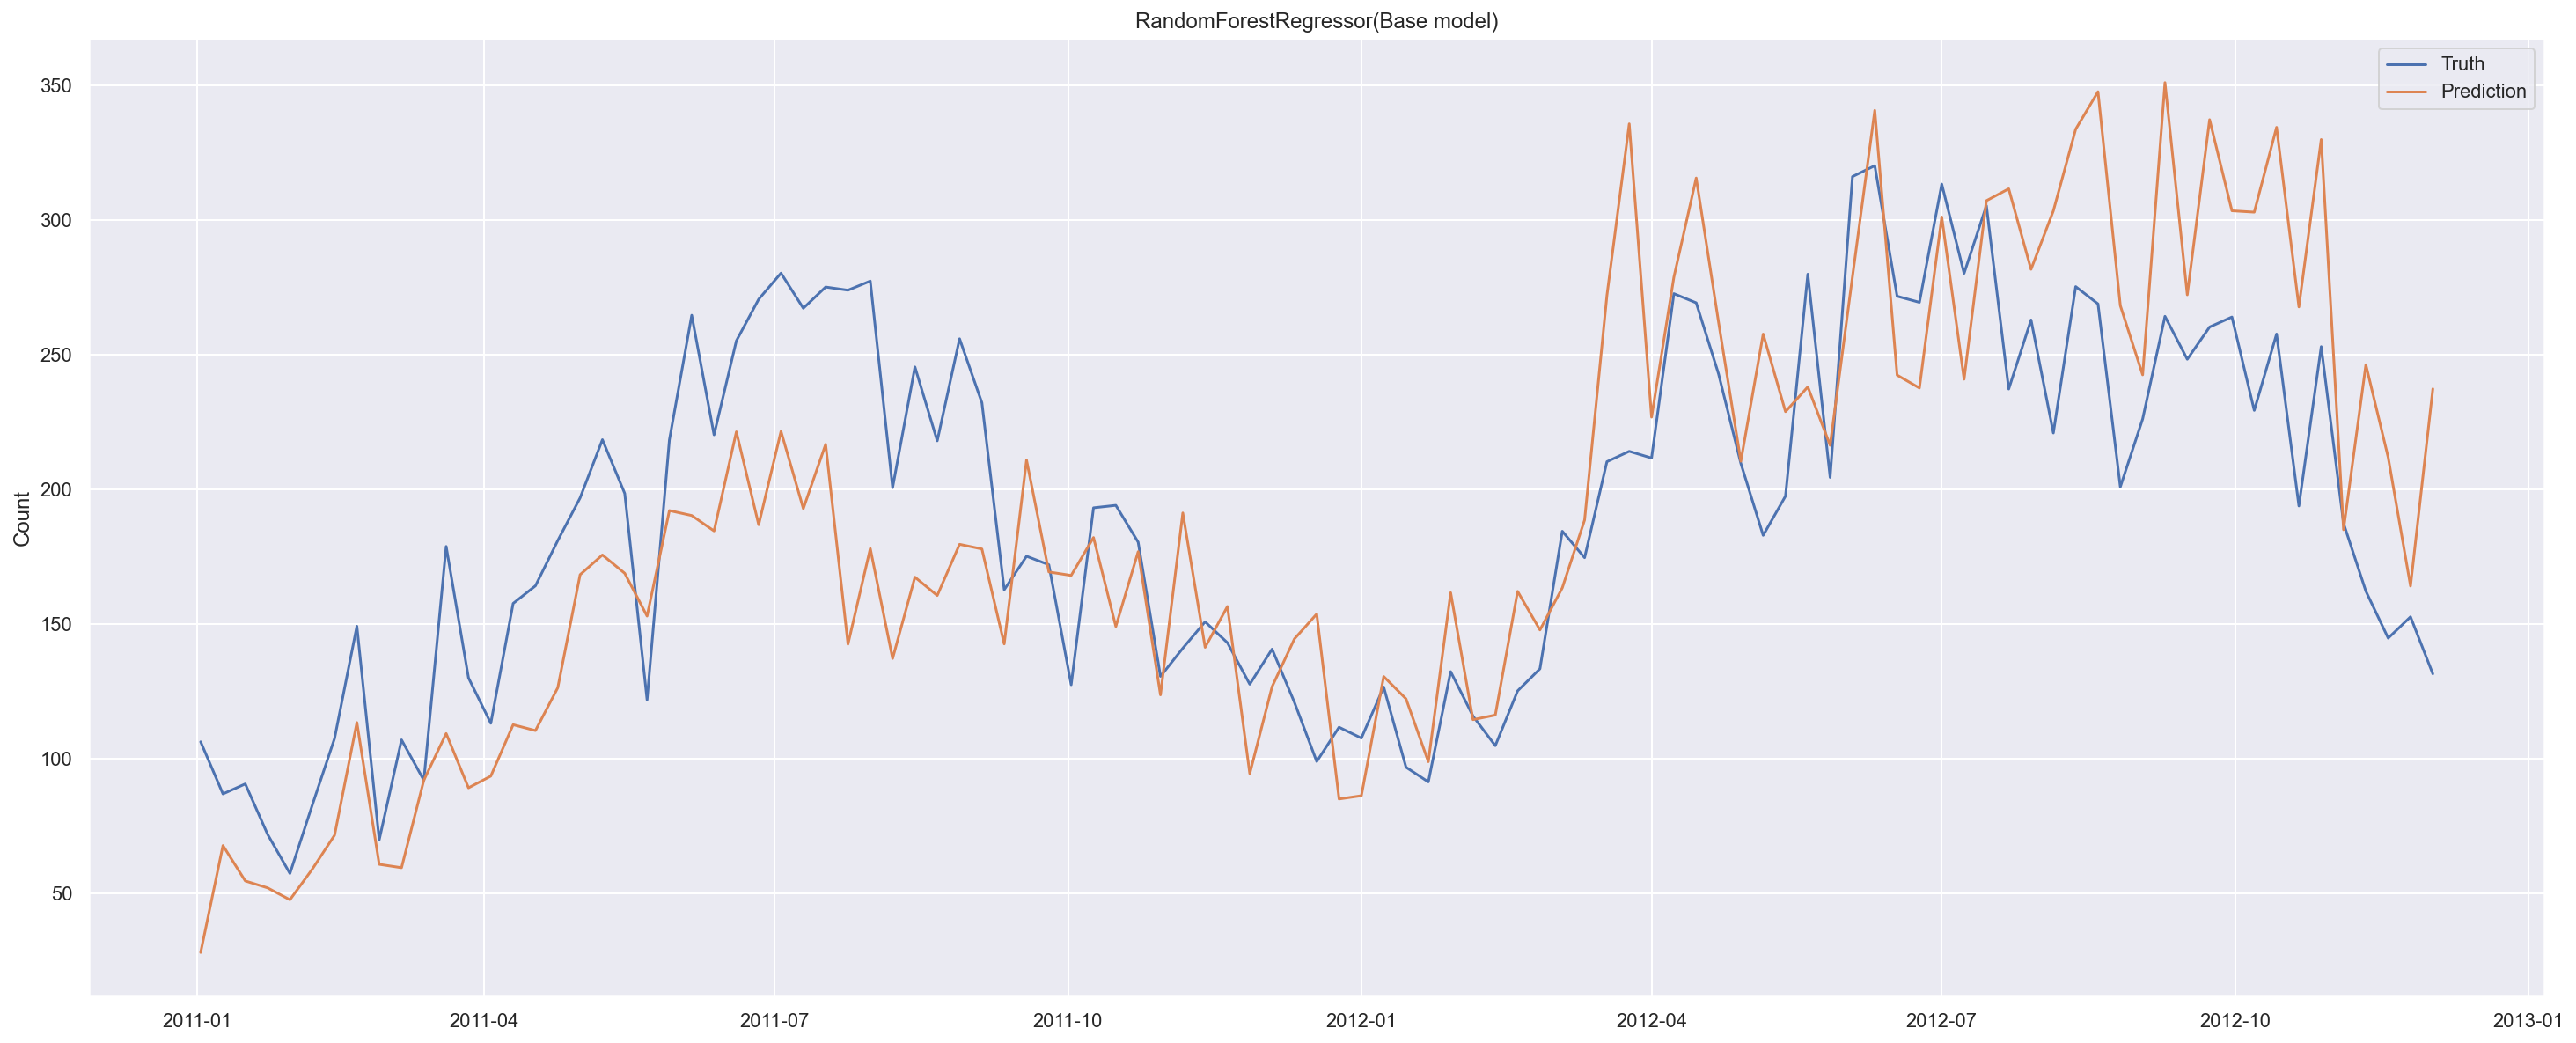

In [344]:
# Check performances on test data 

print("Test score RandomForestRegressor best model", best_model.score(X_test, y_test))
print("Test NEGATIVE MAPE:", -mean_absolute_percentage_error(y_test, best_model.predict(X_test)))
print("Test NEGATIVE MAE:", -mean_absolute_error(y_test, best_model.predict(X_test)))

X_test['predicted'] = best_model.predict(X_test)

# Plot comparison results between predicted and real values
plt.plot(X_test['predicted'].resample('W').mean(),
         label='Truth')
plt.plot(y_test.resample('W').mean(),
         label='Prediction')
plt.title("RandomForestRegressor(Base model)")
plt.ylabel('Count')
plt.legend();
plt.show()

In [345]:
# First Example of the submission data (new dataframe containing index date + count)

df_test['count'] = best_model.predict(df_test.values).astype(int)
df_test

holiday  weekday  workingday  weathersit  temp   hum  \
Date                                                                        
2012-12-01 00:00:00        0        6           0           1  0.26  0.81   
2012-12-01 01:00:00        0        6           0           1  0.26  0.81   
2012-12-01 02:00:00        0        6           0           2  0.26  0.81   
2012-12-01 03:00:00        0        6           0           2  0.26  0.81   
2012-12-01 04:00:00        0        6           0           1  0.26  0.81   
...                      ...      ...         ...         ...   ...   ...   
2012-12-31 19:00:00        0        1           1           2  0.26  0.60   
2012-12-31 20:00:00        0        1           1           2  0.26  0.60   
2012-12-31 21:00:00        0        1           1           1  0.26  0.60   
2012-12-31 22:00:00        0        1           1           1  0.26  0.56   
2012-12-31 23:00:00        0        1           1           1  0.26  0.65   

                     windspeed  count  
Date                                   
2012-12-01 00:00:00     0.0000     21  
2012-12-01 01:00:00     0.0000     21  
2012-12-01 02:00:00     0.0000     97  
2012-12-01 03:00:00     0.1343     94  
2012-12-01 04:00:00     0.0896     29  
...                        ...    ...  
2012-12-31 19:00:00     0.1642    123  
2012-12-31 20:00:00     0.1642    123  
2012-12-31 21:00:00     0.1642     65  
2012-12-31 22:00:00     0.1343     51  
2012-12-31 23:00:00     0.1343     13  

[742 rows x 8 columns]

In [346]:
# make Base pipeline + try scaling features

import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = df_train.drop('cnt', axis=1)
y = df_train.cnt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = Pipeline([
                ('scaler', StandardScaler()), 
                ('model', RandomForestRegressor(n_estimators=10))
                ])

pipe.fit(X_train, y_train)
print("Train score RandomForestRegressor Pipeline", pipe.score(X_train, y_train))
print('Train NEGATIVE MAPE:', -mean_absolute_percentage_error(y_train, pipe.predict(X_train)))
print('Train NEGATIVE MAE:', -mean_absolute_error(y_train, pipe.predict(X_train)))

Train score RandomForestRegressor Pipeline 0.8156504028812646
Train NEGATIVE MAPE: -1.7887268464343156
Train NEGATIVE MAE: -51.69839978984374


Test score RandomForestRegressor Pipeline 0.24359476214991238
Test NEGATIVE MAPE: -4.140790557251923
Test NEGATIVE MAE: -111.72642069952616


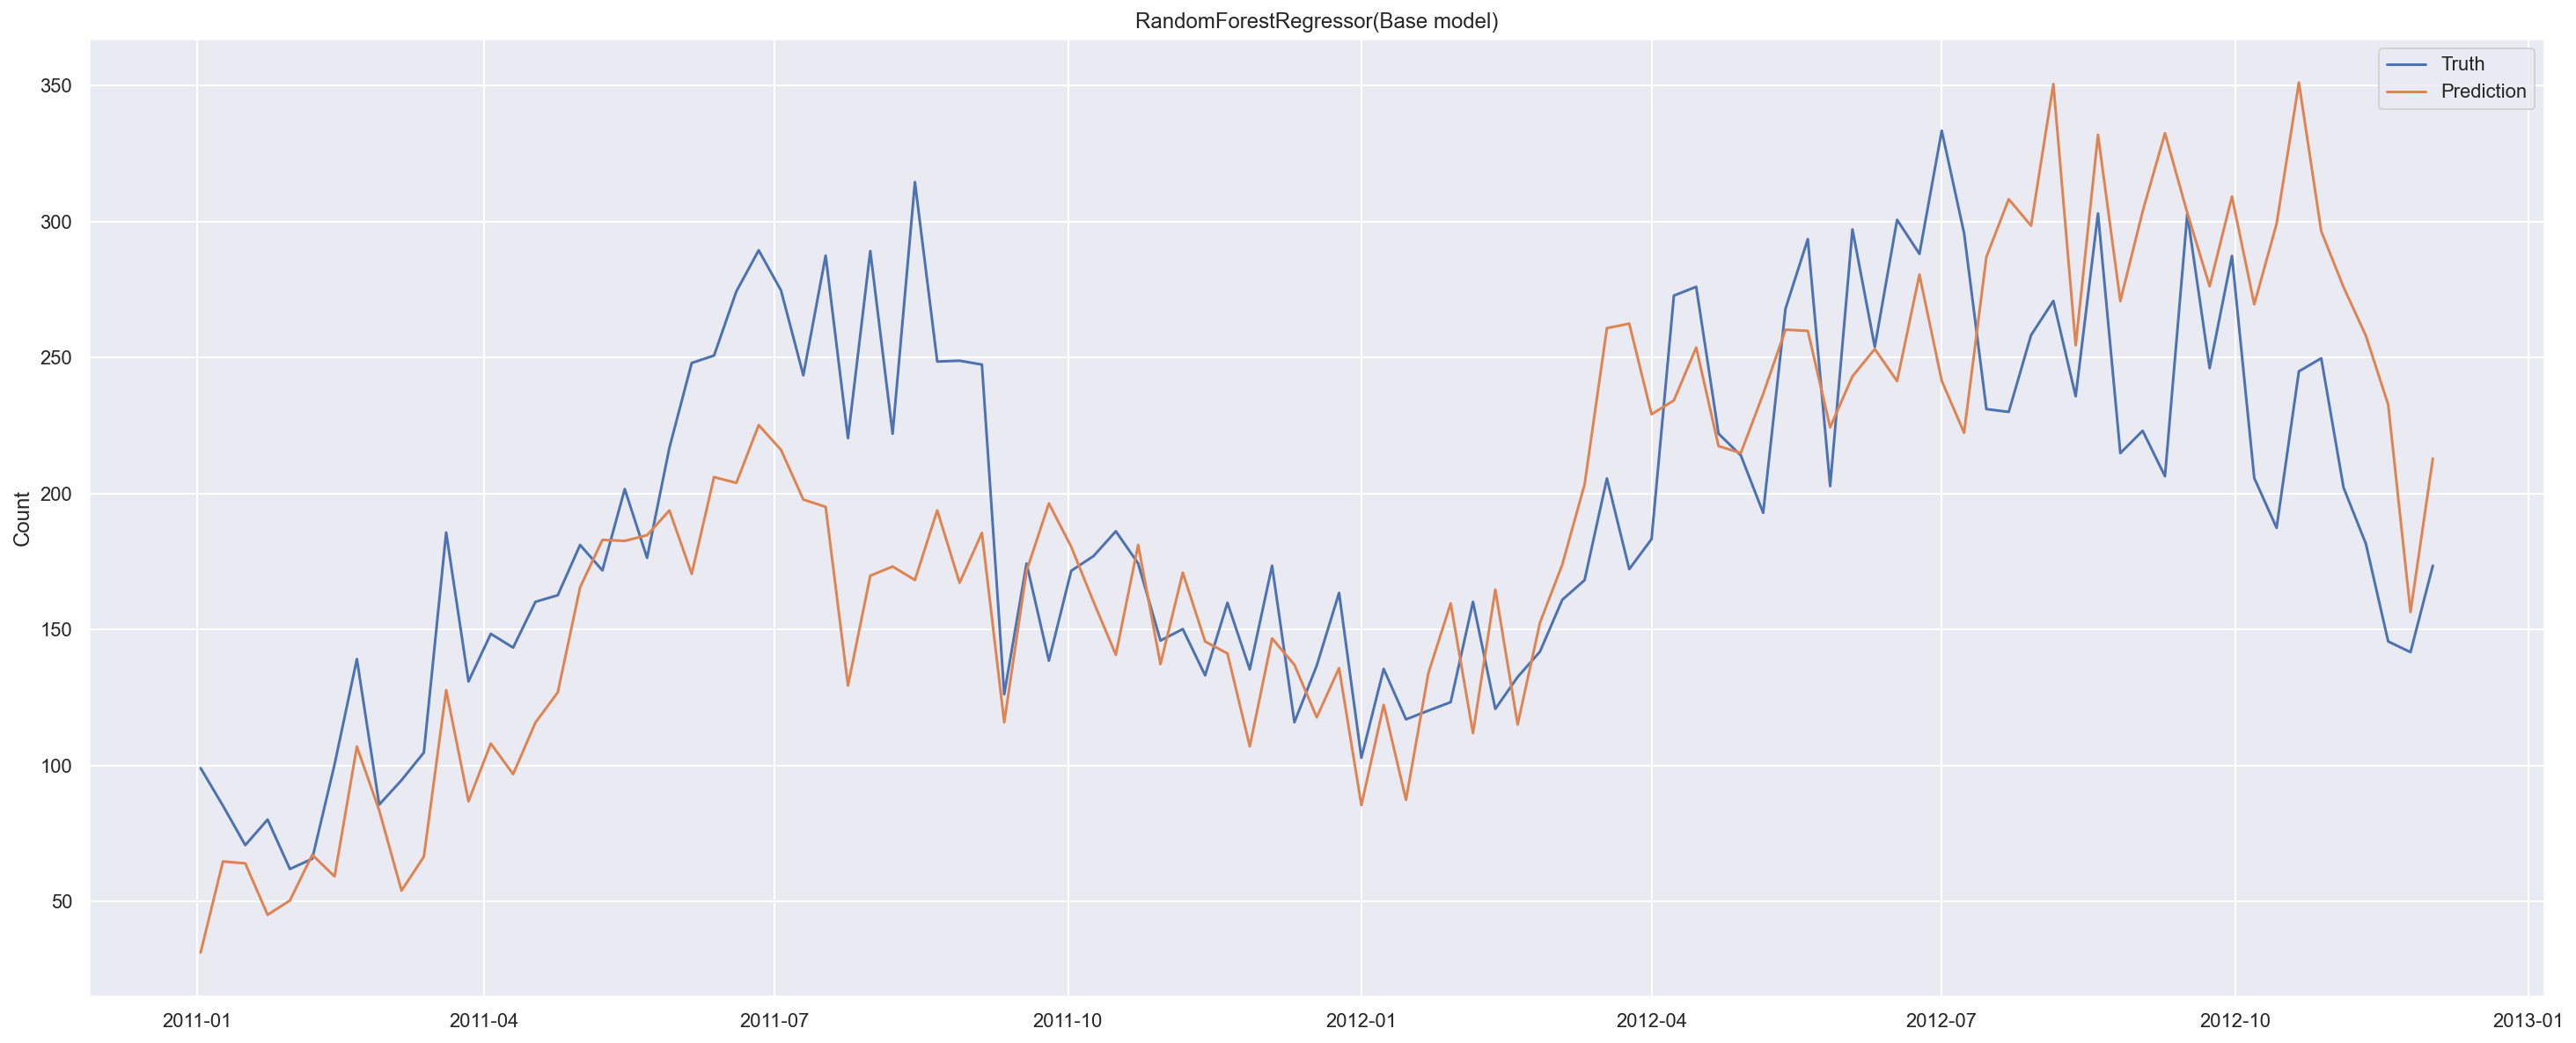

In [347]:
# Check performances on test data 

print("Test score RandomForestRegressor Pipeline", pipe.score(X_test, y_test))
print('Test NEGATIVE MAPE:', -mean_absolute_percentage_error(y_test, pipe.predict(X_test)))
print('Test NEGATIVE MAE:', -mean_absolute_error(y_test, pipe.predict(X_test)))

X_test['predicted'] = pipe.predict(X_test)
# Plot comparison results between predicted and real values
plt.plot(X_test['predicted'].resample('W').mean(),
         label='Truth')
plt.plot(y_test.resample('W').mean(),
         label='Prediction')
plt.title("RandomForestRegressor(Base model)")
plt.ylabel('Count')
plt.legend();
plt.show()

In [348]:
# The submission data

df_test['count'] = pipe.predict(df_test.drop('count', axis=1).values).astype(int)
df_test

holiday  weekday  workingday  weathersit  temp   hum  \
Date                                                                        
2012-12-01 00:00:00        0        6           0           1  0.26  0.81   
2012-12-01 01:00:00        0        6           0           1  0.26  0.81   
2012-12-01 02:00:00        0        6           0           2  0.26  0.81   
2012-12-01 03:00:00        0        6           0           2  0.26  0.81   
2012-12-01 04:00:00        0        6           0           1  0.26  0.81   
...                      ...      ...         ...         ...   ...   ...   
2012-12-31 19:00:00        0        1           1           2  0.26  0.60   
2012-12-31 20:00:00        0        1           1           2  0.26  0.60   
2012-12-31 21:00:00        0        1           1           1  0.26  0.60   
2012-12-31 22:00:00        0        1           1           1  0.26  0.56   
2012-12-31 23:00:00        0        1           1           1  0.26  0.65   

                     windspeed  count  
Date                                   
2012-12-01 00:00:00     0.0000     69  
2012-12-01 01:00:00     0.0000     69  
2012-12-01 02:00:00     0.0000     74  
2012-12-01 03:00:00     0.1343    124  
2012-12-01 04:00:00     0.0896     96  
...                        ...    ...  
2012-12-31 19:00:00     0.1642    144  
2012-12-31 20:00:00     0.1642    144  
2012-12-31 21:00:00     0.1642    201  
2012-12-31 22:00:00     0.1343     80  
2012-12-31 23:00:00     0.1343     17  

[742 rows x 8 columns]

<AxesSubplot:title={'center':'Train set - new year 2011'}, xlabel='Date'>

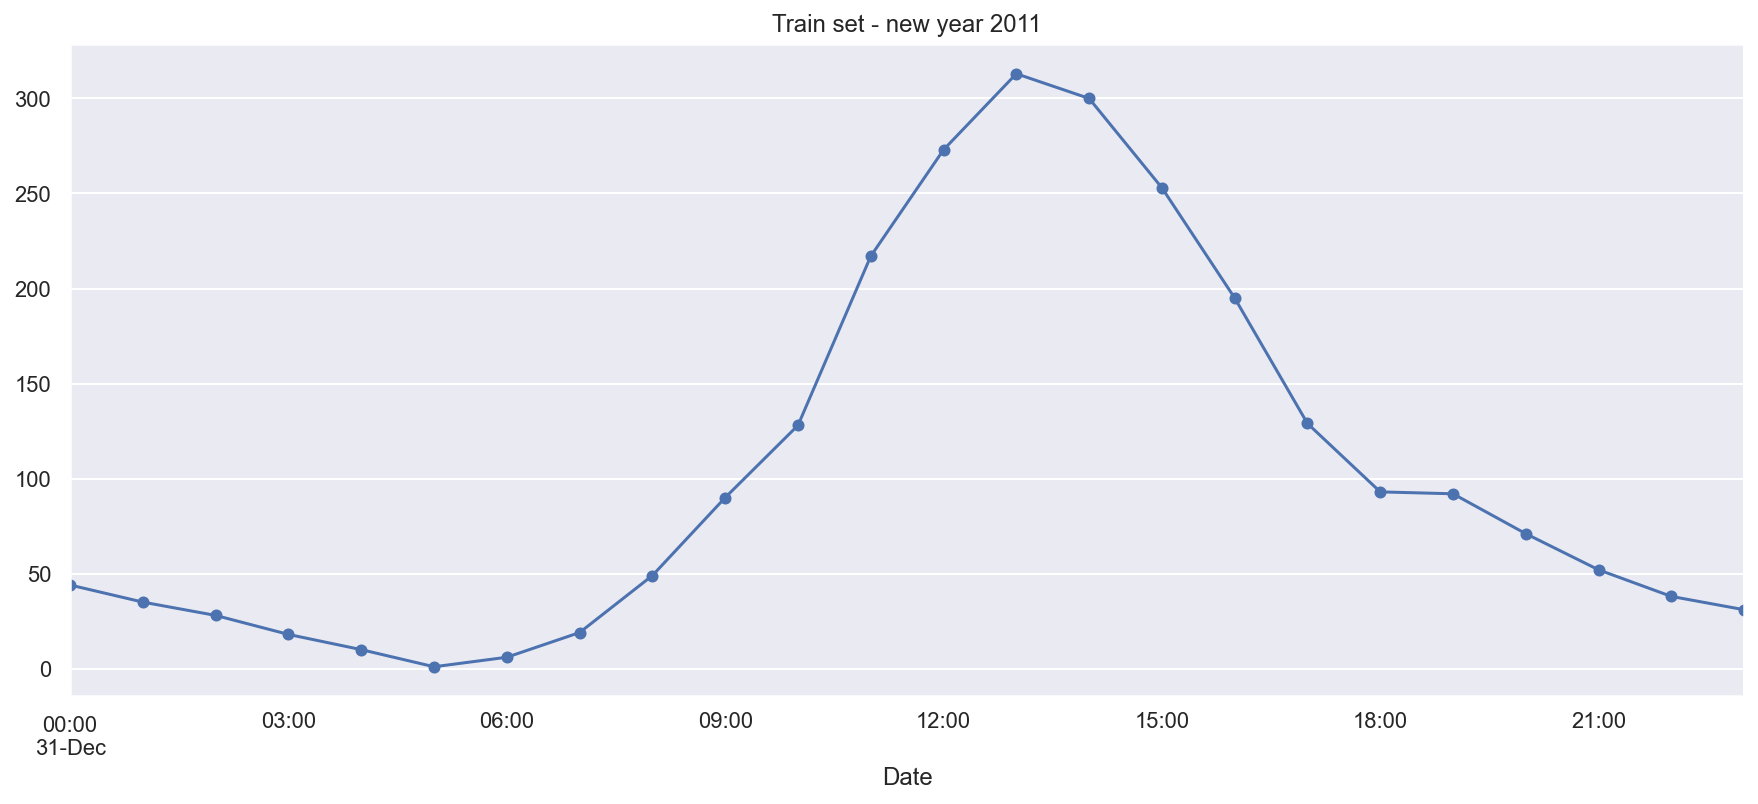

In [349]:
df_train_res_h = df_train['cnt']['2011-12-31':'2011-12-31']
df_train_res_h.plot(figsize=(15, 6), title='Train set - new year 2011', marker='.', markersize=10, linestyle='-')

<AxesSubplot:title={'center':'Test set predictions  - new year 2012'}, xlabel='Date'>

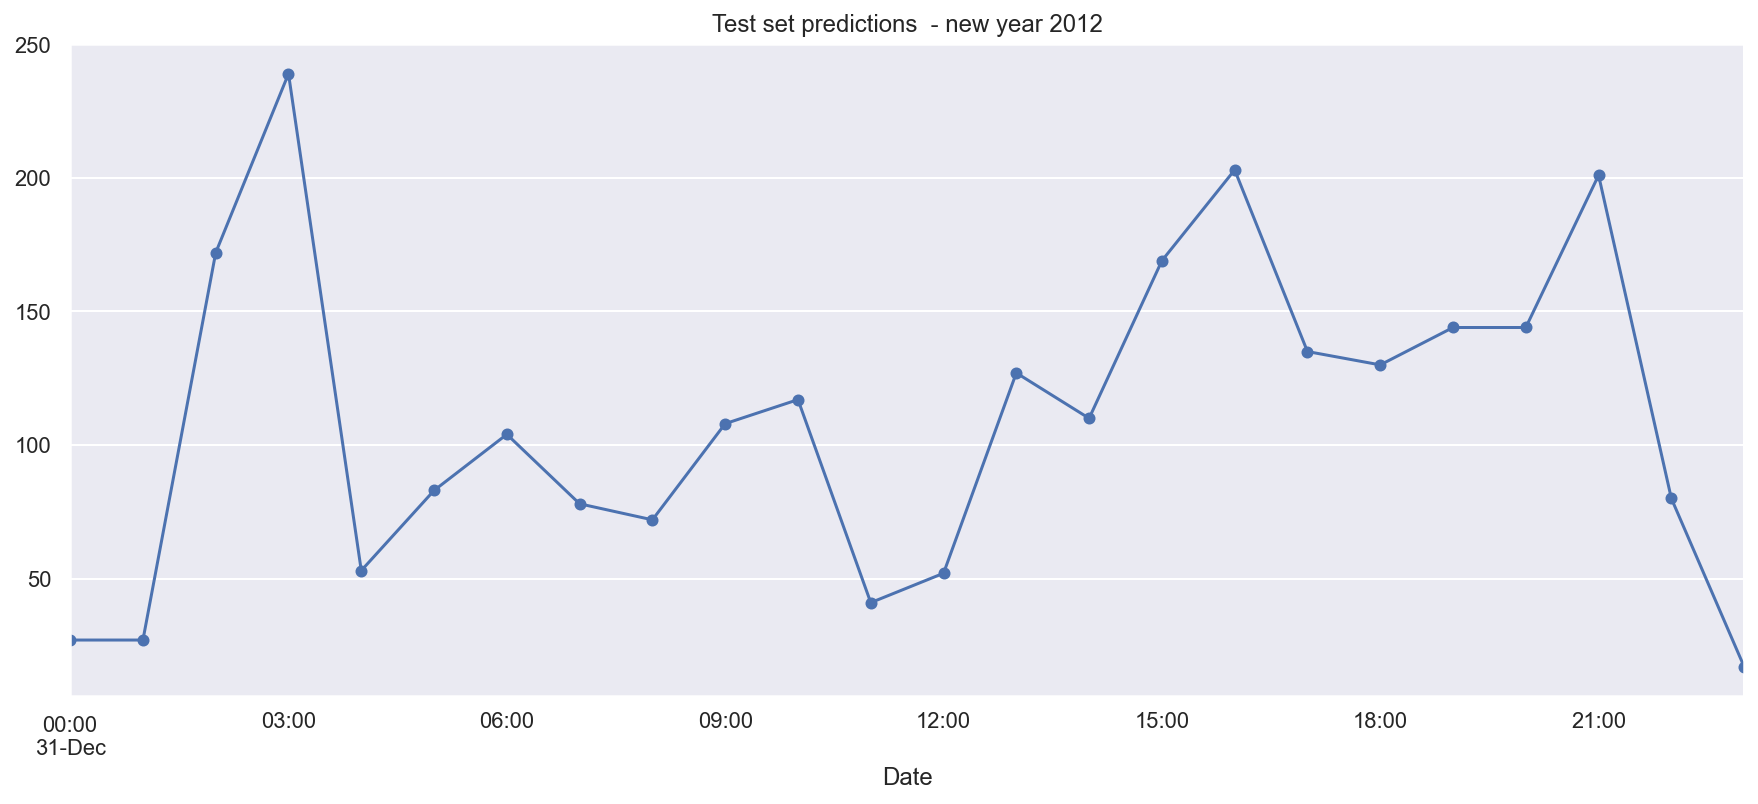

In [350]:
df_test_res_h = df_test['count']['2012-12-31':'2012-12-31']
df_test_res_h.plot(figsize=(15, 6), title='Test set predictions  - new year 2012', marker='.', markersize=10, linestyle='-')

In [351]:
display(df_train['2011-12-31'])
display(df_test['2012-12-31'])

holiday  weekday  workingday  weathersit  temp   hum  \
Date                                                                        
2011-12-31 00:00:00        0        6           0           2  0.38  0.62   
2011-12-31 01:00:00        0        6           0           2  0.40  0.62   
2011-12-31 02:00:00        0        6           0           2  0.40  0.62   
2011-12-31 03:00:00        0        6           0           2  0.40  0.62   
2011-12-31 04:00:00        0        6           0           1  0.38  0.71   
2011-12-31 05:00:00        0        6           0           2  0.36  0.76   
2011-12-31 06:00:00        0        6           0           2  0.40  0.71   
2011-12-31 07:00:00        0        6           0           3  0.38  0.76   
2011-12-31 08:00:00        0        6           0           1  0.34  0.81   
2011-12-31 09:00:00        0        6           0           1  0.38  0.76   
2011-12-31 10:00:00        0        6           0           1  0.40  0.76   
2011-12-31 11:00:00        0        6           0           1  0.42  0.71   
2011-12-31 12:00:00        0        6           0           1  0.52  0.39   
2011-12-31 13:00:00        0        6           0           1  0.50  0.42   
2011-12-31 14:00:00        0        6           0           1  0.46  0.51   
2011-12-31 15:00:00        0        6           0           1  0.46  0.47   
2011-12-31 16:00:00        0        6           0           1  0.44  0.51   
2011-12-31 17:00:00        0        6           0           1  0.42  0.54   
2011-12-31 18:00:00        0        6           0           1  0.42  0.54   
2011-12-31 19:00:00        0        6           0           1  0.42  0.54   
2011-12-31 20:00:00        0        6           0           1  0.42  0.54   
2011-12-31 21:00:00        0        6           0           1  0.40  0.58   
2011-12-31 22:00:00        0        6           0           1  0.38  0.62   
2011-12-31 23:00:00        0        6           0           1  0.36  0.66   

                     windspeed  cnt  
Date                                 
2011-12-31 00:00:00       0.32   44  
2011-12-31 01:00:00       0.28   35  
2011-12-31 02:00:00       0.28   28  
2011-12-31 03:00:00       0.28   18  
2011-12-31 04:00:00       0.22   10  
2011-12-31 05:00:00       0.22    1  
2011-12-31 06:00:00       0.08    6  
2011-12-31 07:00:00       0.00   19  
2011-12-31 08:00:00       0.13   49  
2011-12-31 09:00:00       0.00   90  
2011-12-31 10:00:00       0.16  128  
2011-12-31 11:00:00       0.16  217  
2011-12-31 12:00:00       0.29  273  
2011-12-31 13:00:00       0.49  313  
2011-12-31 14:00:00       0.32  300  
2011-12-31 15:00:00       0.49  253  
2011-12-31 16:00:00       0.38  195  
2011-12-31 17:00:00       0.19  129  
2011-12-31 18:00:00       0.13   93  
2011-12-31 19:00:00       0.22   92  
2011-12-31 20:00:00       0.22   71  
2011-12-31 21:00:00       0.19   52  
2011-12-31 22:00:00       0.13   38  
2011-12-31 23:00:00       0.00   31

holiday  weekday  workingday  weathersit  temp   hum  \
Date                                                                        
2012-12-31 00:00:00        0        1           1           1  0.18  0.55   
2012-12-31 01:00:00        0        1           1           1  0.18  0.55   
2012-12-31 02:00:00        0        1           1           1  0.16  0.59   
2012-12-31 03:00:00        0        1           1           1  0.16  0.59   
2012-12-31 04:00:00        0        1           1           1  0.14  0.69   
2012-12-31 05:00:00        0        1           1           1  0.16  0.64   
2012-12-31 06:00:00        0        1           1           1  0.16  0.64   
2012-12-31 07:00:00        0        1           1           1  0.16  0.64   
2012-12-31 08:00:00        0        1           1           1  0.14  0.69   
2012-12-31 09:00:00        0        1           1           2  0.18  0.64   
2012-12-31 10:00:00        0        1           1           2  0.20  0.69   
2012-12-31 11:00:00        0        1           1           2  0.22  0.60   
2012-12-31 12:00:00        0        1           1           2  0.24  0.56   
2012-12-31 13:00:00        0        1           1           2  0.26  0.44   
2012-12-31 14:00:00        0        1           1           2  0.28  0.45   
2012-12-31 15:00:00        0        1           1           2  0.28  0.45   
2012-12-31 16:00:00        0        1           1           2  0.26  0.48   
2012-12-31 17:00:00        0        1           1           2  0.26  0.48   
2012-12-31 18:00:00        0        1           1           2  0.26  0.48   
2012-12-31 19:00:00        0        1           1           2  0.26  0.60   
2012-12-31 20:00:00        0        1           1           2  0.26  0.60   
2012-12-31 21:00:00        0        1           1           1  0.26  0.60   
2012-12-31 22:00:00        0        1           1           1  0.26  0.56   
2012-12-31 23:00:00        0        1           1           1  0.26  0.65   

                     windspeed  count  
Date                                   
2012-12-31 00:00:00     0.1940     27  
2012-12-31 01:00:00     0.1940     27  
2012-12-31 02:00:00     0.1642    172  
2012-12-31 03:00:00     0.1045    239  
2012-12-31 04:00:00     0.1045     53  
2012-12-31 05:00:00     0.1940     83  
2012-12-31 06:00:00     0.1642    104  
2012-12-31 07:00:00     0.1343     78  
2012-12-31 08:00:00     0.1343     72  
2012-12-31 09:00:00     0.1045    108  
2012-12-31 10:00:00     0.1343    117  
2012-12-31 11:00:00     0.1940     41  
2012-12-31 12:00:00     0.1940     52  
2012-12-31 13:00:00     0.1642    127  
2012-12-31 14:00:00     0.2239    110  
2012-12-31 15:00:00     0.1343    169  
2012-12-31 16:00:00     0.1940    203  
2012-12-31 17:00:00     0.0896    135  
2012-12-31 18:00:00     0.1343    130  
2012-12-31 19:00:00     0.1642    144  
2012-12-31 20:00:00     0.1642    144  
2012-12-31 21:00:00     0.1642    201  
2012-12-31 22:00:00     0.1343     80  
2012-12-31 23:00:00     0.1343     17

___________________________________

___________________________________

## RANDOMFOREST - RESAMPLE

Best Model GridSearchCV: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=15))])
Train score RandomForestRegressor GridSearchCV model 0.9557865989219588
Train NEGATIVE MAPE: -0.21059481557100818
Train NEGATIVE MAE: -8.540629874142741


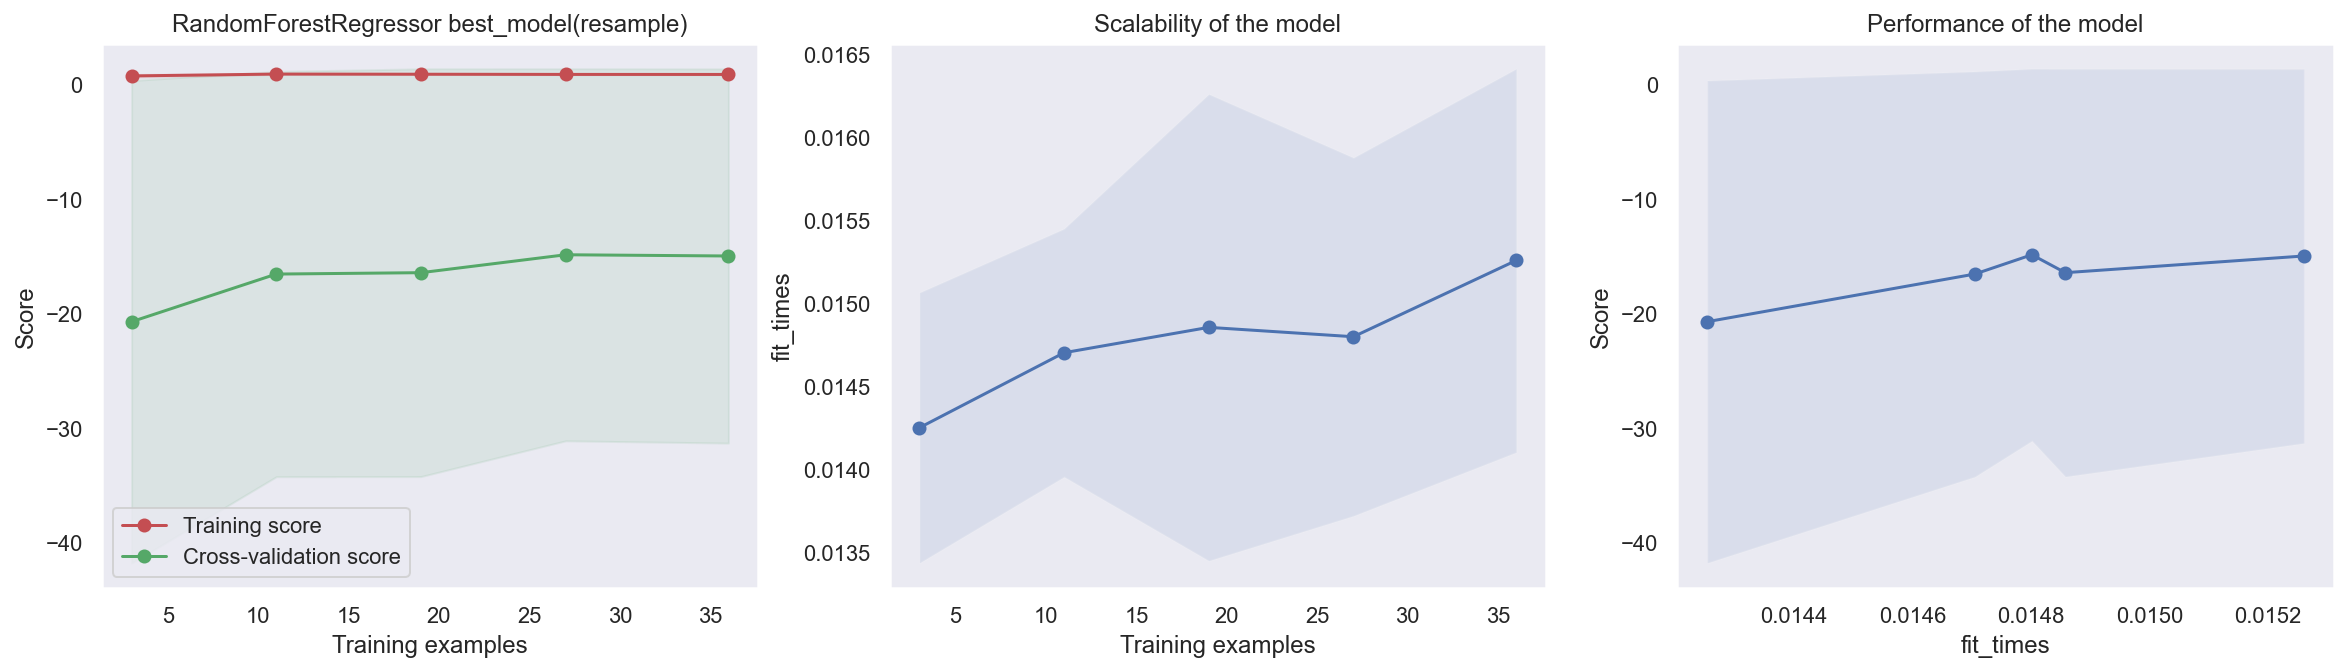

In [352]:
# Resample dayly for hours trends
df_train_R = df_train.resample('D').mean()
df_train_R = df_train_R.dropna()

X_train = df_train_R.drop('cnt', axis=1)[:'2012-01-01'].values
X_test = df_train_R.drop('cnt', axis=1)['2012-01-01':].values
y_train = df_train_R['cnt'][:'2012-01-01'].values
y_test = df_train_R['cnt']['2012-01-01':].values

pipe = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler()), 
                ('model', RandomForestRegressor())
                ])

param_search = { 
    'model__n_estimators': [5, 10, 15, 20],
    #'model__max_features': ['sqrt', 'log2'],
    'model__max_depth' : [i for i in range(5,25)]
}

neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=10)

#gsearch = GridSearchCV(estimator=pipe, cv=tscv, param_grid=param_search, scoring=neg_mape)
gsearch = GridSearchCV(pipe, param_grid=param_search, cv=tscv, scoring=neg_mape)

gsearch.fit(X_train, y_train)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print("Best Model GridSearchCV:", best_model)
print("Train score RandomForestRegressor GridSearchCV model", best_model.score(X_train, y_train))
print("Train NEGATIVE MAPE:", best_score)
print("Train NEGATIVE MAE:", -mean_absolute_error(y_train, best_model.predict(X_train)))

plot_learning_curve(best_model, "RandomForestRegressor best_model(resample)", X_train, y_train, cv=tscv);

Test score RandomForestRegressor GridSearchCV model -0.8085233340213243
Test NEGATIVE MAPE: -0.3603657311850441
Test NEGATIVE MAE: -87.38129731806724


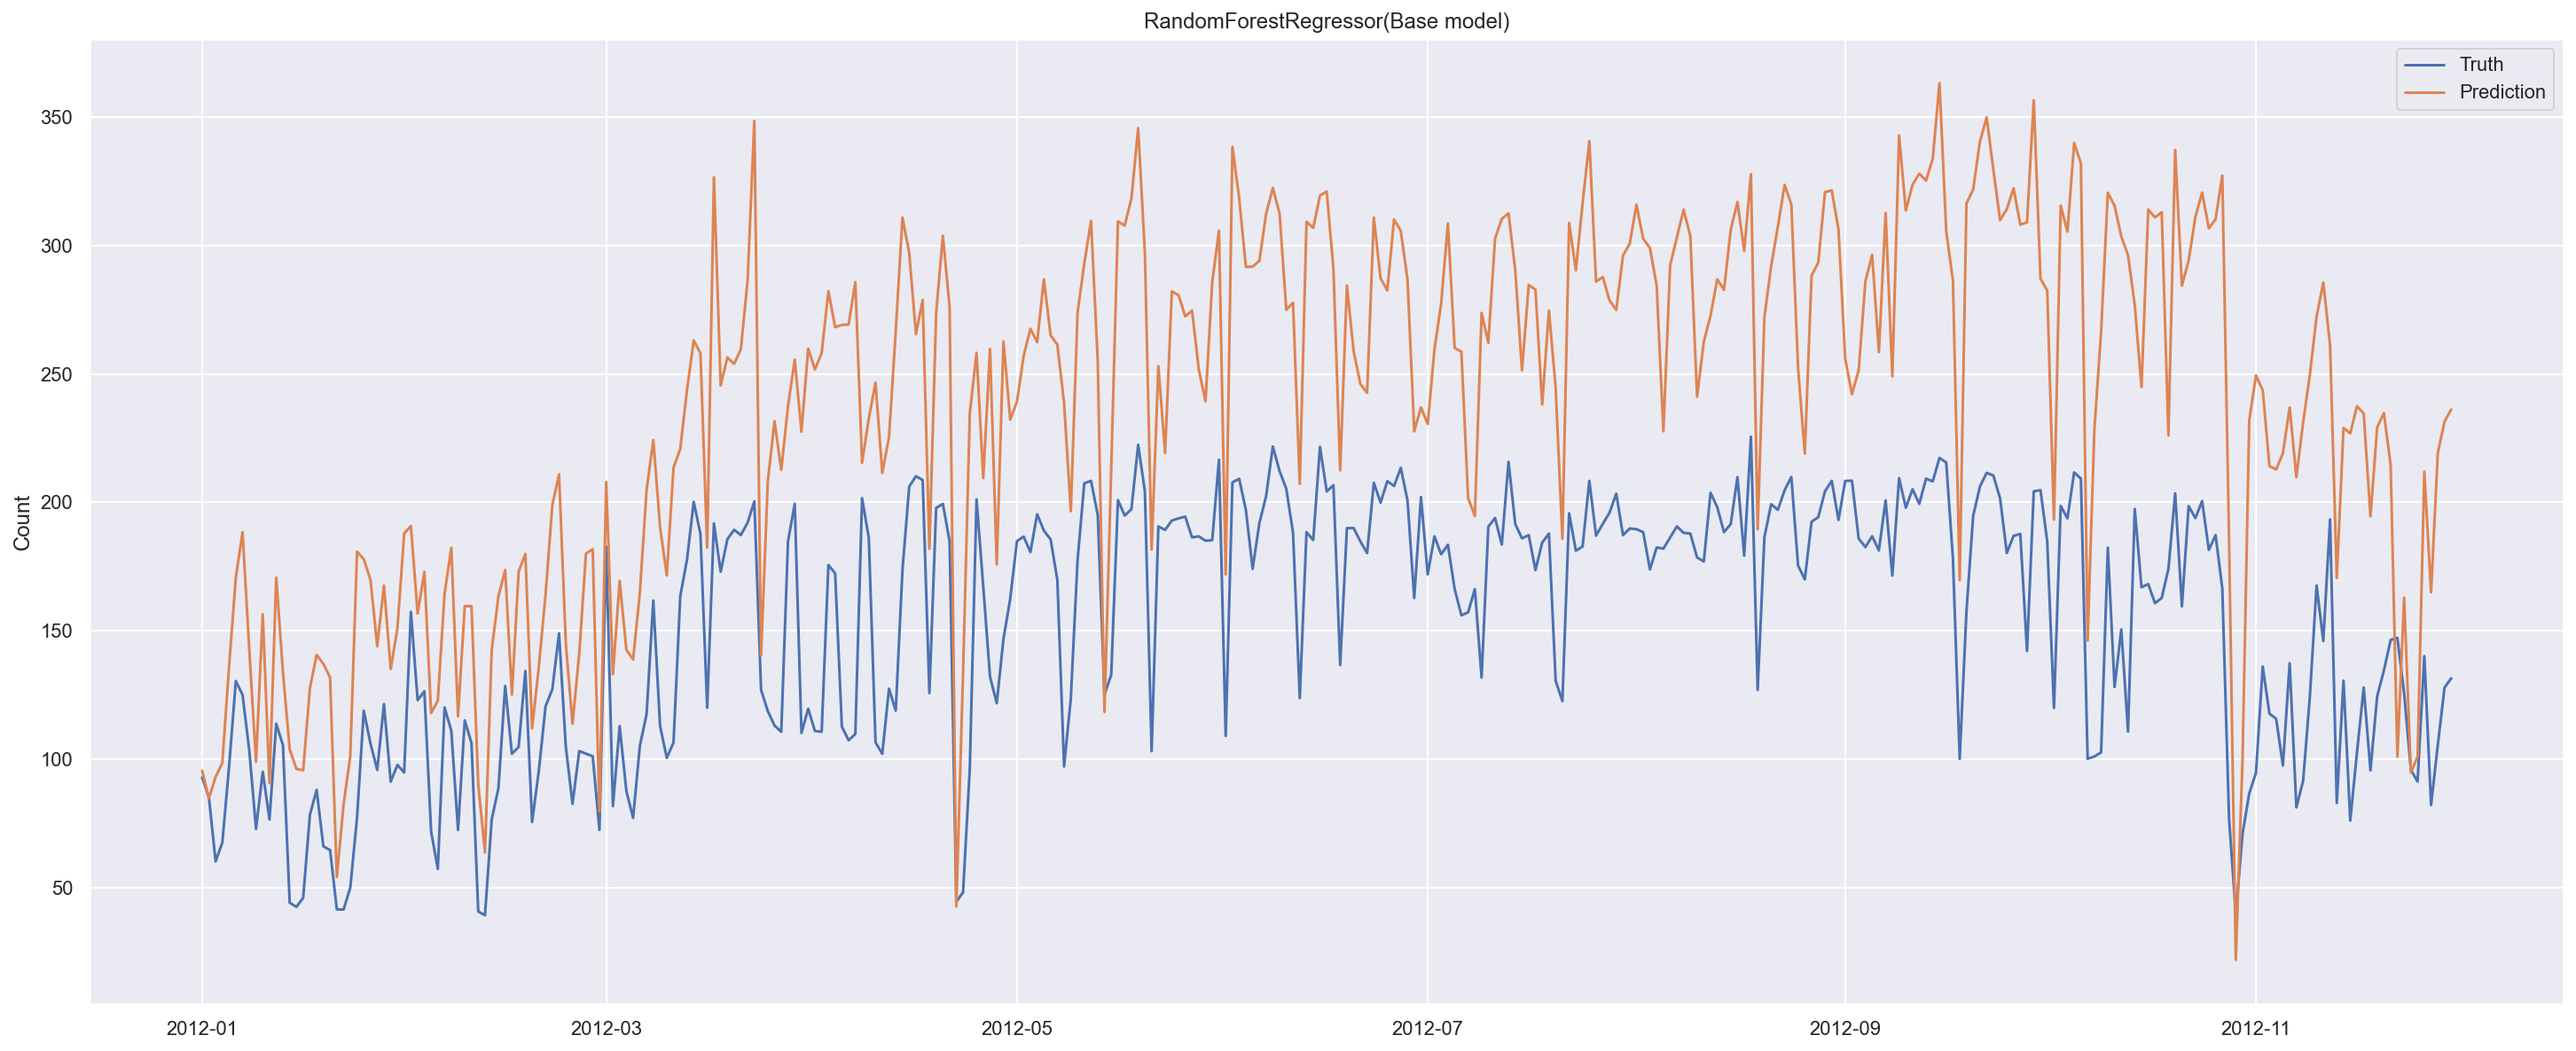

In [353]:
print("Test score RandomForestRegressor GridSearchCV model", best_model.score(X_test, y_test))
print("Test NEGATIVE MAPE:", -mean_absolute_percentage_error(y_test, best_model.predict(X_test)))
print("Test NEGATIVE MAE:", -mean_absolute_error(y_test, best_model.predict(X_test)))

subset_train_df_ = df_train_R['2012-01-01':]
subset_train_df_['predicted'] = best_model.predict(X_test)
# Plot comparison results between predicted and real values
plt.plot(subset_train_df_['predicted'],
         label='Truth')
plt.plot(df_train_R['cnt']['2012-01-01':],
         label='Prediction')
plt.title("RandomForestRegressor(Base model)")
plt.ylabel('Count')
plt.legend();
plt.show()

holiday  weekday  workingday  weathersit  temp   hum  \
Date                                                                        
2012-12-01 00:00:00        0        6           0           1  0.26  0.81   
2012-12-01 01:00:00        0        6           0           1  0.26  0.81   
2012-12-01 02:00:00        0        6           0           2  0.26  0.81   
2012-12-01 03:00:00        0        6           0           2  0.26  0.81   
2012-12-01 04:00:00        0        6           0           1  0.26  0.81   
...                      ...      ...         ...         ...   ...   ...   
2012-12-31 19:00:00        0        1           1           2  0.26  0.60   
2012-12-31 20:00:00        0        1           1           2  0.26  0.60   
2012-12-31 21:00:00        0        1           1           1  0.26  0.60   
2012-12-31 22:00:00        0        1           1           1  0.26  0.56   
2012-12-31 23:00:00        0        1           1           1  0.26  0.65   

                     windspeed  count  
Date                                   
2012-12-01 00:00:00     0.0000     92  
2012-12-01 01:00:00     0.0000     92  
2012-12-01 02:00:00     0.0000     81  
2012-12-01 03:00:00     0.1343     59  
2012-12-01 04:00:00     0.0896     96  
...                        ...    ...  
2012-12-31 19:00:00     0.1642     86  
2012-12-31 20:00:00     0.1642     86  
2012-12-31 21:00:00     0.1642     98  
2012-12-31 22:00:00     0.1343    104  
2012-12-31 23:00:00     0.1343     98  

[742 rows x 8 columns]

<AxesSubplot:title={'center':'Test set predictions  - new year 2012'}, xlabel='Date'>

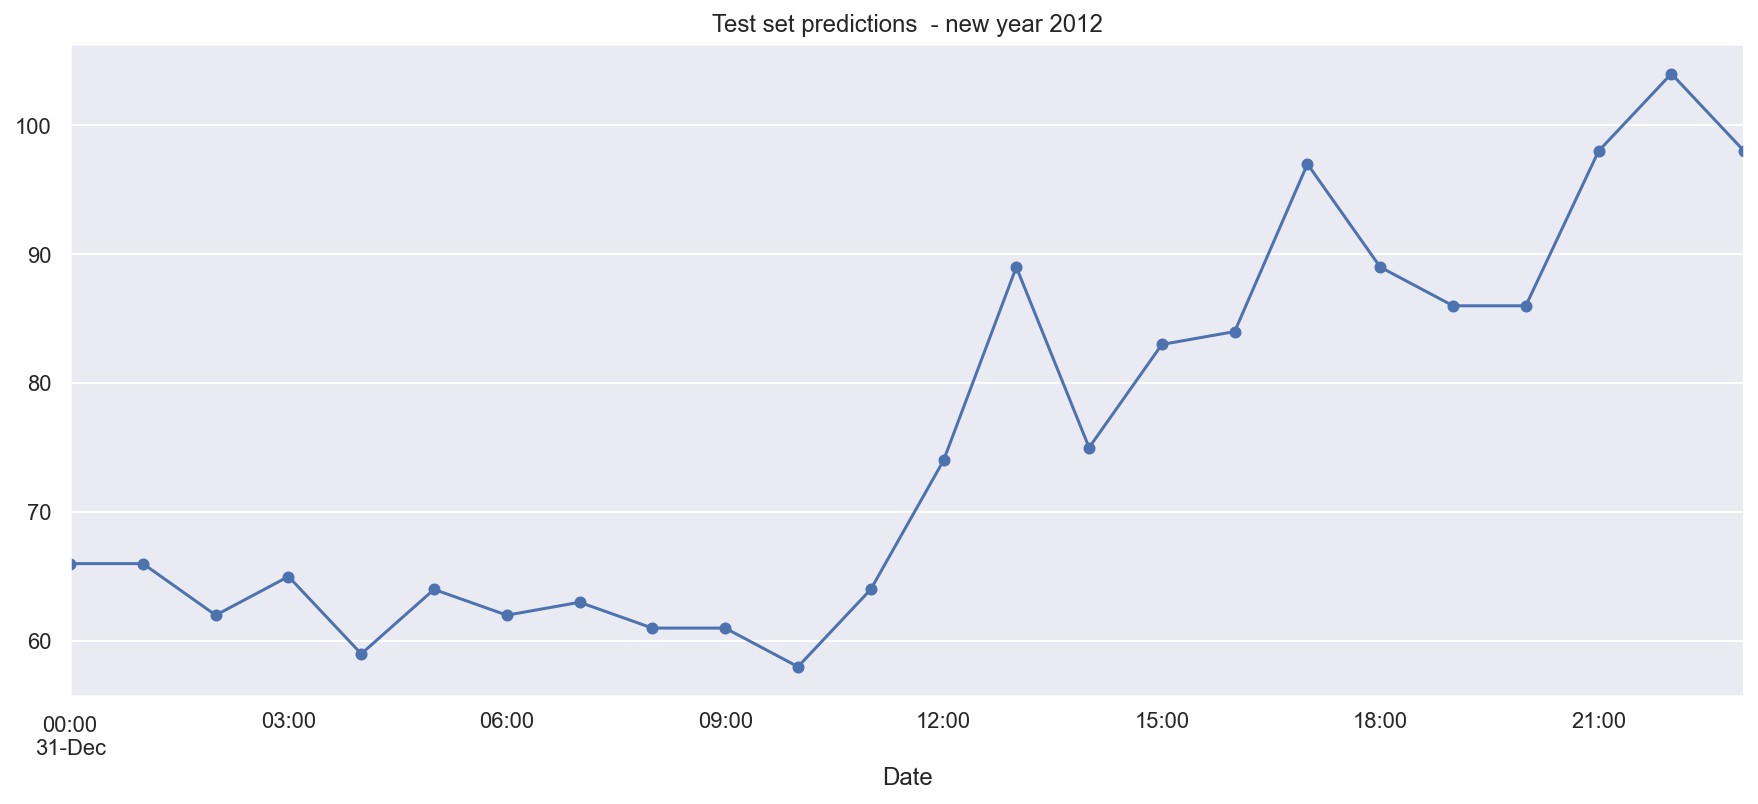

In [354]:
df_test['count'] = best_model.predict(df_test.drop('count', axis=1).values).astype(int)
display(df_test)
df_test_res_h = df_test['count']['2012-12-31':'2012-12-31']
df_test_res_h.plot(figsize=(15, 6), title='Test set predictions  - new year 2012', marker='.', markersize=10, linestyle='-')

___________________________________

___________________________________

## RANDOMFOREST - ROLLING

Best Model GridSearchCV: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=12, n_estimators=25))])
Train score RandomForestRegressor GridSearchCV model 0.9779814413417669
Train NEGATIVE MAPE: -0.19660908839838306
Train NEGATIVE MAE: -5.262097513310213


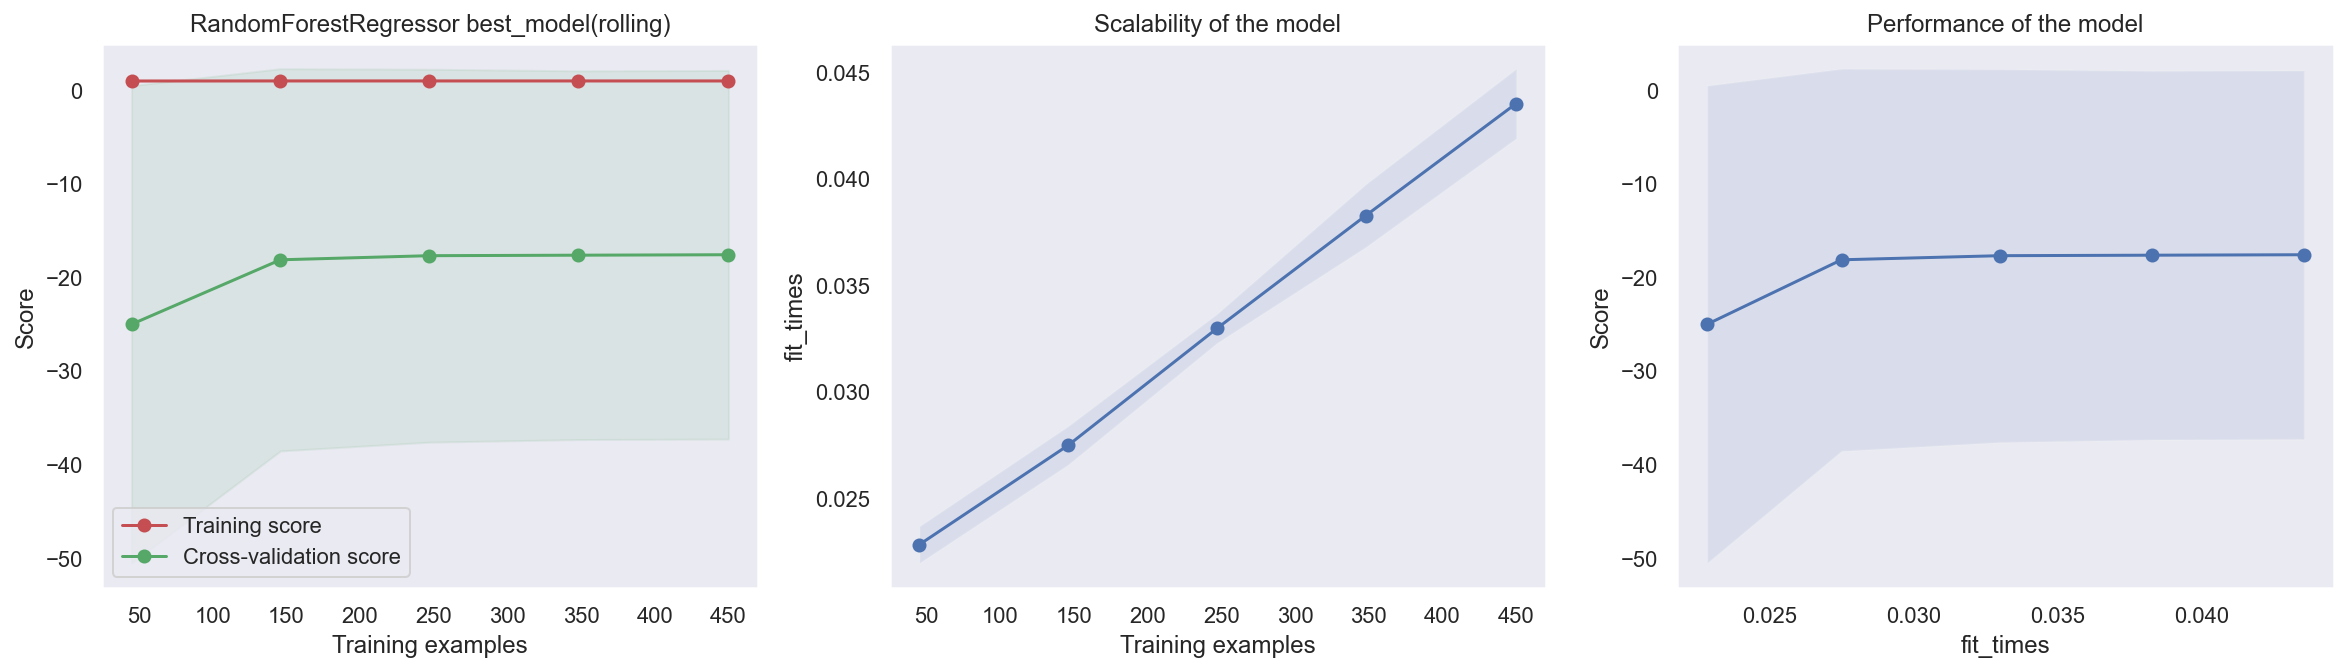

In [355]:
df_train_R = df_train.rolling('D', min_periods=1).mean()
df_train_R = df_train_R.dropna()

X_train = df_train_R.drop('cnt', axis=1)[:'2012-02-01'].values
X_test = df_train_R.drop('cnt', axis=1)['2012-02-01':].values
y_train = df_train_R['cnt'][:'2012-02-01'].values
y_test = df_train_R['cnt']['2012-02-01':].values

pipe = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler()), 
                ('model', RandomForestRegressor())
                ])

param_search = { 
    'model__n_estimators': [5, 10, 15, 20, 25],
    #'model__max_features': ['sqrt', 'log2'],
    'model__max_depth' : [i for i in range(5,25)]
}

neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=20)

#gsearch = GridSearchCV(estimator=pipe, cv=tscv, param_grid=param_search, scoring=neg_mape)
gsearch = GridSearchCV(pipe, param_grid=param_search, cv=tscv, refit=True, scoring=neg_mape)

gsearch.fit(X_train, y_train)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print("Best Model GridSearchCV:", best_model)
print("Train score RandomForestRegressor GridSearchCV model", best_model.score(X_train, y_train))
print("Train NEGATIVE MAPE:", best_score)
print("Train NEGATIVE MAE:", -mean_absolute_error(y_train, best_model.predict(X_train)))

plot_learning_curve(best_model, "RandomForestRegressor best_model(rolling)", X_train, y_train, cv=tscv);

Test score RandomForestRegressor GridSearchCV model -1.4105465786309073
Test NEGATIVE MAPE: -0.3448502106829355
Test NEGATIVE MAE: -88.39554376914623


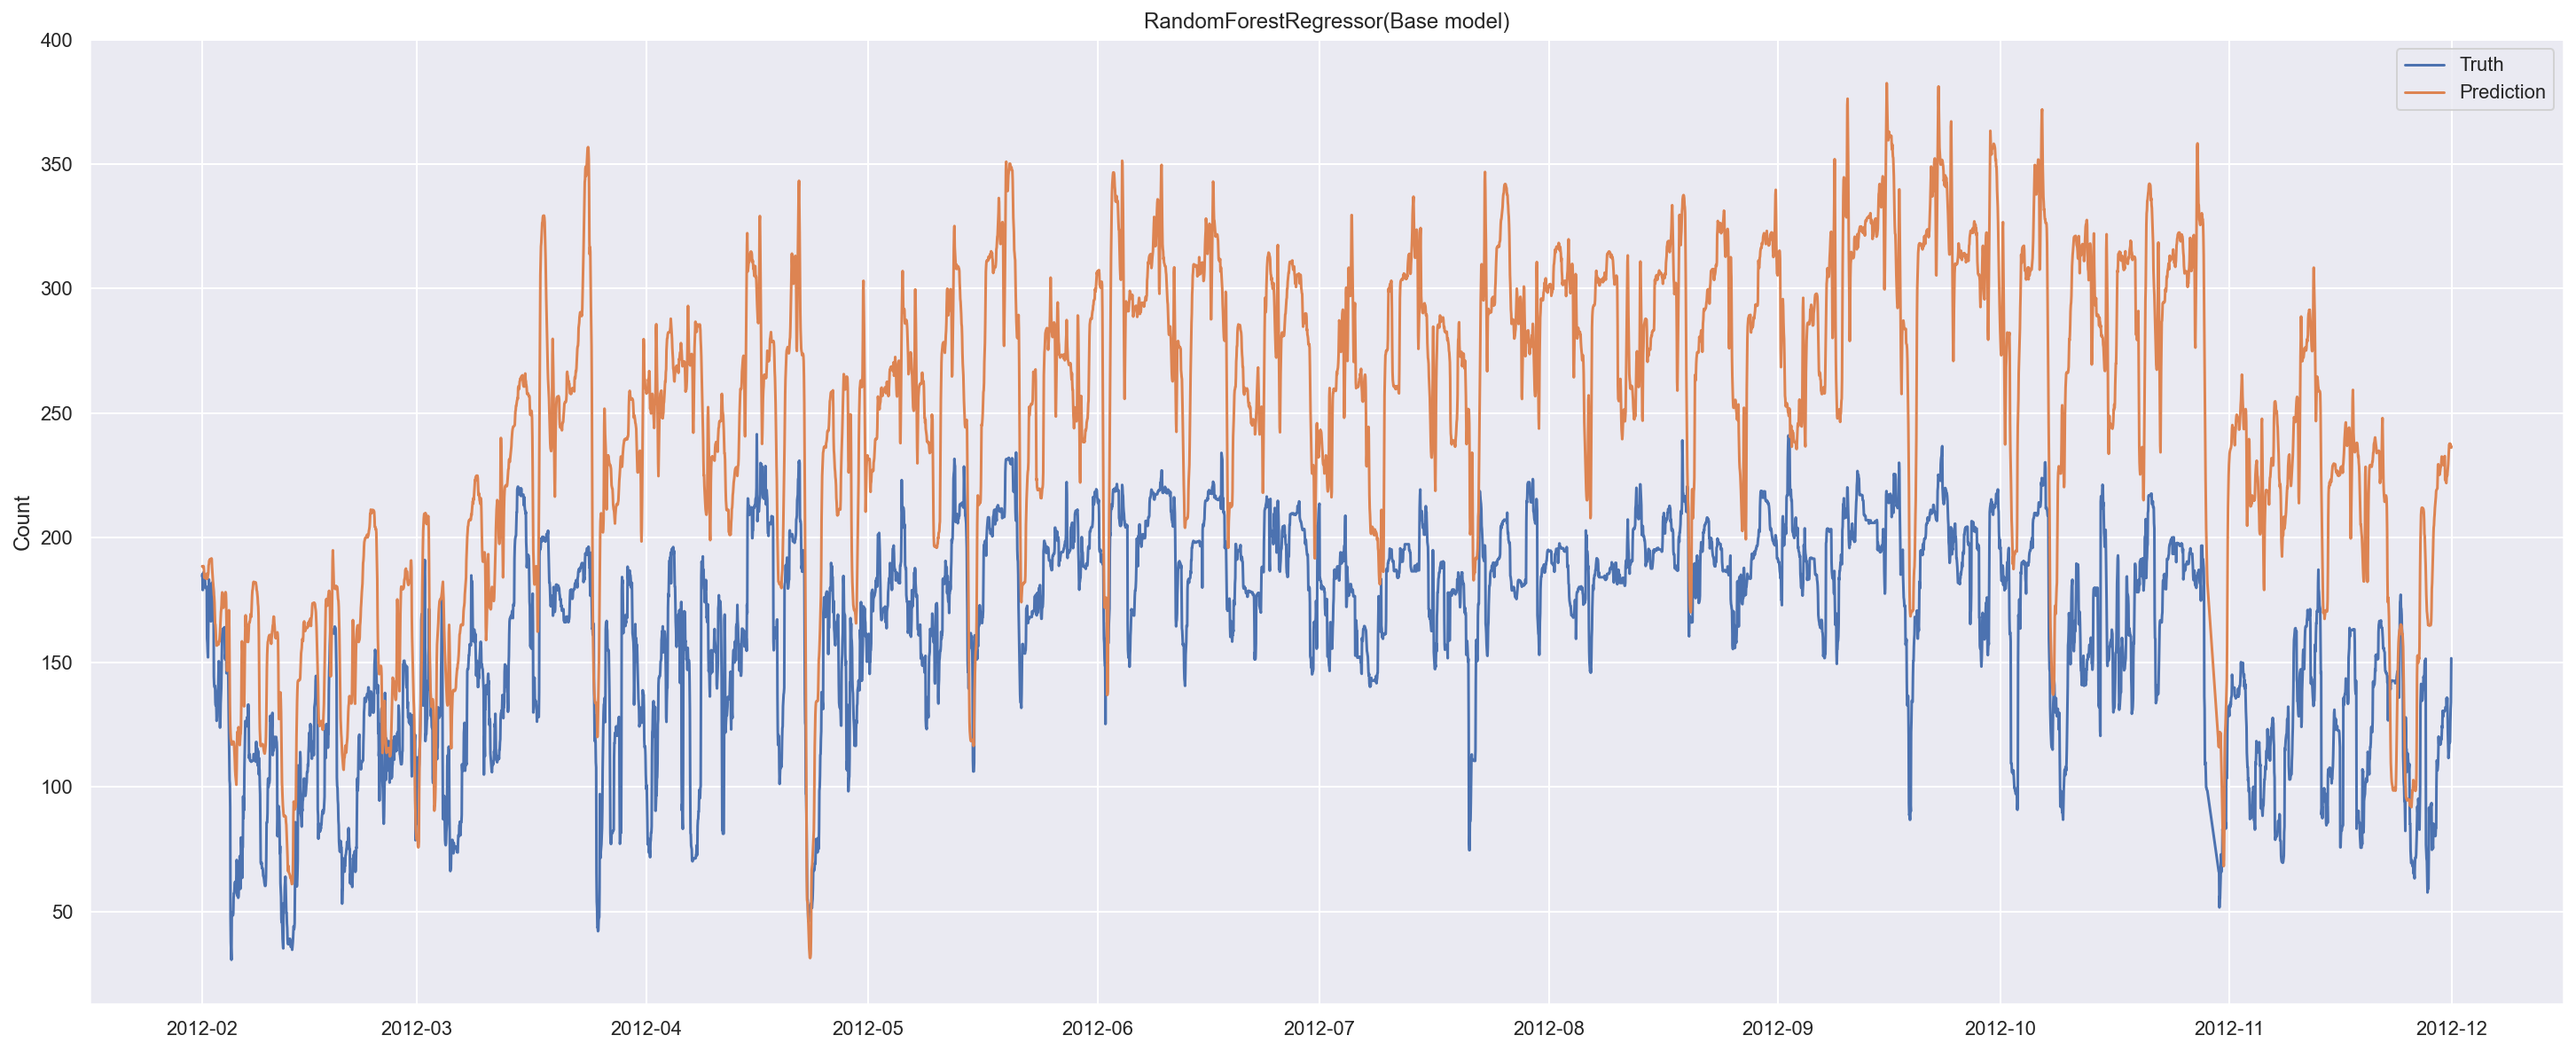

In [356]:
print("Test score RandomForestRegressor GridSearchCV model", best_model.score(X_test, y_test))
print("Test NEGATIVE MAPE:", -mean_absolute_percentage_error(y_test, best_model.predict(X_test)))
print("Test NEGATIVE MAE:", -mean_absolute_error(y_test, best_model.predict(X_test)))

subset_train_df_ = df_train_R['2012-02-01':]
subset_train_df_['predicted'] = best_model.predict(X_test)
# Plot comparison results between predicted and real values
plt.plot(subset_train_df_['predicted'],
         label='Truth')
plt.plot(df_train_R['cnt']['2012-02-01':],
         label='Prediction')
plt.title("RandomForestRegressor(Base model)")
plt.ylabel('Count')
plt.legend();
plt.show()

holiday  weekday  workingday  weathersit  temp   hum  \
Date                                                                        
2012-12-01 00:00:00        0        6           0           1  0.26  0.81   
2012-12-01 01:00:00        0        6           0           1  0.26  0.81   
2012-12-01 02:00:00        0        6           0           2  0.26  0.81   
2012-12-01 03:00:00        0        6           0           2  0.26  0.81   
2012-12-01 04:00:00        0        6           0           1  0.26  0.81   
...                      ...      ...         ...         ...   ...   ...   
2012-12-31 19:00:00        0        1           1           2  0.26  0.60   
2012-12-31 20:00:00        0        1           1           2  0.26  0.60   
2012-12-31 21:00:00        0        1           1           1  0.26  0.60   
2012-12-31 22:00:00        0        1           1           1  0.26  0.56   
2012-12-31 23:00:00        0        1           1           1  0.26  0.65   

                     windspeed  count  
Date                                   
2012-12-01 00:00:00     0.0000     21  
2012-12-01 01:00:00     0.0000     21  
2012-12-01 02:00:00     0.0000     25  
2012-12-01 03:00:00     0.1343     33  
2012-12-01 04:00:00     0.0896     25  
...                        ...    ...  
2012-12-31 19:00:00     0.1642     89  
2012-12-31 20:00:00     0.1642     89  
2012-12-31 21:00:00     0.1642    110  
2012-12-31 22:00:00     0.1343    100  
2012-12-31 23:00:00     0.1343    101  

[742 rows x 8 columns]

<AxesSubplot:title={'center':'Test set predictions  - new year 2012'}, xlabel='Date'>

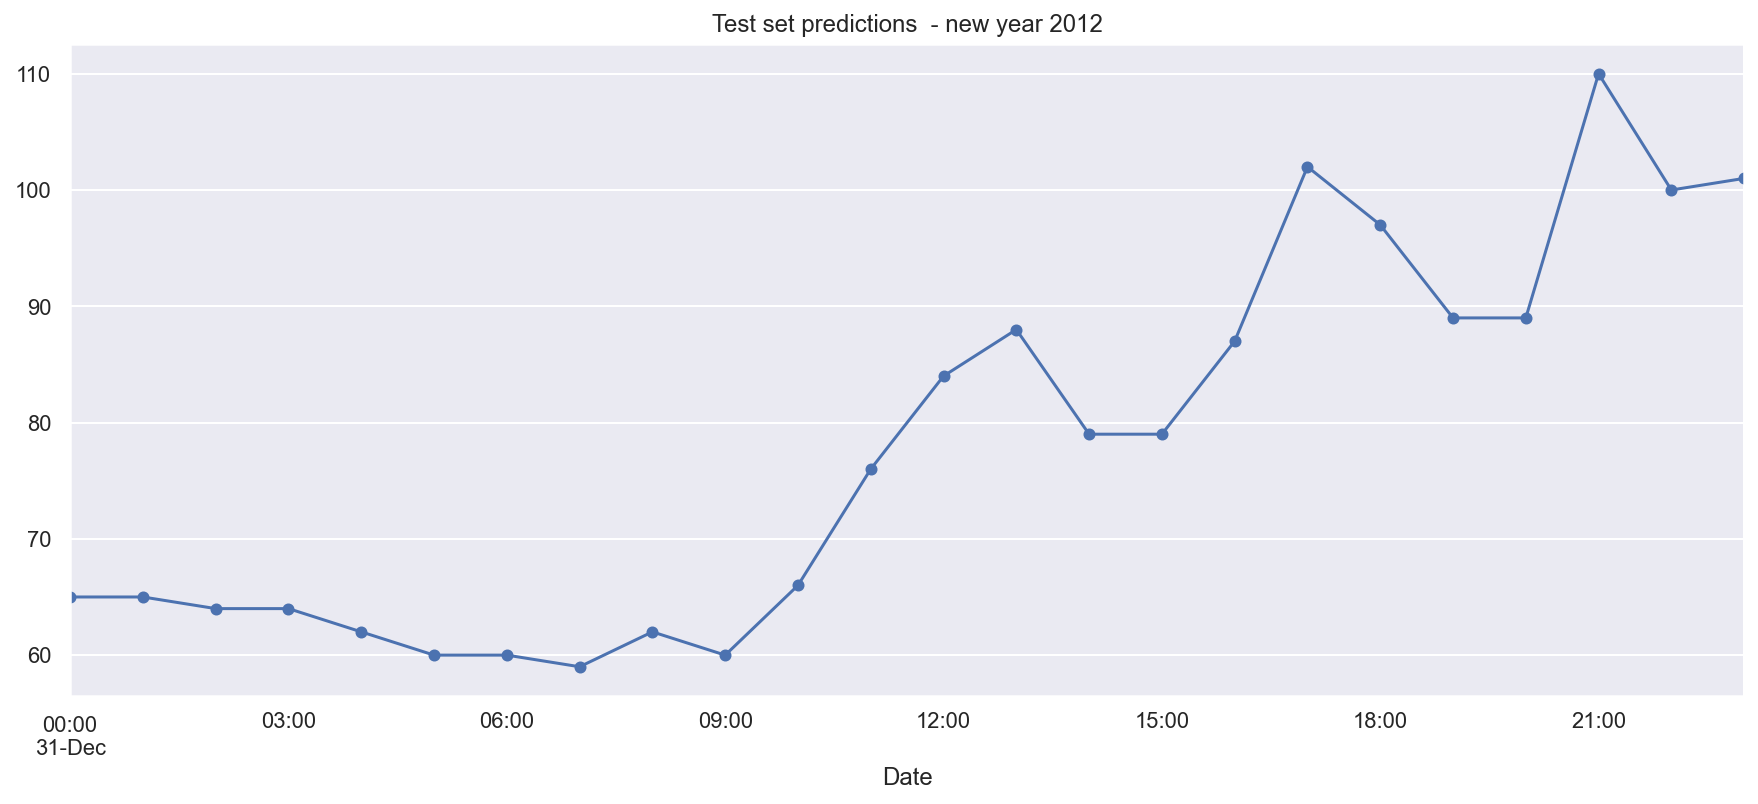

In [357]:
df_test['count'] = best_model.predict(df_test.drop('count', axis=1).values).astype(int)
display(df_test)
df_test_res_h = df_test['count']['2012-12-31':'2012-12-31']
df_test_res_h.plot(figsize=(15, 6), title='Test set predictions  - new year 2012', marker='.', markersize=10, linestyle='-')

___________________________________

___________________________________

## ARIMA

pmdarima version: 1.8.5
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=98068.311, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=99592.617, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=98854.211, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=98399.451, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=99590.617, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=98067.640, Time=1.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=98373.849, Time=2.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=98071.183, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=98068.494, Time=3.72 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=98067.472, Time=0.54 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=98069.015, Time=0.67 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=98070.488, Time=1.22 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=98065.472, Time=0.26 sec
 

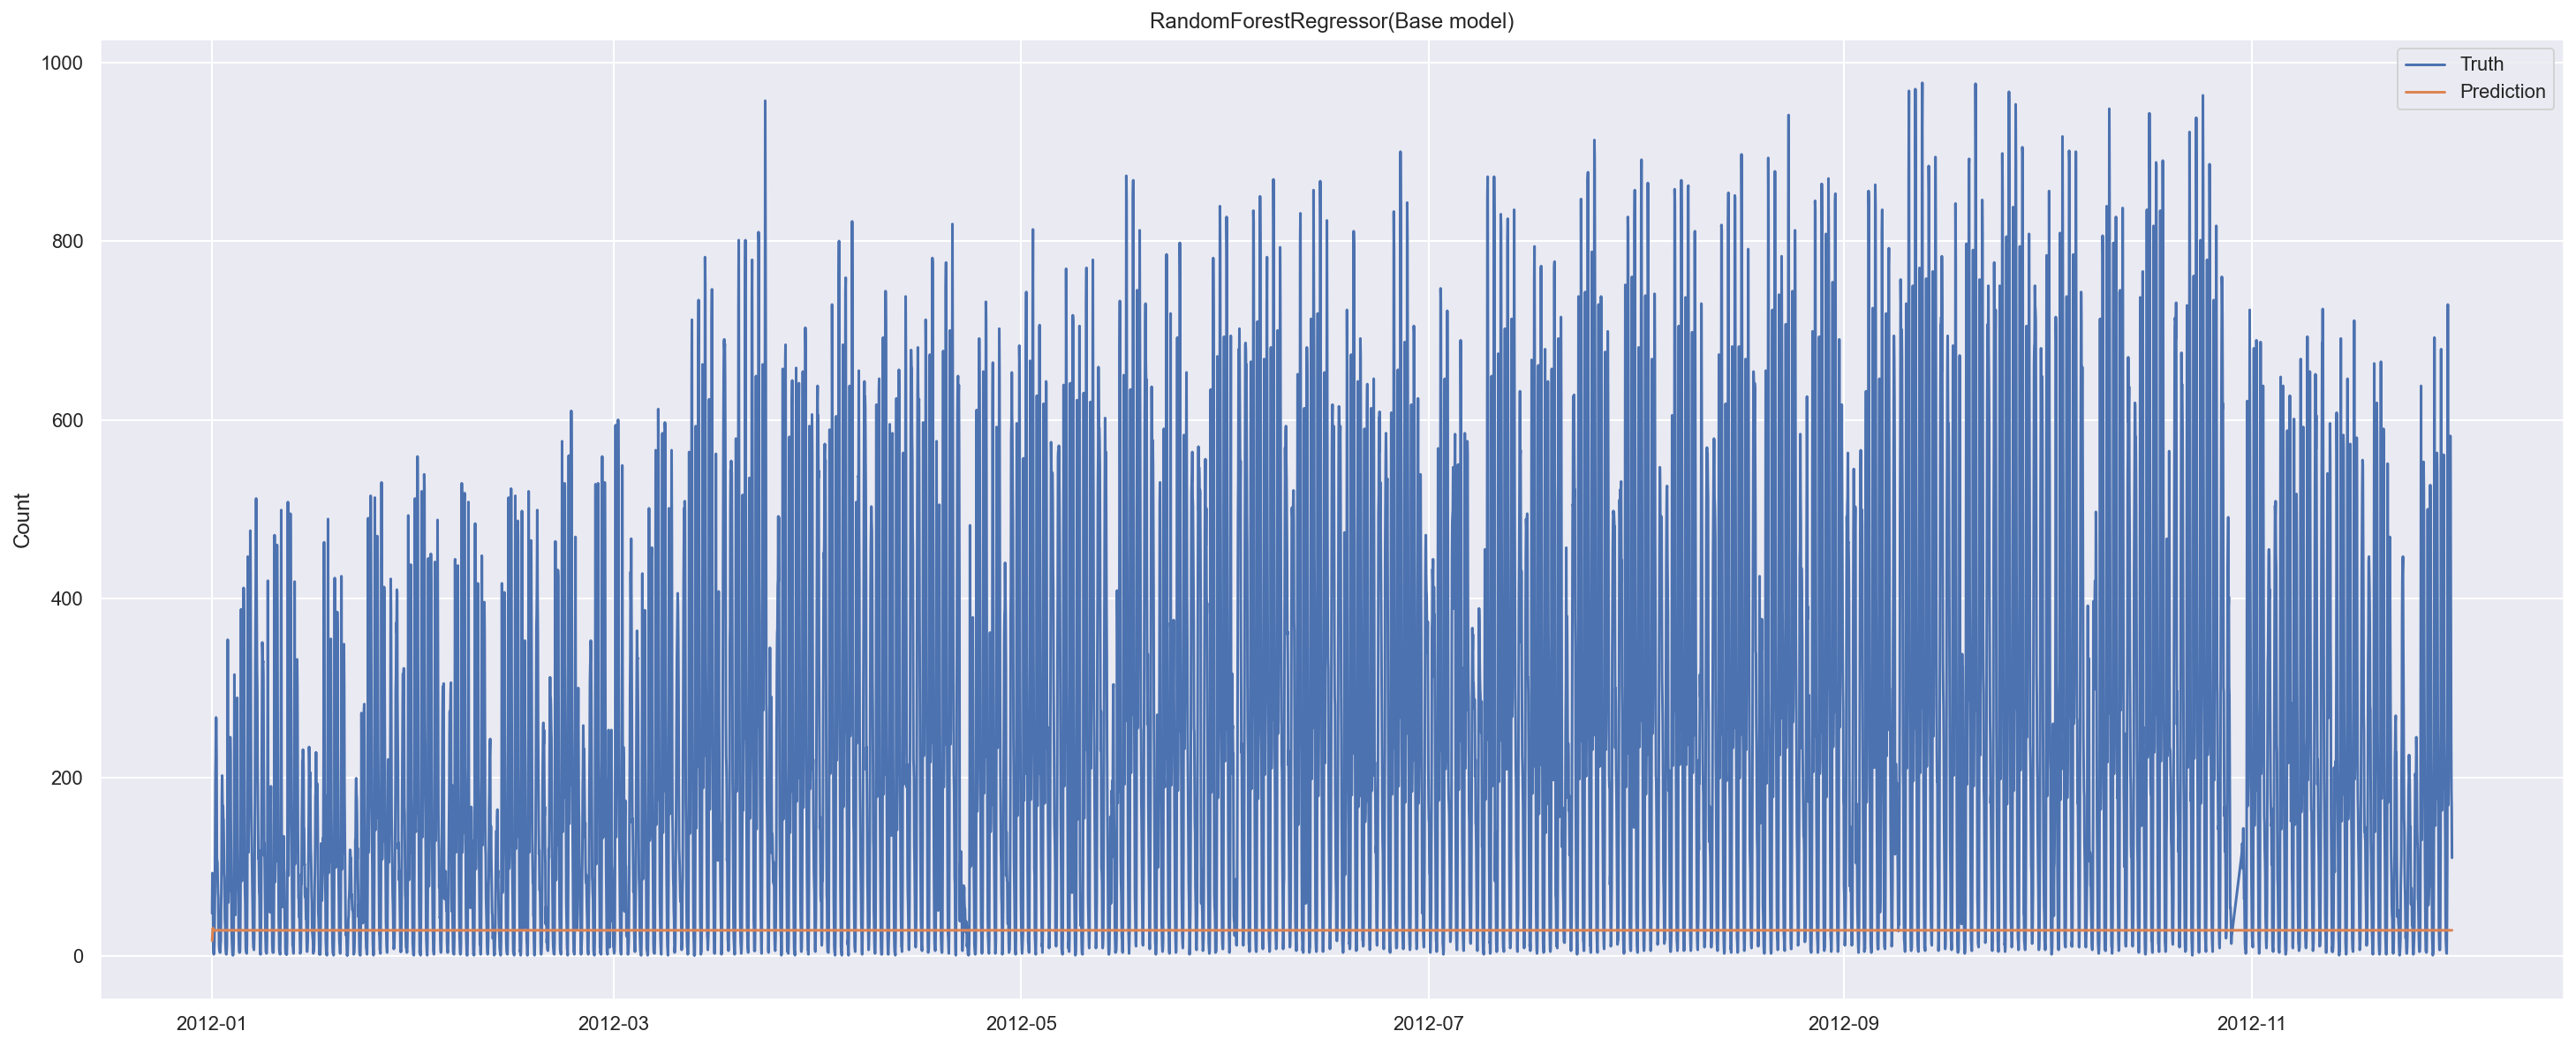

In [358]:
import pmdarima as pm
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

print("pmdarima version: %s" % pm.__version__)

# Load the data and split it into separate pieces
train = df_train['cnt'][:'2012-01-01'].values
test = df_train['cnt']['2012-01-01':].values
df_test_AR = df_train['2012-01-01':]

# Let's create a pipeline with multiple stages...
pipe = pipeline.Pipeline([
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=True, 
                              suppress_warnings=True))
])

pipe.fit(train)
print("Model fit:")
print(pipe)

# We can compute predictions the same way we would on a normal ARIMA object:
preds = pipe.predict(n_periods=len(test))
print("\nForecasts:")
print(preds)

df_test_AR['predicted'] = preds

# Plot comparison results between predicted and real values
plt.plot(df_test_AR['cnt'],
         label='Truth')
plt.plot(df_test_AR['predicted'],
         label='Prediction')
plt.title("RandomForestRegressor(Base model)")
plt.ylabel('Count')
plt.legend();
plt.show()

___________________________________

___________________________________

## DecisionTreeRegressor

Train R2 score DecisionTreeRegressor Pipeline 0.9999305173868195
Train NEGATIVE MAPE: -0.00048579691987014927
Test R2 score DecisionTreeRegressor Pipeline 0.9999305173868195
Test NEGATIVE MAPE: -0.00048579691987014927


holiday  weekday  workingday  weathersit  temp   hum  \
Date                                                                        
2012-12-01 00:00:00        0        6           0           1  0.26  0.81   
2012-12-01 01:00:00        0        6           0           1  0.26  0.81   
2012-12-01 02:00:00        0        6           0           2  0.26  0.81   
2012-12-01 03:00:00        0        6           0           2  0.26  0.81   
2012-12-01 04:00:00        0        6           0           1  0.26  0.81   
...                      ...      ...         ...         ...   ...   ...   
2012-12-31 19:00:00        0        1           1           2  0.26  0.60   
2012-12-31 20:00:00        0        1           1           2  0.26  0.60   
2012-12-31 21:00:00        0        1           1           1  0.26  0.60   
2012-12-31 22:00:00        0        1           1           1  0.26  0.56   
2012-12-31 23:00:00        0        1           1           1  0.26  0.65   

                     windspeed  count  
Date                                   
2012-12-01 00:00:00     0.0000     75  
2012-12-01 01:00:00     0.0000     75  
2012-12-01 02:00:00     0.0000    180  
2012-12-01 03:00:00     0.1343    180  
2012-12-01 04:00:00     0.0896    111  
...                        ...    ...  
2012-12-31 19:00:00     0.1642    282  
2012-12-31 20:00:00     0.1642    282  
2012-12-31 21:00:00     0.1642    282  
2012-12-31 22:00:00     0.1343     82  
2012-12-31 23:00:00     0.1343     66  

[742 rows x 8 columns]

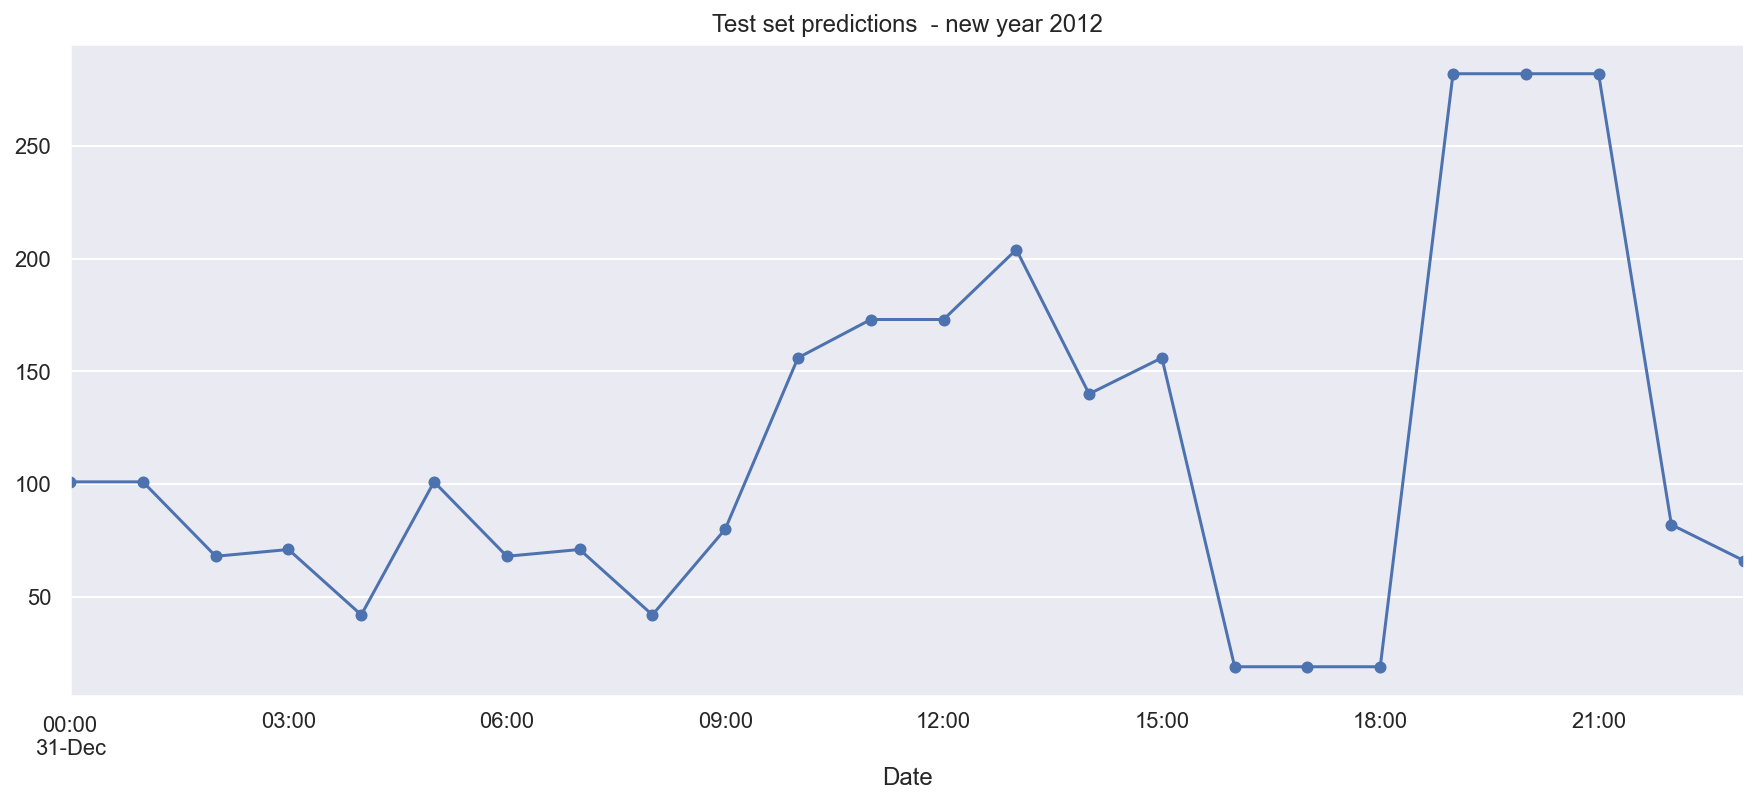

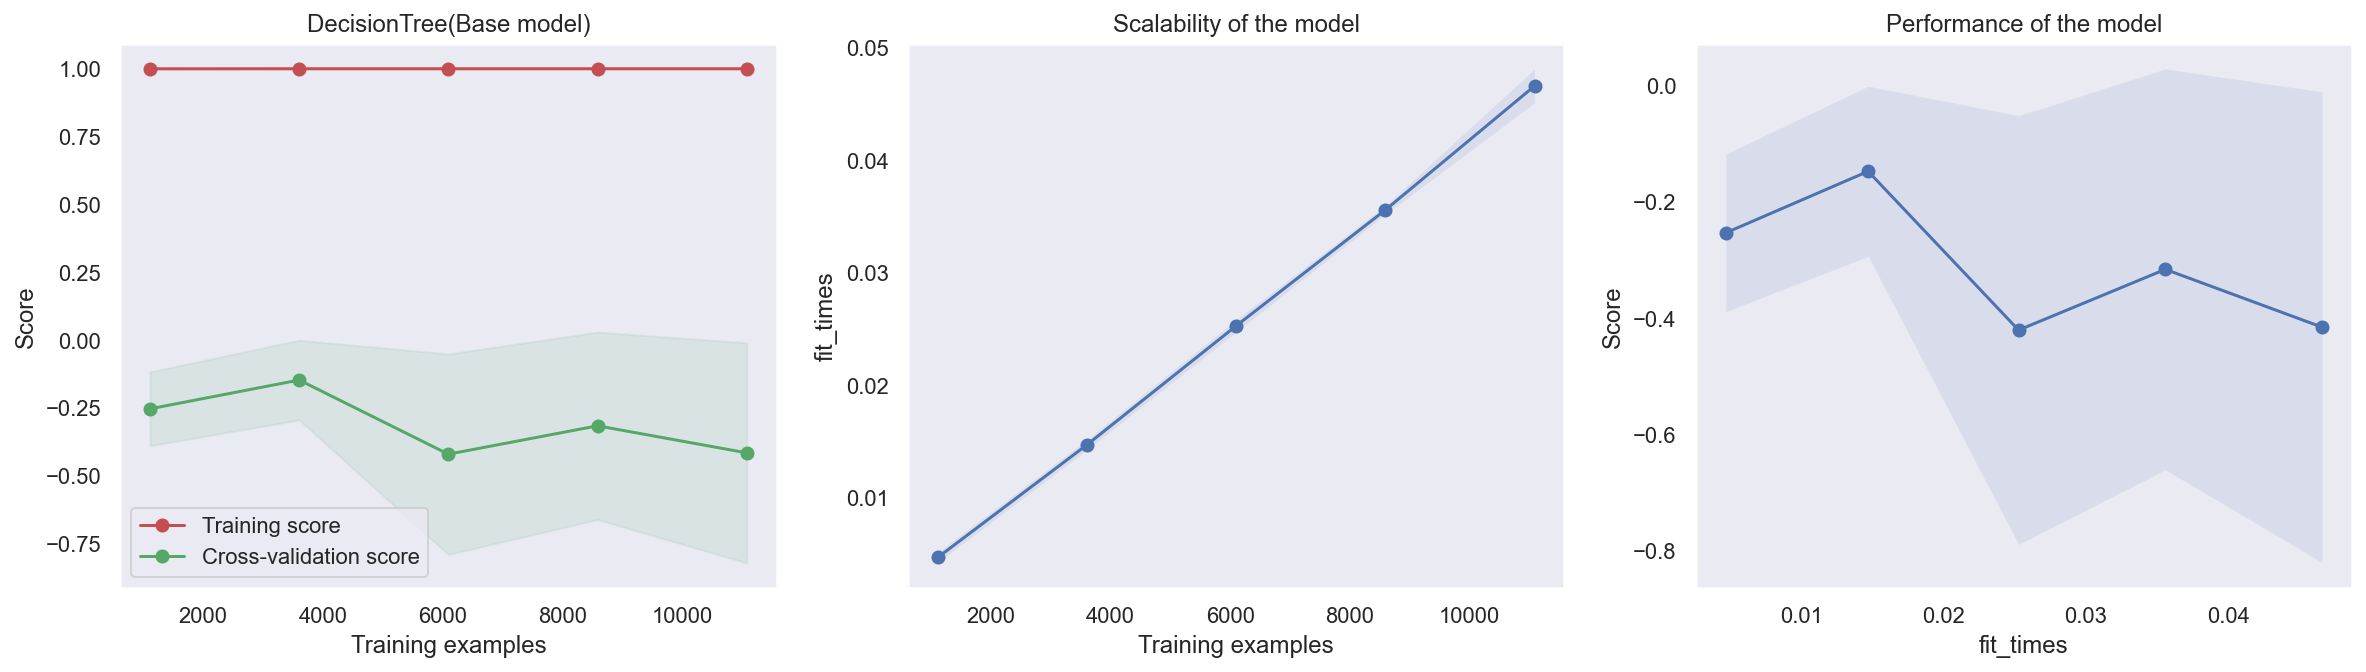

In [359]:
df_train_R = df_train.rolling(7, center=True).mean()

df_train_R = df_train_R.dropna()

X_train = df_train_R.drop('cnt', axis=1).values
X_test = df_train_R.drop('cnt', axis=1).values
y_train = df_train_R['cnt'].values
y_test = df_train_R['cnt'].values

pipe = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler()), 
                ('model', DecisionTreeRegressor())
                ])

pipe.fit(X_train, y_train)
print("Train R2 score DecisionTreeRegressor Pipeline", pipe.score(X_train, y_train))
print('Train NEGATIVE MAPE:', -mean_absolute_percentage_error(y_train, pipe.predict(X_train)))

print("Test R2 score DecisionTreeRegressor Pipeline", pipe.score(X_train, y_train))
print('Test NEGATIVE MAPE:', -mean_absolute_percentage_error(y_test, pipe.predict(X_test)))

df_test['count'] = pipe.predict(df_test.drop('count', axis=1).values).astype(int)

df_test_res_h = df_test['count']['2012-12-31':'2012-12-31']
df_test_res_h.plot(figsize=(15, 6), title='Test set predictions  - new year 2012', marker='.', markersize=10, linestyle='-')

plot_learning_curve(DecisionTreeRegressor(), "DecisionTree(Base model)", X_train, y_train, cv=3);

df_test

__________________________________________________

__________________________________

## Other models tested and ignored - less accuracy score

DT: NEG_MAPE=-0.819277 (STD=0.106297) (R2=0.999931)
LR: NEG_MAPE=-0.805846 (STD=0.119461) (R2=0.386278)
GBR: NEG_MAPE=-0.679746 (STD=0.114731) (R2=0.575579)
NN: NEG_MAPE=-0.793429 (STD=0.166475) (R2=0.449334)
KNN: NEG_MAPE=-0.673419 (STD=0.106223) (R2=0.797664)
RF: NEG_MAPE=-0.743602 (STD=0.113471) (R2=0.938945)
SVR: NEG_MAPE=-0.824728 (STD=0.167420) (R2=0.200680)


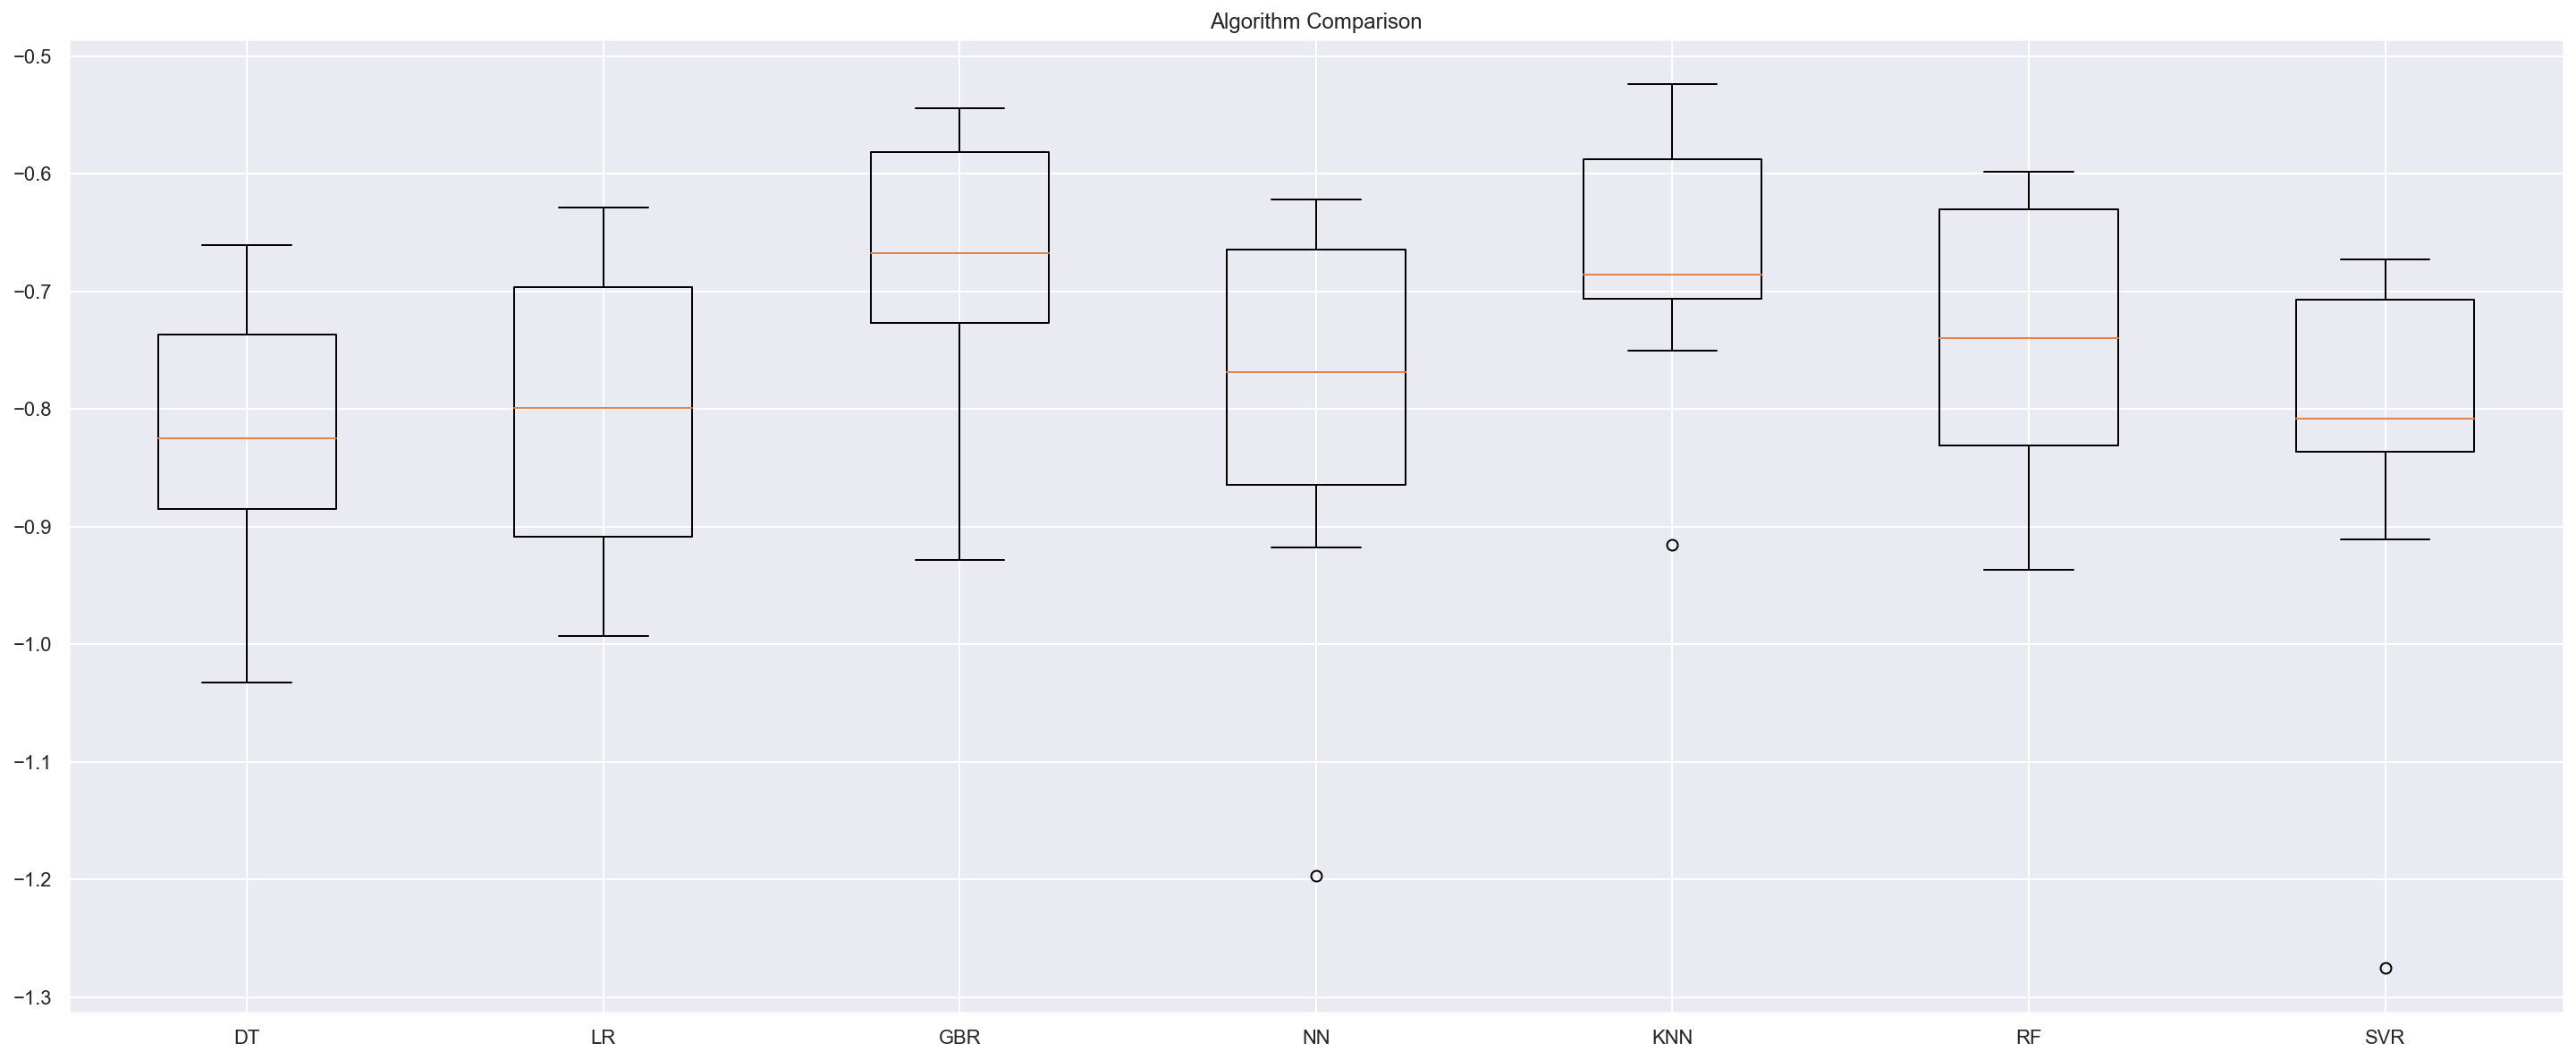

In [360]:
# Spot Check Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

def _models_score():
    models = []
    models.append(('DT', DecisionTreeRegressor()))
    models.append(('LR', LinearRegression()))
    models.append(('GBR', GradientBoostingRegressor()))
    models.append(('NN', MLPRegressor(hidden_layer_sizes=(32, 8), solver = 'adam', max_iter=2000)))  #neural network
    models.append(('KNN', KNeighborsRegressor())) 
    models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
    models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

    # Evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(n_splits=10)

        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring=neg_mape)
        results.append(cv_results)
        names.append(name)
        model.fit(X_train, y_train)
        print('%s: NEG_MAPE=%f (STD=%f) (R2=%f)' % (name, cv_results.mean(), cv_results.std(), model.score(X_train, y_train)))


    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison')
    plt.show()
    
_models_score()

In [361]:
# This cell may take some time to be executed

model = SVR(gamma='auto')
param_search = { 
    'kernel': ['poly'],
    'degree': [2, 3],
    'C': [5, 10, 20]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = neg_mape)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
print(best_score)
best_model = gsearch.best_estimator_
print(best_model)

-0.7793261607281213
SVR(C=20, degree=2, gamma='auto', kernel='poly')


In [362]:
print("Test R2 score SVR best model", best_model.score(X_train, y_train))

Test R2 score SVR best model 0.3451311126032589


In [363]:
# sklearn documentation say to use LinearSVR instead of SVR model for large number of data

from sklearn import svm
from sklearn.kernel_approximation import Nystroem

data = X_train
linear_svr = svm.LinearSVR()
feature_map_nystroem = Nystroem(gamma=.2, random_state=1, n_components=300)
data_transformed = feature_map_nystroem.fit_transform(data)
linear_svr.fit(data_transformed, y_train)
print("Test R2 score Linear SVR base", linear_svr.score(data_transformed, y_train))

model = svm.LinearSVR()
param_search = { 
    #'kernel': ['linear', 'rbf', 'poly'],
    'epsilon':[0.1,0.2,0.5,0.3],
    #'gamma': [0.001, 0.01, 0.1, 0.5, 0.8, 1.3],
    #'degree': [2, 3],
    'C': [5, 10, 20, 50, 100, 200, 500, 1000]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = neg_mape)
gsearch.fit(data_transformed, y_train)
best_score = gsearch.best_score_
print(best_score)
best_model = gsearch.best_estimator_
print(best_model)

Test R2 score Linear SVR base 0.21670470713585888
-0.7473018844830391
LinearSVR(C=10, epsilon=0.2)


Best Model GridSearchCV: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', LinearSVR(C=1000, epsilon=0.2))])
Train score RandomForestRegressor GridSearchCV model 0.24882979244607661
Train NEGATIVE MAPE: -3.2076090154094223
Train NEGATIVE MAE: -84.18830984999741


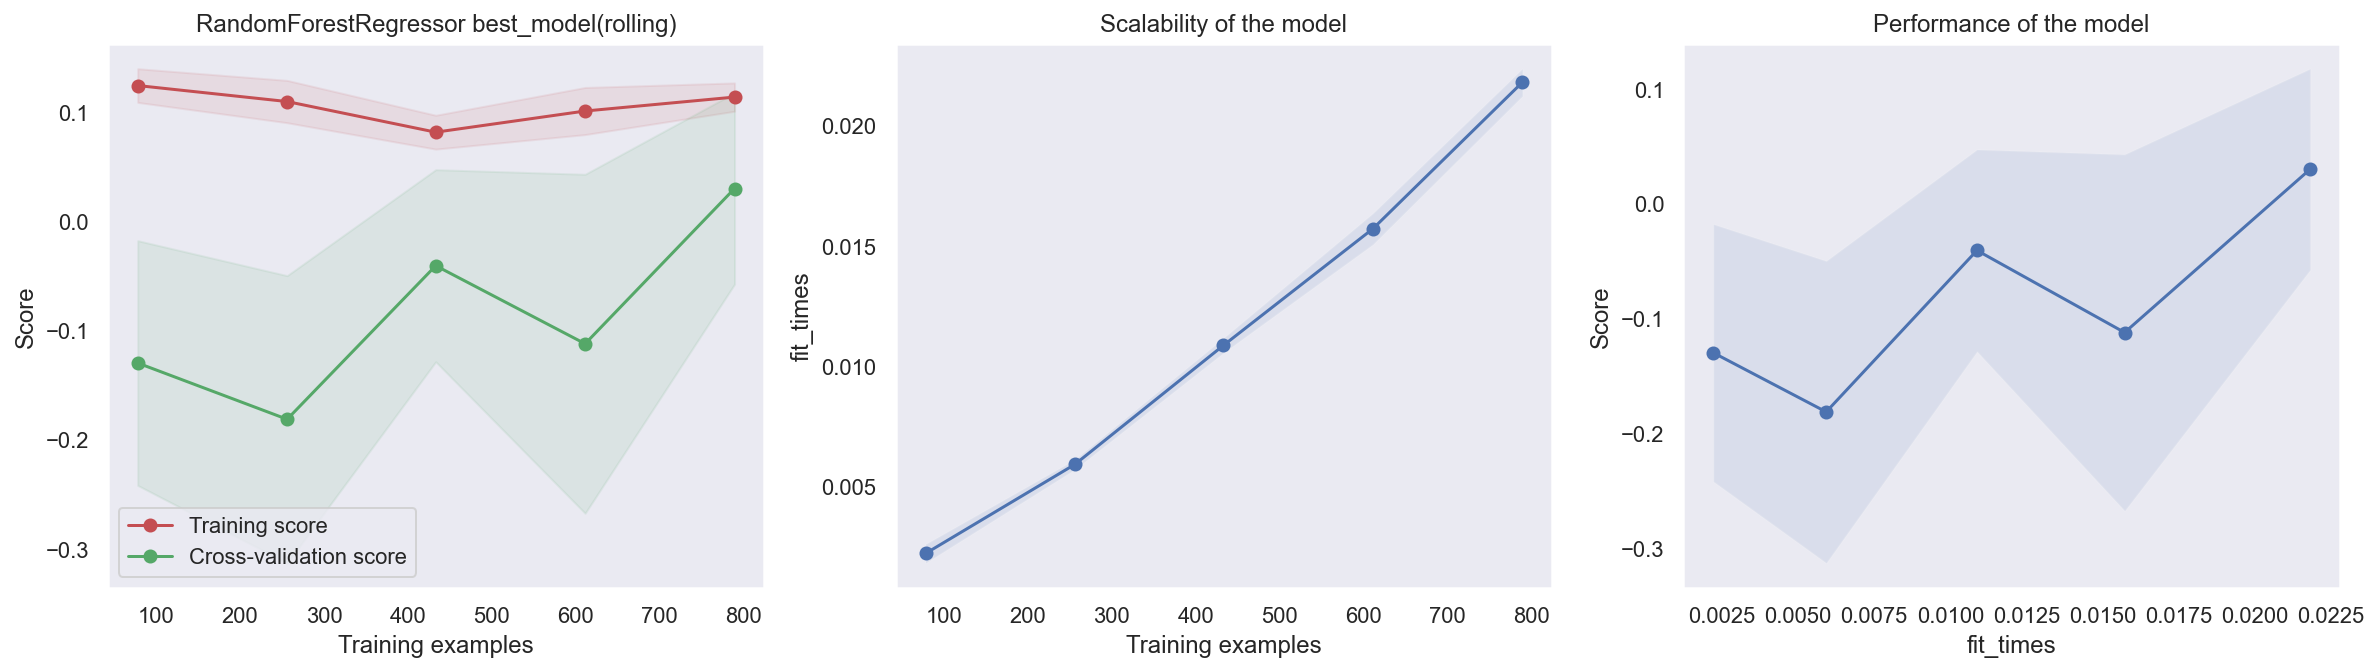

In [364]:
from sklearn import svm
from sklearn.kernel_approximation import Nystroem

X_train = df_train.drop('cnt', axis=1)[:'2012-01-01'].values
X_test = df_train.drop('cnt', axis=1)['2012-01-01':].values
y_train = df_train['cnt'][:'2012-01-01'].values
y_test = df_train['cnt']['2012-01-01':].values

pipe = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler()), 
                ('model', svm.LinearSVR())
                ])

param_search = { 
    'model__epsilon':[0.1,0.2,0.5,0.3],
    'model__C': [5, 10, 20, 50, 100, 200, 500, 1000]
}

neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=10)

#gsearch = GridSearchCV(estimator=pipe, cv=tscv, param_grid=param_search, scoring=neg_mape)
gsearch = GridSearchCV(pipe, param_grid=param_search, cv=tscv, refit=True, scoring=neg_mape)

gsearch.fit(X_train, y_train)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print("Best Model GridSearchCV:", best_model)
print("Train score RandomForestRegressor GridSearchCV model", best_model.score(X_train, y_train))
print("Train NEGATIVE MAPE:", best_score)
print("Train NEGATIVE MAE:", -mean_absolute_error(y_train, best_model.predict(X_train)))

plot_learning_curve(best_model, "RandomForestRegressor best_model(rolling)", X_train, y_train, cv=tscv);

Best Model GridSearchCV: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', SGDRegressor(alpha=1.3, epsilon=0.3))])
Train score RandomForestRegressor GridSearchCV model 0.2263343274288817
Train NEGATIVE MAPE: -3.9589075678232084
Train NEGATIVE MAE: -91.03809922250103


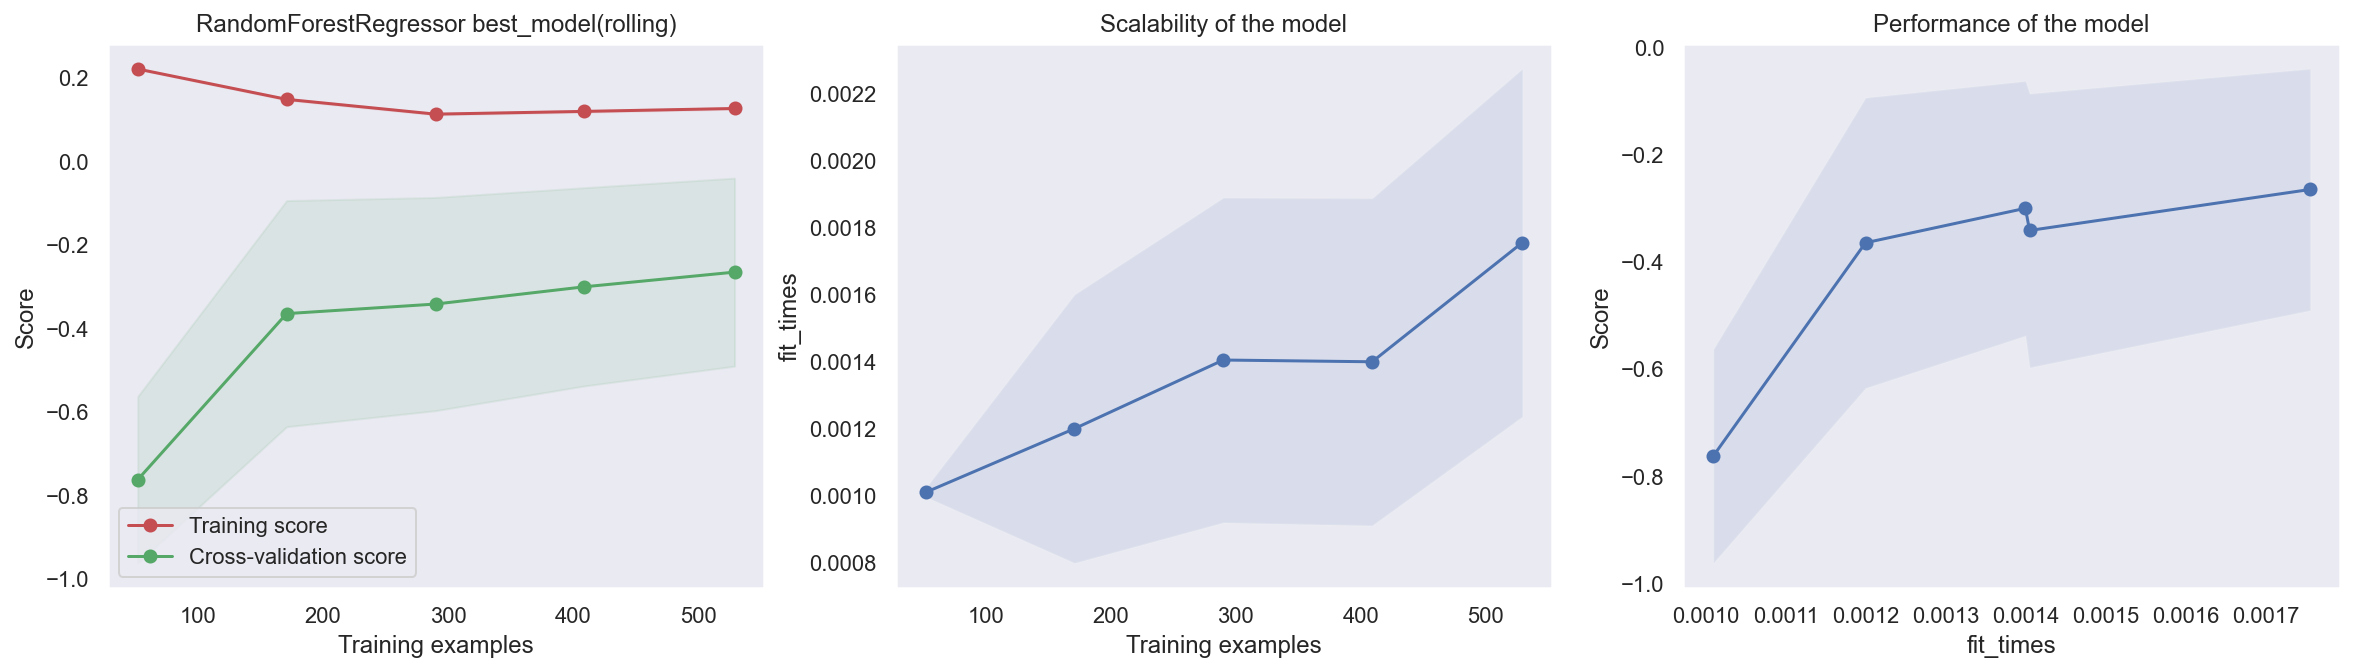

In [365]:
from sklearn.linear_model import SGDRegressor

X_train = df_train.drop('cnt', axis=1)[:'2011-09-01'].values
X_test = df_train.drop('cnt', axis=1)['2011-09-01':].values
y_train = df_train['cnt'][:'2011-09-01'].values
y_test = df_train['cnt']['2011-09-01':].values

pipe = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler()), 
                ('model', SGDRegressor())
                ])

param_search = { 
    'model__epsilon':[0.1,0.2,0.5,0.3],
    'model__alpha': [0.001, 0.01, 0.1, 0.5, 0.8, 1.3]
}

neg_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
tscv = TimeSeriesSplit(n_splits=10)

#gsearch = GridSearchCV(estimator=pipe, cv=tscv, param_grid=param_search, scoring=neg_mape)
gsearch = GridSearchCV(pipe, param_grid=param_search, cv=tscv, refit=True, scoring=neg_mape)

gsearch.fit(X_train, y_train)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print("Best Model GridSearchCV:", best_model)
print("Train score RandomForestRegressor GridSearchCV model", best_model.score(X_train, y_train))
print("Train NEGATIVE MAPE:", best_score)
print("Train NEGATIVE MAE:", -mean_absolute_error(y_train, best_model.predict(X_train)))

plot_learning_curve(best_model, "RandomForestRegressor best_model(rolling)", X_train, y_train, cv=tscv);